# Twitter Sentiment Analysis of COVID-19 in the state of Virginia

## Introduction
The United States is in disarray. It started with the onset of COVID-19, an extremely contagious respiratory virus with an estimated mortality rate of 3-4% according to the World Health Organization.  The rate for at-risk populations—elderly, and those with underlying conditions such as heart disease, diabetes, asthma, etc.— is much higher. Much of the country is shut down, and on March 30, 2020 Virginia Governor Ralph Northam declared a stay-at-home order until June 10th. States across the country are grappling to design a testing and tracing infrastructure before opening the economy back up. Opinions on how and when to reopen the country are varied.

The COVID-19 pandemic is going to have long-lasting impacts on our public health, economy, and way of life. From the dramatic increase in unemployment to the subsequent loneliness and depression caused by social distancing measures, the mental health impact of COVID-19 will be substantial. For my Capstone project, I am using Twitter data from Virginia to track daily sentiment toward the virus (and stay-at-home measures) as the virus travels through the state. The goal of this project is to create an auxiliary surveillance tool for the Virginia Department of Health (DOH) that uses social media data to track sentiment towards COVID-19 and the stay-at-home measures in place.

## Public Health Surveillance using Twitter Data
“Health organizations require accurate and timely disease surveillance techniques in order respond to emerging epidemics. Such information may inform planning for surges in patient visits, therapeutic supplies, and public health information dissemination campaigns.” (Broniatowski, Paul & Dredze, M, 2013.). However, real-time data collection is very expensive and simply not feasible for most organizations.  As such, ongoing research continues into using social media for real-time disease and health surveillance.

Using social media data for public health surveillance is not a new idea, and in fact the Center for Disease Control and Prevention (CDC) has been using Twitter for influenza surveillance for almost a decade. The goal of this project is not to necessarily use Twitter data to estimate COVID-19 prevalence using the frequency of COVID-related Tweets as the CDC has done with influenza surveillance, though I will look to see if COVID sentiment leads or lags reported cases. The goal is broadly exploratory, aiming to monitor sentiment towards the virus and the stay-at-home measures by time and location. In addition to highlighting areas in which sentiment is particularly low (and potentially triggering investigation by the VA DOH), the idea is to set up a framework for the VA DOH to use Twitter for surveillance for the remainder of the COVID lifespan. Right now, we are looking at stay-at-home measures, but when things reopen it could be identifying COVID resurgence hot spots (via text frequency or sentiment), or measuring response towards the vaccine once available.


In [19]:
import re,string
import nltk

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

# Data

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 9th.



In [ ]:
# Read in final merged cleaned data
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_200527.pkl")
# Tweet frequency file
date_freq_df= pd.read_pickle('date_freq_df.pickle')
# Virginia daily sentiment score
daily_sentiment_VA = pd.read_pickle('daily_sentiment_VA_final.pkl')

In [20]:
# #### Read in COVID pull data ###
# # Find a more efficient way to do this
# data = pd.read_csv("va_pull_0407.csv") 
# data_0407 = data[data['X1']=='2020-04-07']
# data = pd.read_csv("va_pull_0408.csv") 
# data_0408 = data[data['X1']=='2020-04-08']
# data = pd.read_csv("va_pull_0409.csv") 
# data_0409 = data[data['X1']=='2020-04-09']
# data = pd.read_csv("va_pull_0410.csv") 
# data_0410 = data[data['X1']=='2020-04-10']
# data = pd.read_csv("va_pull_0411.csv") 
# data_0411 = data[data['X1']=='2020-04-11']
# data = pd.read_csv("va_pull_0412.csv") 
# data_0412 = data[data['X1']=='2020-04-12']
# data = pd.read_csv("va_pull_0413.csv") 
# data_0413 = data[data['X1']=='2020-04-13']
# data = pd.read_csv("va_pull_0414.csv") 
# data_0414 = data[data['X1']=='2020-04-14']
# data = pd.read_csv("va_pull_0415.csv") 
# data_0415 = data[data['X1']=='2020-04-15']
# data = pd.read_csv("va_pull_0416.csv") 
# data_0416 = data[data['X1']=='2020-04-16']
# data = pd.read_csv("va_pull_0417.csv") 
# data_0417 = data[data['X1']=='2020-04-17']
# data = pd.read_csv("va_pull_0418.csv") 
# data_0418 = data[data['X1']=='2020-04-18']
# data = pd.read_csv("va_pull_0419.csv") 
# data_0419 = data[data['X1']=='2020-04-19']
# data = pd.read_csv("va_pull_0420.csv") 
# data_0420 = data[data['X1']=='2020-04-20']
# data = pd.read_csv("va_pull_0421.csv") 
# data_0421 = data[data['X1']=='2020-04-21']
# data = pd.read_csv("va_pull_0422.csv") 
# data_0422 = data[data['X1']=='2020-04-22']
# data = pd.read_csv("va_pull_0423.csv") 
# data_0423 = data[data['X1']=='2020-04-23']
# data = pd.read_csv("va_pull_0424.csv") 
# data_0424 = data[data['X1']=='2020-04-24']
# data = pd.read_csv("va_pull_0425.csv") 
# data_0425 = data[data['X1']=='2020-04-25']
# data = pd.read_csv("va_pull_0426.csv") 
# data_0426 = data[data['X1']=='2020-04-26']
# data = pd.read_csv("va_pull_0427.csv") 
# data_0427 = data[data['X1']=='2020-04-27']
# data = pd.read_csv("va_pull_0428_redo.csv") 
# data_0428 = data[data['X1']=='2020-04-28']
# data = pd.read_csv("va_pull_0429.csv") 
# data_0429 = data[data['X1']=='2020-04-29']
# data = pd.read_csv("va_pull_0430.csv") 
# data_0430 = data[data['X1']=='2020-04-30']
# data = pd.read_csv("va_pull_0501.csv") 
# data_0501 = data[data['X1']=='2020-05-01']
# data = pd.read_csv("va_pull_0502.csv") 
# data_0502 = data[data['X1']=='2020-05-02']
# data = pd.read_csv("va_pull_0503.csv") 
# data_0503 = data[data['X1']=='2020-05-03']
# data = pd.read_csv("va_pull_0504.csv") 
# data_0504 = data[data['X1']=='2020-05-04']
# data = pd.read_csv("va_pull_0505.csv") 
# data_0505 = data[data['X1']=='2020-05-05']
# data = pd.read_csv("va_pull_0506.csv") 
# data_0506 = data[data['X1']=='2020-05-06']
# data = pd.read_csv("va_pull_0507.csv") 
# data_0507 = data[data['X1']=='2020-05-07']
# data = pd.read_csv("va_pull_0508.csv") 
# data_0508 = data[data['X1']=='2020-05-08']
# data = pd.read_csv("va_pull_0509.csv") 
# data_0509 = data[data['X1']=='2020-05-09']
# data = pd.read_csv("va_pull_0510.csv") 
# data_0510 = data[data['X1']=='2020-05-10']
# data = pd.read_csv("va_pull_0511.csv") 
# data_0511 = data[data['X1']=='2020-05-11']
# data = pd.read_csv("va_pull_0512.csv") 
# data_0512 = data[data['X1']=='2020-05-12']
# data = pd.read_csv("va_pull_0513.csv") 
# data_0513 = data[data['X1']=='2020-05-13']
# data = pd.read_csv("va_pull_0514.csv") 
# data_0514 = data[data['X1']=='2020-05-14']
# data = pd.read_csv("va_pull_0515.csv") 
# data_0515 = data[data['X1']=='2020-05-15']
# data = pd.read_csv("va_pull_0516.csv") 
# data_0516 = data[data['X1']=='2020-05-16']
# data = pd.read_csv("va_pull_0517.csv") 
# data_0517 = data[data['X1']=='2020-05-17']
# data = pd.read_csv("va_pull_0518.csv") 
# data_0518 = data[data['X1']=='2020-05-18']
# data = pd.read_csv("va_pull_0519.csv") 
# data_0519 = data[data['X1']=='2020-05-19']
# data = pd.read_csv("va_pull_0520.csv") 
# data_0520 = data[data['X1']=='2020-05-20']
# data = pd.read_csv("va_pull_0521.csv") 
# data_0521 = data[data['X1']=='2020-05-21']
# data = pd.read_csv("va_pull_0522.csv") 
# data_0522 = data[data['X1']=='2020-05-22']
# data = pd.read_csv("va_pull_0526.csv") 
# data_0523 = data[data['X1']=='2020-05-23']
# data = pd.read_csv("va_pull_0526.csv") 
# data_0524 = data[data['X1']=='2020-05-24']

In [8]:
# Get COVID related tweet frequencies
# dates = [ data_0515, data_0516, data_0517, data_0518, data_0519, data_0520, data_0521, data_0522]

# date_freq_df['date'] = [ '5/15','5/11', '5/12', '5/13', '5/14']

In [26]:
# # Get COVID related tweet frequencies
dates = [data_0407, data_0408, data_0409, data_0410, data_0411, data_0412, data_0413, data_0414, data_0415, data_0416,
        data_0417, data_0418, data_0419, data_0420, data_0421, data_0422, data_0423, data_0424, data_0425,
        data_0426, data_0427, data_0428, data_0429, data_0430, data_0501, data_0502, data_0503, data_0504,
        data_0505, data_0506, data_0507, data_0508, data_0509, data_0510, data_0511, data_0512, data_0513, data_0514, 
         data_0515, data_0516, data_0517, data_0518, data_0519, data_0520, data_0521, data_0522, data_0523, data_0524]

In [27]:
date_freq = []

for date in dates:
    freq = len(date)
    date_freq.append(freq)

date_freq_df = pd.DataFrame(date_freq, columns = ['frequency'],) 

In [28]:
# Add labels to frequency data frame
date_freq_df['date'] = ['4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27', '4/28',
                       '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10',
                        '5/11', '5/12', '5/13', '5/14', '5/15', '5/16', '5/17', '5/18', '5/19', '5/20', '5/21',
                       '5/22', '5/23', '5/24']

In [29]:
#date_freq_df.to_pickle("date_freq_df.pickle")
date_freq_df

frequency  date
0   49194      4/7 
1   47847      4/8 
2   45651      4/9 
3   41537      4/10
4   29042      4/11
5   24927      4/12
6   39581      4/13
7   42231      4/14
8   42962      4/15
9   42669      4/16
10  41275      4/17
11  28116      4/18
12  25605      4/19
13  36791      4/20
14  39757      4/21
15  39729      4/22
16  40021      4/23
17  40748      4/24
18  24309      4/25
19  21595      4/26
20  33294      4/27
21  36471      4/28
22  36587      4/29
23  33881      4/30
24  32373      5/1 
25  21167      5/2 
26  19881      5/3 
27  30628      5/4 
28  32616      5/5 
29  31959      5/6 
30  30995      5/7 
31  28065      5/8 
32  19382      5/9 
33  16915      5/10
34  27842      5/11
35  30581      5/12
36  29496      5/13
37  29910      5/14
38  28412      5/15
39  17735      5/16
40  16253      5/17
41  25878      5/18
42  26843      5/19
43  26704      5/20
44  28031      5/21
45  24522      5/22
46  15421      5/23
47  15982      5/24

In [13]:
# Read in frequency file from last run and append new data
date_freq_df= pd.read_pickle('date_freq_df.pickle')
#date_freq_df = previous_date_freq_df.append(date_freq_df,ignore_index=True)
#previous_date_freq_df

# Geolocation EDA

In [14]:
# # use dates from above to merge all files into one raw file
# merged = pd.concat(dates, axis=0, sort=False)
# print(merged.info())
# print(merged.X1.value_counts()) # Double check counts by day are correct

In [15]:
# len(merged)

In [16]:
# # Check those that gave exact coordinates of Tweet
# a = pd.DataFrame(merged.geo_coords.value_counts())
# a.drop

In [17]:
# # Calculate percentage
# gave_exact_location = len(merged) - a.iloc[0]
# print('Gave exact location/geocoords: ', gave_exact_location/ len(merged))

In [18]:
# Check those that have location data in thier profile
# gave_user_location = merged.location.count()
# print(gave_user_location)
# print('Gave user location: ', gave_user_location/ len(merged))

In [19]:
# # To merge VA data sets to get a sense of scale
# # use dates from above to merge all files into one raw file
# merged_va = pd.concat(va_dates, axis=0, sort=False)
# print(merged_va.info())
# print(merged_va.X1.value_counts()) # Double check counts by day are correct

# Create Crosswalk of user-reported location names to county names

First ran on 4/25 using data as of 4/23. There were 656935 records. Collapsed "location", then cleaned it. Pulled it into excel to map to county names. Loaded into Google Maps API.

Run this again when new user-provided locations are added.

In [20]:
# # collapse location data to create county level crosswalk
# names = pd.DataFrame(merged.location.value_counts())
# names.reset_index(inplace=True)
# names.columns=['name', 'count']

In [21]:
# #create list of all texts for cleaning
# location_text=[]
# for i in range(0,len(names)):
#     temp_text=names['name'].iloc[i]
#     location_text.append(temp_text)
    
# #print(location_text)

In [22]:
# location_text_test = location_text[0:15]
# print(location_text_test)

In [23]:
# # Need to lowercase all locations
# # Find a more efficient way to do this!

# def clean_location(location): 
#     tokens=location.split()
#     re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     tokens = [word for word in tokens if word.isalpha()]
#     tokens = [word.lower() for word in tokens]  
#     return tokens

# location_text_lower=[]

# # Process documents - pros
# for i in location_text:
#     text=clean_location(i)
#     location_text_lower.append(text)

# location_text_lower_com = []

# for i in location_text_lower:
#     temp_DSI=" ".join(str(item) for item in i )
#     location_text_lower_com.append(temp_DSI)
    
# print(location_text[0])
# print(location_text_lower_com[0:100])

In [24]:
# # Collapse again for crosswalk
# location_df = pd.DataFrame(location_text_lower_com)
# location_df.columns = ['name']
# location_df = pd.DataFrame(location_df.name.value_counts())
# location_df.to_csv('loc_names.csv') # Save location names to make location crosswalk

## Load crosswalk back in to merged with cleaned locations

In [30]:
# Read in crosswalk to merge with merged df
crosswalk = pd.read_csv("un_crosswalk_working.csv") # updated on 5/27/2020
crosswalk.columns = ['num_index', 'location', 'county_name']
crosswalk['location'] = crosswalk['location'].astype('str')
crosswalk.drop(columns=['num_index'], inplace=True)
crosswalk.dtypes

# Create dictionary to map county names to cleaned locations
mydict = dict(zip(crosswalk.location, crosswalk.county_name))

In [31]:
crosswalk

location      county_name
0      amen corner      accomack county
1      belle haven va   accomack county
2      bloxom virginia  accomack county
3      cashville        accomack county
4      cashville usa    accomack county
...              ...                ...
17931  ùü≠ùü∞         exclude        
17932  ùüèùüè         exclude        
17933  ùüèùüë         exclude        
17934  ùüô∆º           exclude        
17935  ùüôùüö         exclude        

[17936 rows x 2 columns]

## Clean daily data set separately for location

First we clean the user provide location - remove punctuation, remove numbers, Then we map the cleaned location to our crosswalk. The crosswalk was created by running all cleanded locations through the Google Maps API and updated periodically.

Non-VA locations are excluded from this analysis as are user locations that I was unable to code to one of the 133 counites or independent cities in VA.

In [32]:
def clean_location(location): 
    tokens=location.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]  
    return tokens

In [33]:
# To clean locations in merged data set for crosswalk merge

#create list of all texts for cleaning
def process_location_data(data):
    data['location'] = data['location'].astype('str') 
    locs_to_clean=[]
    for i in range(0,len(data)):
        temp_text=data['location'].iloc[i]
        locs_to_clean.append(temp_text)
    
    processed_locs=[]

    for i in locs_to_clean:
        text=clean_location(i)
        processed_locs.append(text)

    final_locs = []

    for i in processed_locs:
        temp_DSI=" ".join(str(item) for item in i )
        final_locs.append(temp_DSI)
    
#     print(locs_to_clean[0:5])
#     print(final_locs[0:5])
    
    data['location_cleaned'] = np.array(final_locs) # Append cleaned location to data frame
    data['county_name']= data['location_cleaned'].map(mydict) # Add county_name using mydict county crosswalk

In [34]:
# Clean each data set
for date in dates:
    process_location_data(date)

# Merge cleaned location data sets together

In [35]:
# # Read in last merged file
# merged= pd.read_pickle('merged_final_200527.pkl')
# merged

In [36]:
# use dates from above to merge all files into one raw file
merged = pd.concat(dates, axis=0, sort=False)
print(merged.info())
print(merged.X1.value_counts()) # Double check counts by day are correct

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491411 entries, 35984 to 82067
Data columns (total 94 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   user_id                  1491411 non-null  object 
 1   status_id                1491411 non-null  object 
 2   created_at               1491411 non-null  object 
 3   screen_name              1491411 non-null  object 
 4   text                     1491411 non-null  object 
 5   source                   1491411 non-null  object 
 6   display_text_width       1491411 non-null  int64  
 7   reply_to_status_id       270336 non-null   object 
 8   reply_to_user_id         297605 non-null   object 
 9   reply_to_screen_name     297605 non-null   object 
 10  is_quote                 1491411 non-null  bool   
 11  is_retweet               1491411 non-null  bool   
 12  favorite_count           1491411 non-null  int64  
 13  retweet_count            1491411 non-nul

In [37]:
merged.county_name.value_counts(dropna=False)

exclude                  1323988
arlington county         22452  
richmond city            21347  
fairfax county           15667  
alexandria city          13270  
                         ...    
charlottsville city      1      
pitt county              1      
king and queen county    1      
charlottesville          1      
henderson county         1      
Name: county_name, Length: 139, dtype: int64

In [38]:
# Count NA locations - these need to be reviewd and added to crosswalk
merged.county_name.isnull().sum() 

3781

In [34]:
# # Save merged file
# merged.to_pickle("merged_final_200527.pkl")

In [39]:
len(merged)

1491411

# Second Location Crosswalk

On 5/3 had 59717 NAN county_names - time to do another crosswalk clean

On 5/27 (with data as of 5/22) had 5392 NAN county_names - last crosswalk

In [40]:
# UNKNOWN = merged[merged["county_name"].isna()]
# Unknown_locations = pd.DataFrame(UNKNOWN.location_cleaned.value_counts())
# Unknown_locations.to_csv('Unknown_locations_200522.csv') # Save location names to make location crosswalk
# Unknown_locations

In [41]:
# Remove non-Virginia county_names
merged2 = merged[merged['county_name'].notna()]
merged3 = merged2[merged2['county_name']!= 'exclude']
merged3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163642 entries, 36273 to 82067
Data columns (total 94 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  163642 non-null  object 
 1   status_id                163642 non-null  object 
 2   created_at               163642 non-null  object 
 3   screen_name              163642 non-null  object 
 4   text                     163642 non-null  object 
 5   source                   163642 non-null  object 
 6   display_text_width       163642 non-null  int64  
 7   reply_to_status_id       26674 non-null   object 
 8   reply_to_user_id         30352 non-null   object 
 9   reply_to_screen_name     30352 non-null   object 
 10  is_quote                 163642 non-null  bool   
 11  is_retweet               163642 non-null  bool   
 12  favorite_count           163642 non-null  int64  
 13  retweet_count            163642 non-null  int64  
 14  q

In [42]:
# Save to file
merged3.to_pickle("merged3_final_200527.pkl")

In [43]:
# frequency of total tweets per day
total_freq = pd.DataFrame(merged.X1.value_counts())
total_freq.reset_index(inplace=True)

# frequency of total tweets per day
va_freq = pd.DataFrame(merged3.X1.value_counts())
va_freq.reset_index(inplace=True)

In [44]:
# check out Tweet frequency
a = pd.DataFrame(merged3.X1.value_counts())
a.reset_index(inplace=True)
a.sort_values(by='index', ascending=True)

index    X1
0   2020-04-07  5407
1   2020-04-08  5343
2   2020-04-09  5061
3   2020-04-10  4734
33  2020-04-11  2939
36  2020-04-12  2562
9   2020-04-13  4471
7   2020-04-14  4574
4   2020-04-15  4724
5   2020-04-16  4644
6   2020-04-17  4620
34  2020-04-18  2844
37  2020-04-19  2532
14  2020-04-20  4050
12  2020-04-21  4148
11  2020-04-22  4267
10  2020-04-23  4362
8   2020-04-24  4545
38  2020-04-25  2481
40  2020-04-26  2240
16  2020-04-27  3719
13  2020-04-28  4095
15  2020-04-29  3982
17  2020-04-30  3692
19  2020-05-01  3569
39  2020-05-02  2257
42  2020-05-03  2033
23  2020-05-04  3420
18  2020-05-05  3616
20  2020-05-06  3529
22  2020-05-07  3420
26  2020-05-08  3284
41  2020-05-09  2079
45  2020-05-10  1733
29  2020-05-11  3146
25  2020-05-12  3387
24  2020-05-13  3399
21  2020-05-14  3501
27  2020-05-15  3218
43  2020-05-16  1853
46  2020-05-17  1727
32  2020-05-18  3050
31  2020-05-19  3050
30  2020-05-20  3052
28  2020-05-21  3155
35  2020-05-22  2745
47  2020-05-23  1641
44  2020-05-24  1742

In [46]:
a.X1.sum()

163642

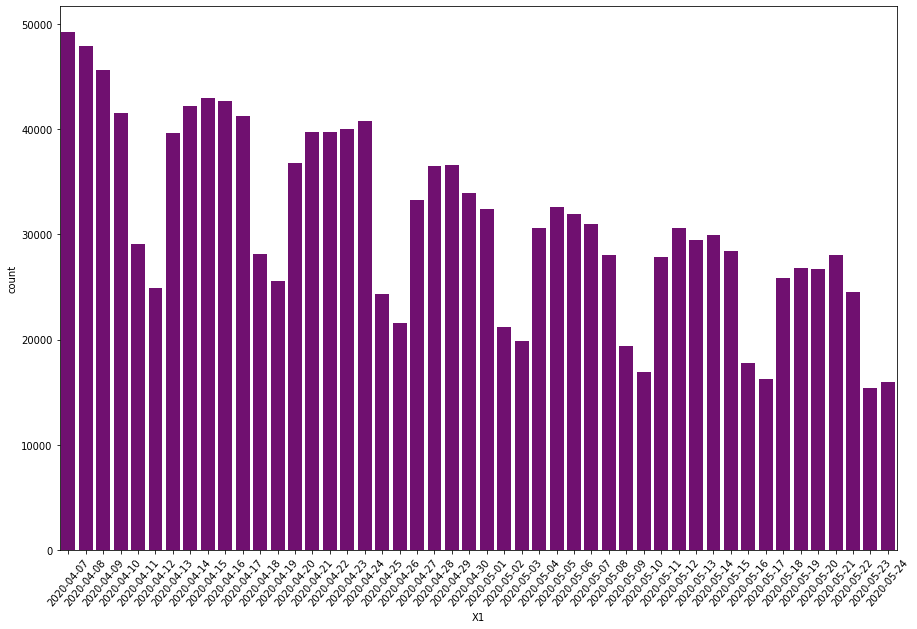

In [40]:
# Total Tweets by Day
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="X1", data=merged, color="purple")
plt.setp(ax.get_xticklabels(), rotation=50);

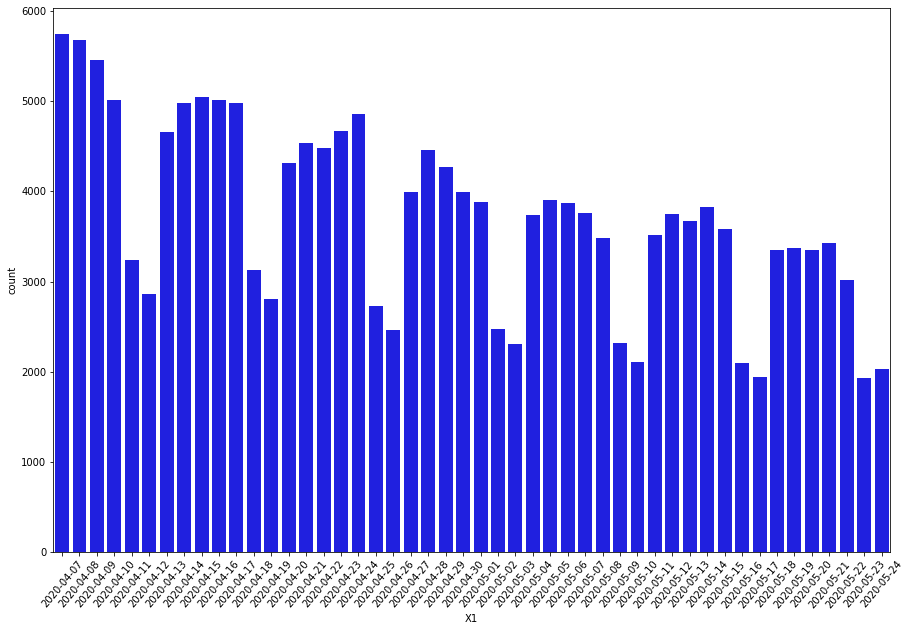

In [41]:
# VA Tweets by Day
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="X1", data=merged3, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

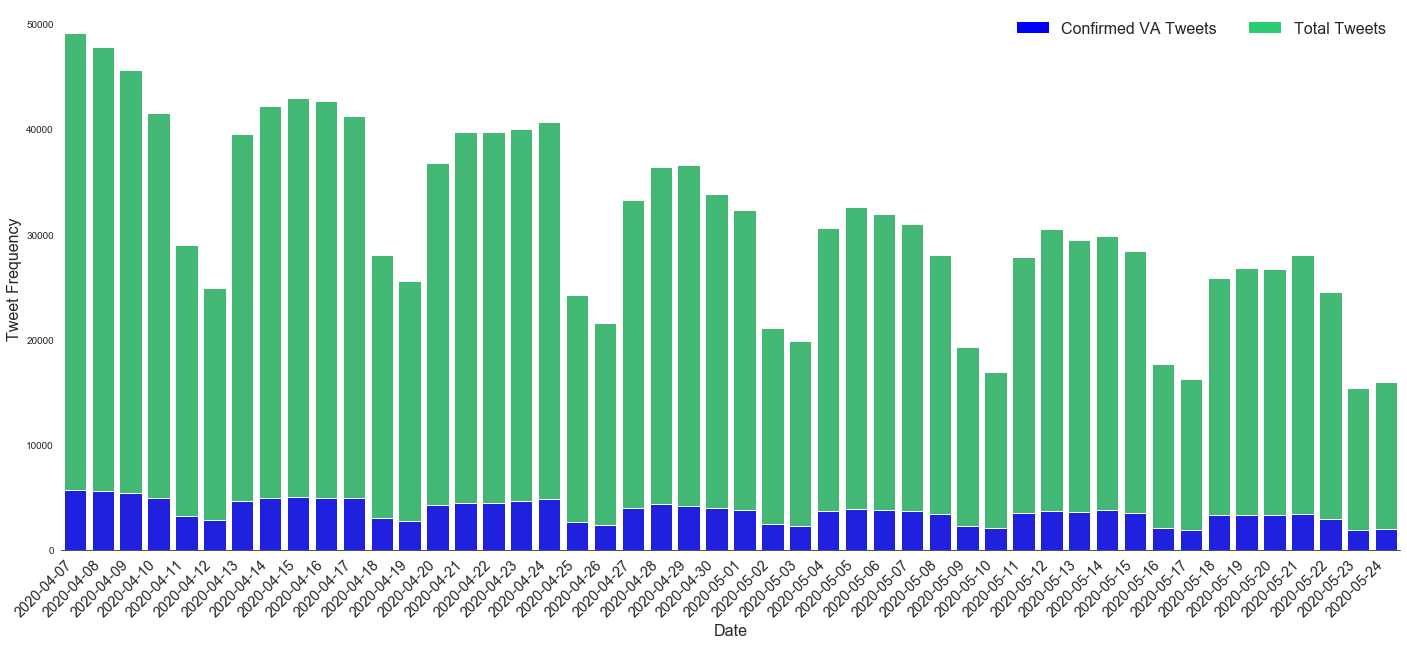

In [42]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.countplot(x="X1", data=merged, color="#2ecc71")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.countplot(x="X1", data=merged3, color="b")

topbar = plt.Rectangle((0,0),1,1,fc="#2ecc71", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='b',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Confirmed VA Tweets', 'Total Tweets'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Tweet Frequency", size=16)
bottom_plot.set_xlabel("Date", size=16)

#Set fonts to consistent 16pt size

bottom_plot.set_xticklabels(
    bottom_plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large');

plt.savefig("Tweet Frequency Bar Chart", tight_layout=False)
# plt.figure(figsize=(8, 5))
# plt.setp(ax.get_xticklabels(), rotation=50);



In [18]:
len(merged3)


NameError: name 'merged3' is not defined

# Additional Data Processing
 - Remove non-English Tweets
 - Remove news outlets and serial Tweeters


In [47]:
# Select date to review
data = merged3
# Language distribution by daily data
print(data.lang.value_counts)

#Drop non-english tweets
data = data[data['lang'] == 'en']
data.X1.value_counts()

<bound method IndexOpsMixin.value_counts of 36273    en
36534    en
36692    en
36694    en
36696    en
         ..
82038    en
82043    en
82047    en
82051    en
82067    en
Name: lang, Length: 163642, dtype: object>


2020-04-07    5176
2020-04-08    5107
2020-04-09    4825
2020-04-10    4490
2020-04-15    4485
2020-04-16    4443
2020-04-14    4407
2020-04-17    4404
2020-04-24    4343
2020-04-13    4231
2020-04-23    4208
2020-04-22    4082
2020-04-21    3974
2020-04-28    3872
2020-04-20    3867
2020-04-29    3760
2020-04-27    3557
2020-04-30    3547
2020-05-05    3486
2020-05-01    3399
2020-05-06    3348
2020-05-14    3329
2020-05-07    3272
2020-05-13    3251
2020-05-04    3247
2020-05-12    3229
2020-05-08    3150
2020-05-15    3067
2020-05-21    3010
2020-05-11    2995
2020-05-19    2913
2020-05-18    2910
2020-05-20    2904
2020-04-11    2740
2020-04-18    2678
2020-05-22    2621
2020-04-19    2384
2020-04-12    2374
2020-04-25    2353
2020-05-02    2129
2020-04-26    2118
2020-05-09    1965
2020-05-03    1896
2020-05-16    1738
2020-05-24    1633
2020-05-10    1620
2020-05-17    1601
2020-05-23    1548
Name: X1, dtype: int64

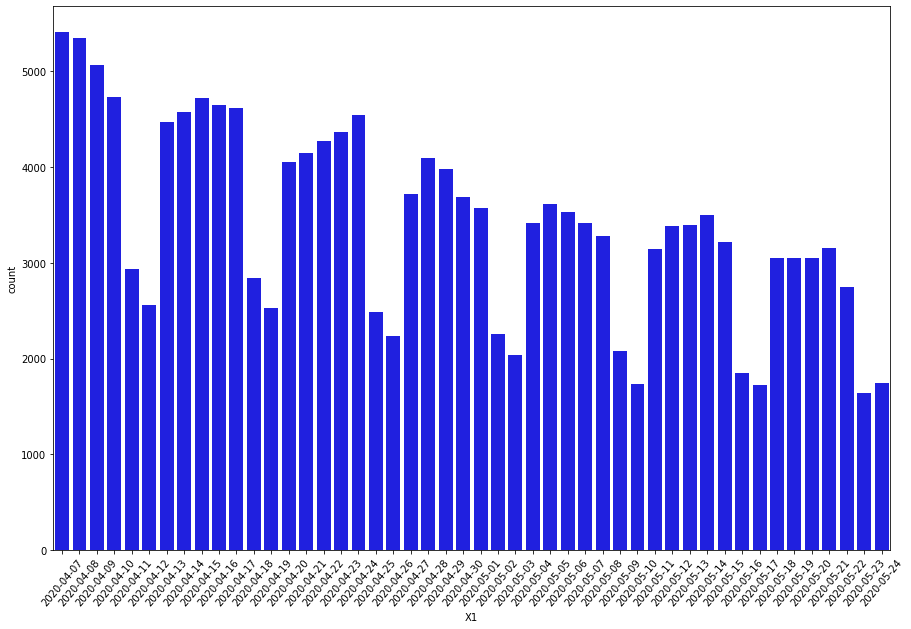

In [48]:
# VA Tweets by Day - English Only
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="X1", data=merged3, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

## Twitter Account Stats

There are many accounts that belong to news outlets or folks that simply tweet news articles from thier account. The objective of this analysis is to surveil the VA general population's social media reactios re:COVID, I am deleting accounts with large numbers of tweets per day.



In [49]:
data.screen_name.value_counts()

#4060 unique usernames out of 8357 tweets
#Issue with accounts like @Ahighervision - just tweets out news articles - seems like his tweet text is 
# exactly the same as the title of article - 3% of all tweets for this data set!

Ahighervision      2649
Heerak4Congress    1430
BLaw               1270
MattMurph24        1255
WFXRnews           1168
                   ... 
thegirlisdope      1   
ChrisClary2        1   
JessSwoboda        1   
KPMadonia          1   
JudyWonus          1   
Name: screen_name, Length: 25403, dtype: int64

In [50]:
2626/len(data)
# Ahighervision has 1.5% of all the tweets!

0.016867284148863737

In [51]:
# Frequency of twitter accounts - need to change this to per day when I process daily files
account_freq_df = pd.DataFrame(data.screen_name.value_counts())
account_freq_df
print(account_freq_df.describe())

# #Histogram of tweets per user
# plt.figure(figsize=(10, 7.5))
# ax = sns.distplot(account_freq_df.screen_name)

        screen_name
count  25403.000000
mean   6.128646    
std    33.731551   
min    1.000000    
25%    1.000000    
50%    2.000000    
75%    4.000000    
max    2649.000000 


In [52]:
pd.set_option('display.max_rows', 500)
account_freq_df

screen_name
Ahighervision    2649       
Heerak4Congress  1430       
BLaw             1270       
MattMurph24      1255       
WFXRnews         1168       
...               ...       
thegirlisdope    1          
ChrisClary2      1          
JessSwoboda      1          
KPMadonia        1          
JudyWonus        1          

[25403 rows x 1 columns]

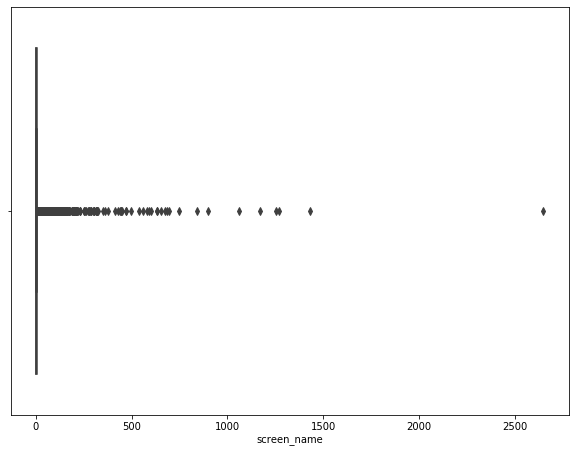

In [53]:
#Boxplot of tweets per user
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(account_freq_df.screen_name)

In [54]:
from scipy import stats
import numpy as np
account_freq_df['zscore'] = np.abs(stats.zscore(account_freq_df.screen_name))
account_freq_df

screen_name     zscore
Ahighervision    2649         78.351670
Heerak4Congress  1430         42.212686
BLaw             1270         37.469259
MattMurph24      1255         37.024563
WFXRnews         1168         34.445324
...               ...               ...
thegirlisdope    1            0.152046 
ChrisClary2      1            0.152046 
JessSwoboda      1            0.152046 
KPMadonia        1            0.152046 
JudyWonus        1            0.152046 

[25403 rows x 2 columns]

In [55]:
# Removing outliers from data frame
top_accounts = account_freq_df[account_freq_df['zscore'] >3]
print(len(top_accounts))
top_accounts.reset_index(inplace=True)
top_accounts

138


index  screen_name     zscore
0    Ahighervision    2649         78.351670
1    Heerak4Congress  1430         42.212686
2    BLaw             1270         37.469259
3    MattMurph24      1255         37.024563
4    WFXRnews         1168         34.445324
5    NBC12            1058         31.184218
6    8NEWS            899          26.470438
7    13NewsNow        839          24.691653
8    news5wcyb        749          22.023475
9    virginianpilot   695          20.422568
10   mikelotus        682          20.037165
11   AskCapitalOne    674          19.799994
12   MagnoliaG2012    651          19.118126
13   kstreet111       634          18.614137
14   whatifisaidit    631          18.525198
15   NBC29            601          17.635805
16   tcomer4418       590          17.309694
17   CBS6             578          16.953937
18   Consortiumnews   560          16.420302
19   WDBJ7            537          15.738434
20   tax              497          14.552578
21   rooseveltFellow  473          13.841063
22   Daily_Press      469          13.722478
23   NewsLeaderNOW    450          13.159196
24   ABC13News        443          12.951671
25   wsls             443          12.951671
26   campusreform     438          12.803439
27   Lil_COVID        431          12.595914
28   nicktompan       412          12.032632
29   LopezTaxes       379          11.054300
30   RTDNEWS          362          10.550311
31   Cigarvolante     348          10.135261
32   CandiceRose      323          9.394101 
33   DNRnews          319          9.275515 
34   roanoketimes     318          9.245869 
35   Appalachia100    317          9.216222 
36   AugFreePress     314          9.127283 
37   HobanGirl        313          9.097637 
38   kerrykelly514    304          8.830819 
39   NewsInTheBurg    303          8.801172 
40   softwarnet       301          8.741880 
41   VoteBlueIn2020   300          8.712233 
42   virginiasbdc     288          8.356476 
43   MadaganSharon    287          8.326830 
44   MilitaryOfficer  282          8.178598 
45   lrmartinjr       277          8.030365 
46   DailyProgress    275          7.971073 
47   environment      270          7.822841 
48   clakor54         264          7.644962 
49   stapf            255          7.378144 
50   newsadvance      253          7.318851 
51   newsalliance     250          7.229912 
52   robertcaruso     232          6.696277 
53   SamRobersonJr    231          6.666630 
54   Politidope       228          6.577691 
55   POLITICOPro      221          6.370166 
56   ElueJr           217          6.251580 
57   BruceEppard2     214          6.162641 
58   mrctv            212          6.103348 
59   DCofStaff        211          6.073702 
60   CharlesLuster10  210          6.044055 
61   RickMcCargar     210          6.044055 
62   eclipsethis2003  209          6.014409 
63   MicheleSchiesse  202          5.806884 
64   WYDaily          202          5.806884 
65   chrisvcsefalvay  199          5.717945 
66   fairfaxcounty    198          5.688298 
67   occupyrvanow     198          5.688298 
68   CANorfolk        192          5.510420 
69   SageAdamFi       192          5.510420 
70   LucyAppa         191          5.480773 
71   MajorMikeWebb1   190          5.451127 
72   rockynickydog    188          5.391834 
73   silvermoon820    187          5.362188 
74   AhmedBaba_       187          5.362188 
75   TaxNotes         176          5.036077 
76   SHRMHRNews       175          5.006431 
77   RCNPublisher     174          4.976784 
78   NVICLoeDown      173          4.947138 
79   CamThompsonCBS6  172          4.917492 
80   MikeMiguel       168          4.798906 
81   GoDanRiver       167          4.769259 
82   beshannonphotos  161          4.591381 
83   Wwolfhunt        161          4.591381 
84   vpapupdates      160          4.561735 
85   Dsquared75       159          4.532088 
86   mercatus         158          4.502442 
87   98rockme         157          4.472795 
88   fairf

In [56]:
# Get names of outliers/frequent tweeters to delete
frequent_user_list = top_accounts['index'].tolist()

# Remove outliers/frequent tweeters from data
data = data[~data.screen_name.isin(frequent_user_list)]
len(data)


113157

## Duplicates

In [57]:
# check for duplicates
print(data.retweet_status_id.value_counts(dropna=False)) #no retweets
data.status_id.value_counts()

NaN    113157
Name: retweet_status_id, dtype: int64


x1263849355959832578    2
x1252336855476887553    2
x1256965702508044290    2
x1263114852438020097    2
x1257379480039034880    2
                       ..
x1251147067440783365    1
x1257840918285123600    1
x1254552907946565633    1
x1252282679753572360    1
x1255326795555110914    1
Name: status_id, Length: 113145, dtype: int64

In [58]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = data[data.duplicated('text')]
duplicateRowsDF
dupes = pd.DataFrame(duplicateRowsDF.status_id)
dupe_list = dupes["status_id"].tolist()
len(dupe_list) #529 duplicate tweets to remove

569

In [59]:
# Remove duplicate tweets - these are not retweets - these are tweets by same user with same content
# 18 in first data set of ~8K
# 529 in data over 700K
data = data[~data.status_id.isin(dupe_list)]
len(data)

112576

In [60]:
merged_cleaned_data = data # Rename to avoid confusion
len(merged_cleaned_data)

112576

In [58]:
# # Save to file
merged_cleaned_data.to_pickle("merged_cleaned_data_final_200527.pkl")

In [59]:
# Read in final merged cleaned data
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_200527.pkl")

## Check out Trump Tweets

In [62]:
# Trump Tweets
data = pd.read_pickle("merged_cleaned_data_final_200527.pkl")

searchfor = ['covid', 'COVID', 'coronavirus', 'pandemic']
data['covid'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['hair', 'facial hair', 'HAIR', 'haircut']
# data['hair'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['birthday', 'Birthday', 'bday']
# data['birthday'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['meantal health', 'depression', 'anxiety', 'crazy']
# data['mental'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['post quarantine', 'after quarantine', 'after this', 'quarantine ends', 'end of quarantine', 'post covid', 'after covid']
# data['post'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['trump', 'president', 'presidenttrump', 'Trump', 'realdonaldtrump', 'donald trump']
data['trump'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['baking', 'cooking', 'bake', 'cook']
# data['baking'] = data['text'].str.contains('|'.join(searchfor), case=False)
# searchfor = ['bored', 'boring']
# data['bored'] = data['text'].str.contains('|'.join(searchfor), case=False)
# For times sake, I just copied this into Excel to format and get percentages
# death_counts = merged_cleaned_data[['X1', 'Death']]
# a = pd.DataFrame(death_counts.groupby('X1').Death.value_counts())
# a.to_csv('death_counts.csv')

print(data.covid.value_counts(normalize=True))
# print(data.hair.value_counts(normalize=True))
# print(data.birthday.value_counts(normalize=True))
# print(data.mental.value_counts(normalize=True))
# print(data.post.value_counts(normalize=True))
print(data.trump.value_counts(normalize=True))
# print(data.baking.value_counts(normalize=True))
# print(data.bored.value_counts(normalize=True))

True     0.831184
False    0.168816
Name: covid, dtype: float64
False    0.920888
True     0.079112
Name: trump, dtype: float64


## Weekends vs Weekdays

Why does frequency drop so much on the weekends? Even after we remove outliers who tweet for work, and news outlets we see the same pattern. Below I look to see if I can run analysis on those that tweet on the weekends.

How do they differ from the people that tweet on the weekdays?

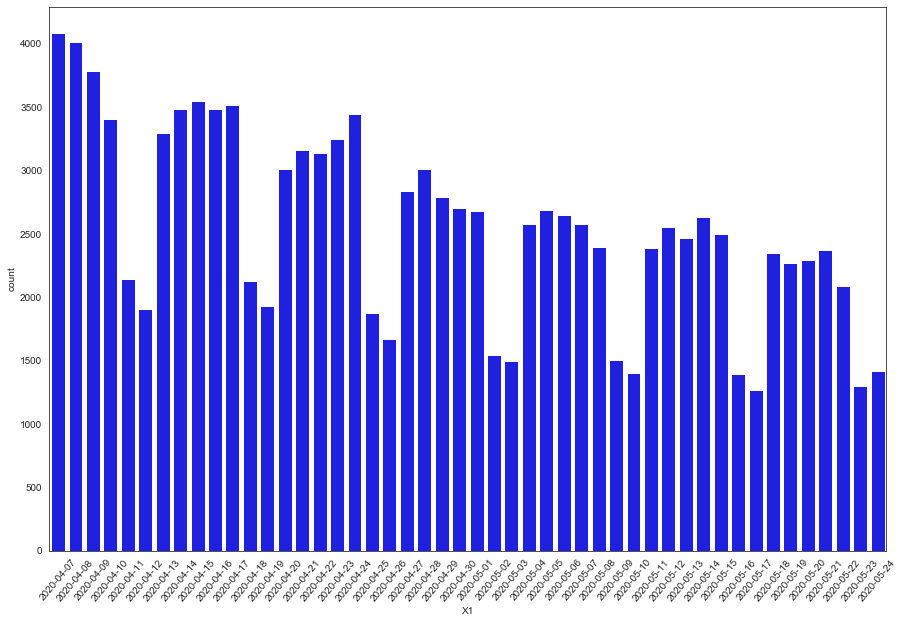

In [60]:
# Double check frequency of cleaned data
# VA Tweets by Day - English Only
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="X1", data=merged_cleaned_data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

In [61]:
print(len(merged_cleaned_data))
a = merged_cleaned_data.screen_name.value_counts()
print(len(a))

122459
28334


In [62]:
# Create weekend only data set

# Pull individual daily data sets from cleaned merged data
data_0407_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-07']
data_0408_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-08']
data_0409_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-09']
data_0410_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-10']
data_0411_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-11']
data_0412_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-12']
data_0413_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-13']
data_0414_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-14']
data_0415_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-15']
data_0416_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-16']
data_0417_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-17']
data_0418_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-18']
data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0420_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-20']
data_0421_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-21']
data_0422_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-22']
data_0423_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-23']
data_0424_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-24']
data_0425_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-25']
data_0426_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-26']
data_0427_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-27']
data_0428_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-28']
data_0429_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-29']
data_0430_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-30']
data_0501_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-01']
data_0502_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-02']
data_0503_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-03']
data_0504_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-04']
data_0505_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-05']
data_0506_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-06']
data_0507_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-07']
data_0508_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-08']
data_0509_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-09']
data_0510_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-10']
data_0511_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-11']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']
data_0513_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-13']
data_0514_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-14']
data_0515_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-15']
data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
data_0517_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-17']
data_0518_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-18']
data_0519_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-19']
data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']
data_0521_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-21']
data_0522_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-22']


In [63]:
weekend_dates = [data_0410_clean, data_0411_clean, data_0417_clean, data_0418_clean, data_0424_clean,
                data_0425_clean, data_0501_clean, data_0502_clean, data_0508_clean,  data_0509_clean,
                data_0510_clean, data_0516_clean, data_0517_clean]

weekdays_dates = [data_0407_clean, data_0408_clean, data_0409_clean, data_0412_clean,data_0413_clean, data_0414_clean, 
                 data_0415_clean, data_0416_clean, data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, 
                 data_0423_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                 data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, data_0507_clean, data_0510_clean, 
                 data_0511_clean, data_0512_clean, data_0513_clean, data_0514_clean, data_0515_clean, data_0518_clean,
                 data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean]

In [64]:
# use dates from above to merge all files into one raw file
weekdays_merged = pd.concat(weekdays_dates, axis=0, sort=False)
#print(weekdays_merged.info())
print(weekdays_merged.X1.value_counts()) # Double check counts by day are correct

2020-04-07    4086
2020-04-08    4018
2020-04-09    3785
2020-04-15    3550
2020-04-14    3489
2020-04-16    3487
2020-04-13    3300
2020-04-23    3251
2020-04-21    3161
2020-04-22    3138
2020-04-20    3016
2020-04-28    3015
2020-04-27    2839
2020-04-29    2794
2020-04-30    2703
2020-05-05    2686
2020-05-06    2646
2020-05-14    2634
2020-05-04    2581
2020-05-07    2580
2020-05-12    2552
2020-05-15    2498
2020-05-13    2468
2020-05-11    2387
2020-05-21    2370
2020-05-18    2347
2020-05-20    2296
2020-05-19    2270
2020-05-22    2092
2020-04-19    1930
2020-04-12    1911
2020-04-26    1667
2020-05-03    1495
2020-05-10    1401
Name: X1, dtype: int64


In [65]:
# use dates from above to merge all files into one raw file
weekend_merged = pd.concat(weekend_dates, axis=0, sort=False)
#print(weekend_merged.info())
print(weekend_merged.X1.value_counts()) # Double check counts by day are correct

2020-04-17    3518
2020-04-24    3444
2020-04-10    3404
2020-05-01    2679
2020-05-08    2400
2020-04-11    2145
2020-04-18    2130
2020-04-25    1872
2020-05-02    1545
2020-05-09    1501
2020-05-10    1401
2020-05-16    1397
2020-05-17    1269
Name: X1, dtype: int64


In [66]:
a = weekdays_merged.screen_name.value_counts()
unique_users = len(a)
print(unique_users)
print(unique_users / len(weekdays_merged))
print(len(weekdays_merged) / unique_users)
print(len(weekdays_merged))
#21,492 unique users for 75,899 Tweets
# Average of 3.53 tweets per user

24092
0.26061464902696796
3.8370828490785325
92443


In [67]:
weekend_merged.screen_name.value_counts()
# 5/14 - 11108 different users on the weekends

WhiteHatGuy      39
RDhillln         38
Mac_Hill33       35
nfhughes         33
Carrollbeyer     32
                 ..
Brook_Ketchum     1
Dstaffenberg      1
Jenibaby10        1
marktronics       1
TheDickBuick      1
Name: screen_name, Length: 12325, dtype: int64

In [68]:
a = weekend_merged.screen_name.value_counts()
unique_users = len(a)
print(unique_users)
print(len(weekend_merged))
print(unique_users / len(weekend_merged))
print(len(weekend_merged) / unique_users)
#11,108 unique users for 24,593 Tweets
# Average of 2.21 tweets per user
# More unique users on weekends than weekdays

12325
28705
0.4293677059745689
2.329006085192698


In [69]:
weekend_tweeters = weekend_merged['screen_name'].tolist()

In [70]:
# Look at only WEEKDAY users
weekdays_tweeters_only = weekdays_merged[~weekdays_merged.screen_name.isin(weekend_tweeters)] # REMOVING WEEKEND NAMES
print(len(weekdays_tweeters_only))
print(len(weekdays_tweeters_only.screen_name.value_counts()))

27185
15612


In [71]:
# Look at only WEEKDAY users
weekdays_with_weekend_tweeters = weekdays_merged[weekdays_merged.screen_name.isin(weekend_tweeters)] #SELECTING ONLY WEEKEND NAMES
print(len(weekdays_with_weekend_tweeters))
print(len(weekdays_with_weekend_tweeters.screen_name.value_counts()))

65258
8480


Type of User	        Unique User Names	   % of Total User Names	Tweets	   % of Total Tweets

Weekend & Weekday users	   7,396	                  29%	            53,578	           52%

Weekday only users	      14,480	                  57%	            24,890	            24%

Weekend only	           3,711	                 15%	            24,564	            24%

Total	                   25,587	                 100%	            103,032	            100%
 
Those that Tweet on the weekend (whether it be weekends only or both weekdays and weekends) make up 44% of the user names but provide 78% of the Tweets. This undermines the hypothesis that a group of weekday users were disproportionatly tweeting. However, note that by definition a user that has only Tweeted about COVID once is defined to the group by which day they Tweeted. If we remove users that have only tweeted once, we get the following table.


In [72]:
# LETS DO IT ALL AGAIN AND REMOVE SINGLE USERS
tweet_stats = pd.DataFrame(merged_cleaned_data.screen_name.value_counts())
singles = tweet_stats[tweet_stats['screen_name'] == 1]
singles.reset_index(inplace=True)
singles


index  screen_name
0             ahbeats2            1
1           mannomann1            1
2           purgoddezz            1
3          BanditHokie            1
4           jessopshel            1
...                ...          ...
14321  eliyarielUSNVet            1
14322       HISSignLLC            1
14323     cheshirelife            1
14324     BryanHarrell            1
14325         JadDaley            1

[14326 rows x 2 columns]

In [73]:
# Create liste of single tweeter screen names
single_tweeters= singles['index'].tolist()

In [74]:
# Remove single users from merged data set
more_than_one_tweeters = merged_cleaned_data[~merged_cleaned_data.screen_name.isin(single_tweeters)]
more_than_one_tweeters.screen_name.value_counts()

karmaal2010        106
ACC_HQ             106
gregkoblentz       106
beth_mulvihill     105
Carrollbeyer       105
                  ... 
ASCPTjournals        2
kezzerb              2
markcallow10         2
UrbanCabinSoaps      2
__demers99           2
Name: screen_name, Length: 14008, dtype: int64

In [75]:
len(more_than_one_tweeters)

108133

In [76]:
tweet_stats

screen_name
gregkoblentz             106
ACC_HQ                   106
karmaal2010              106
beth_mulvihill           105
Carrollbeyer             105
...                      ...
eliyarielUSNVet            1
HISSignLLC                 1
cheshirelife               1
BryanHarrell               1
JadDaley                   1

[28334 rows x 1 columns]

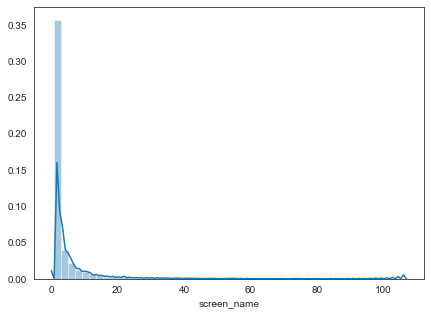

In [77]:
plt.figure(figsize=(7, 5))
ax = sns.distplot(tweet_stats.screen_name)

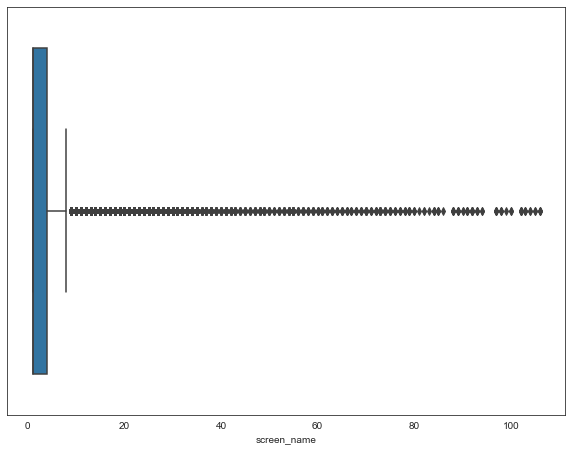

In [78]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(tweet_stats.screen_name)

In [79]:
tweet_stats.describe()

screen_name
count  28334.000000
mean       4.321981
std        8.920690
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max      106.000000

# Calculate overall Sentiment Score

I did this first to create process and assess mean score by county. Later in script I get daily sentiment score by county and overall.


The VADER (Valence Aware Dictionary and sEntiment Reasoner) Python package is a lexicon and rule-based sentiment analysis tool that is specifically developed for sentiment analysis using  social media. VADER has been found to be very good at sentiment analysis of social media data. Unlike other sentiment analysis packages, VADAR provides the portion of the text it finds positive, negative, and neutral and then provides a composite sentiment score.

https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f


In [80]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
from nltk import sent_tokenize, word_tokenize

In [2]:
#data = merged_cleaned_data
data = pd.read_pickle('merged_cleaned_data_final_200527.pkl')
data

user_id             status_id           created_at  \
36534             x17503420  x1247640716366544896  2020-04-07 21:41:41   
36971  x1108447003154022401  x1247672670969303041  2020-04-07 23:48:40   
36973  x1108447003154022401  x1247630744480026624  2020-04-07 21:02:03   
37086   x833159137554989056  x1247634578862485505  2020-04-07 21:17:18   
38014             x54078897  x1247651532503420929  2020-04-07 22:24:40   
...                     ...                   ...                  ...   
82024   x788054067503362048  x1264346081791488002  2020-05-24 00:02:50   
82029             x19984088  x1264345891735048192  2020-05-24 00:02:05   
82038            x362779553  x1264345689422737416  2020-05-24 00:01:17   
82043   x970817055736856577  x1264345543653933057  2020-05-24 00:00:42   
82051             x14304930  x1264345461009321985  2020-05-24 00:00:22   

           screen_name                                               text  \
36534         JonKatz5  "How to Protect Your Mental Health During the ...   
36971   DrLucyHenshall  #Annie #Tomorrow \n#community #singing #Covid_...   
36973   DrLucyHenshall  https://t.co/OYVXzv6a7K via @YouTube\nThink we...   
37086      JCarrollFoy  We now have over 400,000 Virginians covered by...   
38014  AndrewAlixRadio  Crazy to think, if not for coronavirus, we all...   
...                ...                                                ...   
82024    JeromeLegions  collective shoes on the table demanding more t...   
82029     YourJesusGPS  @FoxNewsSunday For Dr. Birx: How can we know t...   
82038         tamsfitz  @DeAnna4Congress I don't think COVID would rea...   
82043    bailey_matela  Thanks ⁦@ramsey_dude⁩ for the upgraded pitchin...   
82051        dgolumbia  #libertarianism is a death cult  https://t.co/...   

                    source  display_text_width    reply_to_status_id  \
36534   Twitter for iPhone                 104                   NaN   
36971   Twitter for iPhone                 195                   NaN   
36973   Twitter for iPhone                 279                   NaN   
37086   Twitter for iPhone                 208                   NaN   
38014   Twitter for iPhone                 150                   NaN   
...                    ...                 ...                   ...   
82024  Twitter for Android                 243  x1264346079686012928   
82029   Twitter for iPhone                 253                   NaN   
82038      Twitter Web App                 116  x1264307705428283392   
82043   Twitter for iPhone                 104                   NaN   
82051   Twitter for iPhone                  56                   NaN   

          reply_to_user_id reply_to_screen_name  ...              profile_url  \
36534                  NaN                  NaN  ...  https://t.co/YVsOIk70Q5   
36971                  NaN                  NaN  ...                      NaN   
36973                  NaN                  NaN  ...                      NaN   
37086                  NaN                  NaN  ...  https://t.co/uQyt8PwbAD   
38014                  NaN                  NaN  ...  https://t.co/vCGFYIUJQH   
...                    ...                  ...  ...                      ...   
82024  x788054067503362048        JeromeLegions  ...  https://t.co/P8Rn8MQ2SQ   
82029            x18805644        FoxNewsSunday  ...  https://t.co/35griO37fl   
82038            x16740433      DeAnna4Congress  ...                      NaN   
82043                  NaN                  NaN  ...                      NaN   
82051                  NaN                  NaN  ...  https://t.co/rafPG1kAbR   

                                    profile_expanded_url  account_lang  \
36534                        http://katzjustice.com/Blog           NaN   
36971                                                NaN           NaN   
36973                                                NaN           NaN   
37086                https://www.jennifercarrollfoy.org/           NaN  

In [3]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body

['"How to Protect Your Mental Health During the Coronavirus"- Emily Esfahani Smith https://t.co/mTFX8yblMp',
 '#Annie #Tomorrow \n#community #singing #Covid_19 \nJoin us 8pm Thursday doorsteps\n@Clive_Harris @Annie_Osb @suffolkgiving @TimHolder11 @balletboy09 @Jochurchill4 @sarsHQ @MarkGlennMurphy @nikkijfox https://t.co/plIW1DJWxc',
 'https://t.co/OYVXzv6a7K via @YouTube\nThink we found our 8pm Thursday evening choirmaster\n#Covid_19 #community #singalong\n@RobBaskind @ClareGerada @DrSdeG @alexandra_DBmed @EM_HealthPsych @AmandaCHoweRCGP @helenamckeown @medicsupport @NikkiKF @fhussain73 @ArtfulDoctor\n@MartinRCGP',
 'We now have over 400,000 Virginians covered by Medicaid. We need healthcare coverage now more than ever. The COVID-19 tests may be free but the life saving care &amp; treatment required if you have it is not. https://t.co/XPtWr5JOKt',
 'Crazy to think, if not for coronavirus, we all would have been in New Orleans this past weekend watching Virginia Tech play in the Woman’

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = text_body
sentences

['"How to Protect Your Mental Health During the Coronavirus"- Emily Esfahani Smith https://t.co/mTFX8yblMp',
 '#Annie #Tomorrow \n#community #singing #Covid_19 \nJoin us 8pm Thursday doorsteps\n@Clive_Harris @Annie_Osb @suffolkgiving @TimHolder11 @balletboy09 @Jochurchill4 @sarsHQ @MarkGlennMurphy @nikkijfox https://t.co/plIW1DJWxc',
 'https://t.co/OYVXzv6a7K via @YouTube\nThink we found our 8pm Thursday evening choirmaster\n#Covid_19 #community #singalong\n@RobBaskind @ClareGerada @DrSdeG @alexandra_DBmed @EM_HealthPsych @AmandaCHoweRCGP @helenamckeown @medicsupport @NikkiKF @fhussain73 @ArtfulDoctor\n@MartinRCGP',
 'We now have over 400,000 Virginians covered by Medicaid. We need healthcare coverage now more than ever. The COVID-19 tests may be free but the life saving care &amp; treatment required if you have it is not. https://t.co/XPtWr5JOKt',
 'Crazy to think, if not for coronavirus, we all would have been in New Orleans this past weekend watching Virginia Tech play in the Woman’

In [5]:
sentiment_score = []
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    sentiment_score.append(vs)

In [6]:
a = pd.DataFrame(sentiment_score)
b = a.compound.mean()
b

0.07278056819017127

In [7]:
sentiment_score

[{'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'compound': 0.3818},
 {'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'compound': 0.296},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'compound': 0.7543},
 {'neg': 0.081, 'neu': 0.839, 'pos': 0.081, 'compound': 0.0},
 {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.156, 'neu': 0.778, 'pos': 0.066, 'compound': -0.714},
 {'neg': 0.06, 'neu': 0.874, 'pos': 0.067, 'compound': 0.0772},
 {'neg': 0.103, 'neu': 0.897, 'pos': 0.0, 'compound': -0.4137},
 {'neg': 0.116, 'neu': 0.884, 'pos': 0.0, 'compound': -0.1779},
 {'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.91},
 {'neg': 0.175, 'neu': 0.649, 'pos': 0.175, 'compound': 0.0},
 {'neg': 0.053, 'neu': 0.714, 'pos': 0.234, 'compound': 0.9034},
 {'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'compound': -0.3818},
 {'neg': 0.277, 'neu': 0.723, 'pos': 0.0, 'compound': -0.8313},
 {'

In [8]:
# Check out a few examples
num = 65
print(text_body[num])
print(a.iloc[num])

@cspan The disparity in the deaths of Americans of African descent isn’t new news. What took @realDonaldTrump so long? The issue is just another play by @realDonaldTrump.
https://t.co/wfYM7CTr5E
neg         0.000
neu         0.918
pos         0.082
compound    0.340
Name: 65, dtype: float64


In [9]:
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

In [10]:
df = pd.concat([a, text_body_df], axis=1)
df.head()

neg    neu    pos  compound  \
0  0.000  0.822  0.178    0.3818   
1  0.000  0.896  0.104    0.2960   
2  0.000  1.000  0.000    0.0000   
3  0.000  0.848  0.152    0.7543   
4  0.081  0.839  0.081    0.0000   

                                                text  
0  "How to Protect Your Mental Health During the ...  
1  #Annie #Tomorrow \n#community #singing #Covid_...  
2  https://t.co/OYVXzv6a7K via @YouTube\nThink we...  
3  We now have over 400,000 Virginians covered by...  
4  Crazy to think, if not for coronavirus, we all...

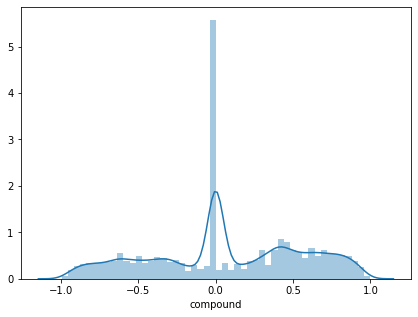

In [11]:
plt.figure(figsize=(7, 5))
ax = sns.distplot(df.compound)

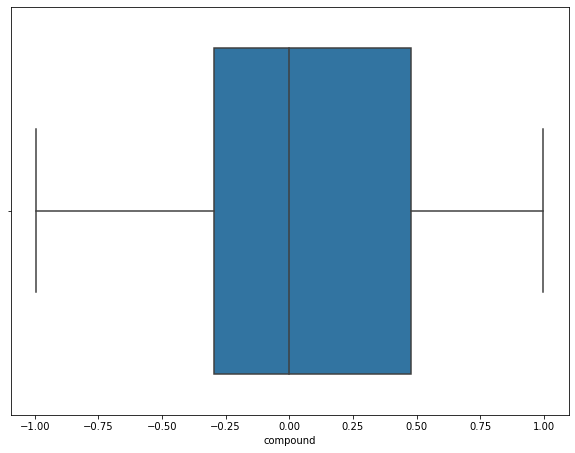

In [12]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(df.compound)

In [13]:
df.compound.describe()

count    122459.000000
mean          0.072781
std           0.493903
min          -0.994700
25%          -0.296000
50%           0.000000
75%           0.476700
max           0.997700
Name: compound, dtype: float64

In [14]:
# Check out the most negative tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound')[0:50]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


neg    neu    pos  compound  \
39949   0.601  0.383  0.015 -0.9947     
82113   0.493  0.473  0.034 -0.9921     
48341   0.412  0.529  0.060 -0.9909     
64576   0.492  0.508  0.000 -0.9905     
87546   0.472  0.528  0.000 -0.9897     
17611   0.504  0.496  0.000 -0.9896     
33755   0.457  0.513  0.030 -0.9893     
59861   0.463  0.537  0.000 -0.9869     
109987  0.691  0.309  0.000 -0.9867     
113509  0.691  0.309  0.000 -0.9867     
115793  0.630  0.370  0.000 -0.9867     
87329   0.374  0.612  0.014 -0.9865     
19384   0.457  0.464  0.079 -0.9863     
89492   0.423  0.529  0.048 -0.9862     
65581   0.471  0.529  0.000 -0.9851     
98263   0.361  0.621  0.018 -0.9849     
105414  0.479  0.486  0.036 -0.9849     
92170   0.414  0.527  0.059 -0.9845     
82573   0.307  0.667  0.026 -0.9840     
94879   0.484  0.516  0.000 -0.9836     
90492   0.468  0.532  0.000 -0.9833     
87257   0.379  0.603  0.018 -0.9824     
27334   0.532  0.468  0.000 -0.9822     
115018  0.562  0.406  0.031 -0.9820     
92131   0.339  0.615  0.045 -0.9816     
114837  0.389  0.554  0.058 -0.9815     
96787   0.420  0.580  0.000 -0.9813     
40093   0.426  0.574  0.000 -0.9808     
120689  0.387  0.557  0.057 -0.9808     
54322   0.352  0.624  0.024 -0.9804     
37034   0.405  0.550  0.045 -0.9803     
36417   0.407  0.593  0.000 -0.9801     
5681    0.347  0.653  0.000 -0.9799     
5682    0.371  0.629  0.000 -0.9799     
5683    0.377  0.623  0.000 -0.9799     
5684    0.377  0.623  0.000 -0.9799     
5685    0.356  0.644  0.000 -0.9799     
96788   0.570  0.430  0.000 -0.9796     
60130   0.319  0.681  0.000 -0.9794     
98186   0.621  0.379  0.000 -0.9789     
18204   0.421  0.579  0.000 -0.9787     
55070   0.403  0.562  0.035 -0.9783     
7269    0.407  0.567  0.026 -0.9782     
13422   0.418  0.582  0.000 -0.9779     
82758   0.418  0.582  0.000 -0.9779     
36936   0.385  0.615  0.000 -0.9777     
40997   0.375  0.625  0.000 -0.9776     
122406  0.543  0.457  0.000 -0.9776     
71433   0.565  0.435  0.000 -0.9775     
63225   0.438  0.562  0.000 -0.9774     

                                                                                                                                                                                                                                                                                                                                                                                      text  
39949   Trump referring to himself as a "Wartime President" is pathetic. COVID-19 is bad. Worse health crisis in 100 years. WHY do we Americans insist on casting every challenge as "a war"? War on drugs, war on crime, war on poverty (really war on the poor), war on terror?                                                                                                           
82113   @Amy_Siskind USA is broke and printing FAKE Money 💵 FAKE 💰, Baby Boomers are returning , their Money has been STOLEN to save WALL STREET 😱😱😱 Covid 19+ Baby Boomers = Money Saves‼️ this administration is planning kill kill kill baby boomers                                                                                                                                     
48341   I want to give my mom a hug soooooo bad! 😭\n\nShe works at a nursing home, they’ve had multiple COVID deaths, she’s almost 60, my aunt lives with us and she’s like 75.\n\nI CAN’T DEAL!\n😭😭😭😭😭😭😭😭😭😭😭😭😭 https://t.co/W0UYQG5gHu                                                                                                                                                     
64576   @deschampbelynda @JoeySalads @realDonaldTrump Did the cancer kill them? If not then they didn’t die of cancer. If those same people were shot and killed their cause of death would be listed as a gun death regardless of their cancer diagnosis. Why should Covid 19 be any different?                                                                                            
87546   @lati

In [15]:
# Check out the most positive tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound', ascending = False)[0:50]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


neg    neu    pos  compound  \
54660   0.000  0.275  0.725  0.9977     
113061  0.077  0.531  0.391  0.9959     
26532   0.148  0.430  0.422  0.9943     
118046  0.157  0.475  0.368  0.9904     
121656  0.189  0.433  0.378  0.9896     
108383  0.086  0.561  0.353  0.9892     
25522   0.028  0.493  0.480  0.9887     
111413  0.000  0.534  0.466  0.9867     
40280   0.000  0.570  0.430  0.9855     
80059   0.000  0.592  0.408  0.9854     
51470   0.000  0.576  0.424  0.9847     
122023  0.000  0.627  0.373  0.9843     
53119   0.018  0.737  0.245  0.9842     
104236  0.000  0.549  0.451  0.9840     
120446  0.000  0.573  0.427  0.9839     
29790   0.000  0.583  0.417  0.9838     
16736   0.027  0.618  0.354  0.9837     
17878   0.000  0.582  0.418  0.9832     
95023   0.000  0.547  0.453  0.9831     
8500    0.000  0.575  0.425  0.9831     
106501  0.000  0.543  0.457  0.9826     
40225   0.046  0.497  0.457  0.9825     
59922   0.093  0.584  0.323  0.9821     
88733   0.000  0.557  0.443  0.9819     
40473   0.052  0.577  0.371  0.9817     
74041   0.000  0.530  0.470  0.9812     
118333  0.000  0.322  0.678  0.9809     
119424  0.000  0.322  0.678  0.9809     
100187  0.000  0.322  0.678  0.9809     
6040    0.035  0.549  0.417  0.9808     
116130  0.000  0.590  0.410  0.9808     
106844  0.159  0.493  0.349  0.9806     
82902   0.041  0.582  0.378  0.9805     
6419    0.000  0.498  0.502  0.9803     
5659    0.055  0.360  0.585  0.9799     
45266   0.000  0.517  0.483  0.9799     
117687  0.000  0.573  0.427  0.9796     
29056   0.040  0.619  0.342  0.9794     
6764    0.000  0.614  0.386  0.9792     
92319   0.033  0.515  0.452  0.9792     
65188   0.024  0.604  0.371  0.9789     
47969   0.000  0.576  0.424  0.9786     
40906   0.000  0.552  0.448  0.9784     
92503   0.027  0.504  0.469  0.9783     
29072   0.021  0.588  0.392  0.9783     
75380   0.047  0.594  0.359  0.9783     
9348    0.050  0.579  0.371  0.9782     
105307  0.000  0.398  0.602  0.9782     
93835   0.000  0.625  0.375  0.9781     
121819  0.000  0.610  0.390  0.9779     

                                                                                                                                                                                                                                                                                                                                   text  
54660   new series starts on Sunday "Love During the Coronavirus"\n\nspoiler alert: keep loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and loving and lov                                       
113061  @briantylercohen 90k plus dead from #COVID flooding in #Michigan, locusts, murder hornets, and earthquakes... but THE MASK is what broke her 🤣🤣🤣🤣🤣🤣🤣🤣🤣 this is some HARDCORE white privilege right here. Being that inconvenienced made her cry and everything 🤣🤣🤣🤣🤣🤣                                                            
26532   @KellyannePolls covid 19 not covid 1 🤣🤣🤣🤣🤣🤣😂😂😂😂😂😂😂😂😂😂😂😂                                                                                                                                                                                                                                                                          
118046  @KamVTV BWAHAHAHAHAAAAAAAA\n\nPlease keep talking about this instead of showing strong leadership RE: Covid-19. Please do\n\nBrad Pascale's internal polling says its really working for you all 😂😂😂😂😂😂😂😂😂😂😂😂 💀💀💀💀💀💀💀💀💀                                                                                                          
121656  @RSuzanneKelly @GovMikeHuckabee whats this got to do with coronavirus, ? remind us all again what Clinton got impeached for. 😂😂😂😂😂😂😂😂😂😂😂😂😂😂                                                                                                                         

In [16]:
locations = pd.DataFrame(data['county_name'])
locations.reset_index(inplace=True)
locations

area = pd.concat([df, locations], axis=1)
area

neg    neu    pos  compound  \
0       0.000  0.822  0.178  0.3818     
1       0.000  0.896  0.104  0.2960     
2       0.000  1.000  0.000  0.0000     
3       0.000  0.848  0.152  0.7543     
4       0.081  0.839  0.081  0.0000     
...       ...    ...    ...     ...     
122454  0.033  0.940  0.026 -0.0772     
122455  0.102  0.898  0.000 -0.6868     
122456  0.104  0.795  0.101 -0.0183     
122457  0.000  0.577  0.423  0.8313     
122458  0.419  0.430  0.151 -0.5423     

                                                                                                                                                                                                                                                                                               text  \
0       "How to Protect Your Mental Health During the Coronavirus"- Emily Esfahani Smith https://t.co/mTFX8yblMp                                                                                                                                                                                      
1       #Annie #Tomorrow \n#community #singing #Covid_19 \nJoin us 8pm Thursday doorsteps\n@Clive_Harris @Annie_Osb @suffolkgiving @TimHolder11 @balletboy09 @Jochurchill4 @sarsHQ @MarkGlennMurphy @nikkijfox https://t.co/plIW1DJWxc                                                                
2       https://t.co/OYVXzv6a7K via @YouTube\nThink we found our 8pm Thursday evening choirmaster\n#Covid_19 #community #singalong\n@RobBaskind @ClareGerada @DrSdeG @alexandra_DBmed @EM_HealthPsych @AmandaCHoweRCGP @helenamckeown @medicsupport @NikkiKF @fhussain73 @ArtfulDoctor\n@MartinRCGP   
3       We now have over 400,000 Virginians covered by Medicaid. We need healthcare coverage now more than ever. The COVID-19 tests may be free but the life saving care &amp; treatment required if you have it is not. https://t.co/XPtWr5JOKt                                                      
4       Crazy to think, if not for coronavirus, we all would have been in New Orleans this past weekend watching Virginia Tech play in the Woman’s Final Four.                                                                                                                                        
...                                                                                                                                                        ...                                                                                                                                        
122454  collective shoes on the table demanding more testing and prepping for when and if they next phase of this virus happens this year.  Is Richmond and RVA healthier than think.  But by all means don't let your guard down and stay Covid defensive.                                           
122455  @FoxNewsSunday For Dr. Birx: How can we know the population percentage that is COVID-19 asymptomatic? Also, do we know that 14-day is the period within which symptoms for an asymptomatic individual will surface and after that the virus is dead and gone?                                 
122456  @DeAnna4Congress I don't think COVID would really exist as it is today...it would have been treated more like a flu ....I kid you not                                                                                                                                                         
122457  Thanks ⁦@ramsey_dude⁩ for the upgraded pitching facilities during Covid-19. Thanks for all your support! https://t.co/nVcTan3xb3                                                                                                                                                              
122458  #libertarianism is a death cult  https://t.co/R33T5nrWNH                                                                                                                                                                                                                

In [18]:
area = pd.concat([df, locations], axis=1)
area.to_pickle('overall_sentiment_COVID.pickle')
area

neg    neu    pos  compound  \
0       0.000  0.822  0.178  0.3818     
1       0.000  0.896  0.104  0.2960     
2       0.000  1.000  0.000  0.0000     
3       0.000  0.848  0.152  0.7543     
4       0.081  0.839  0.081  0.0000     
...       ...    ...    ...     ...     
122454  0.033  0.940  0.026 -0.0772     
122455  0.102  0.898  0.000 -0.6868     
122456  0.104  0.795  0.101 -0.0183     
122457  0.000  0.577  0.423  0.8313     
122458  0.419  0.430  0.151 -0.5423     

                                                                                                                                                                                                                                                                                               text  \
0       "How to Protect Your Mental Health During the Coronavirus"- Emily Esfahani Smith https://t.co/mTFX8yblMp                                                                                                                                                                                      
1       #Annie #Tomorrow \n#community #singing #Covid_19 \nJoin us 8pm Thursday doorsteps\n@Clive_Harris @Annie_Osb @suffolkgiving @TimHolder11 @balletboy09 @Jochurchill4 @sarsHQ @MarkGlennMurphy @nikkijfox https://t.co/plIW1DJWxc                                                                
2       https://t.co/OYVXzv6a7K via @YouTube\nThink we found our 8pm Thursday evening choirmaster\n#Covid_19 #community #singalong\n@RobBaskind @ClareGerada @DrSdeG @alexandra_DBmed @EM_HealthPsych @AmandaCHoweRCGP @helenamckeown @medicsupport @NikkiKF @fhussain73 @ArtfulDoctor\n@MartinRCGP   
3       We now have over 400,000 Virginians covered by Medicaid. We need healthcare coverage now more than ever. The COVID-19 tests may be free but the life saving care &amp; treatment required if you have it is not. https://t.co/XPtWr5JOKt                                                      
4       Crazy to think, if not for coronavirus, we all would have been in New Orleans this past weekend watching Virginia Tech play in the Woman’s Final Four.                                                                                                                                        
...                                                                                                                                                        ...                                                                                                                                        
122454  collective shoes on the table demanding more testing and prepping for when and if they next phase of this virus happens this year.  Is Richmond and RVA healthier than think.  But by all means don't let your guard down and stay Covid defensive.                                           
122455  @FoxNewsSunday For Dr. Birx: How can we know the population percentage that is COVID-19 asymptomatic? Also, do we know that 14-day is the period within which symptoms for an asymptomatic individual will surface and after that the virus is dead and gone?                                 
122456  @DeAnna4Congress I don't think COVID would really exist as it is today...it would have been treated more like a flu ....I kid you not                                                                                                                                                         
122457  Thanks ⁦@ramsey_dude⁩ for the upgraded pitching facilities during Covid-19. Thanks for all your support! https://t.co/nVcTan3xb3                                                                                                                                                              
122458  #libertarianism is a death cult  https://t.co/R33T5nrWNH                                                                                                                                                                                                                

In [97]:
count = area.groupby('county_name').count()
count = pd.DataFrame(count['text'])
count.reset_index(inplace = True)
count.head()

county_name   text
0  accomack county   62   
1  albemarle county  130  
2  alexandria city   11116
3  alleghany county  6    
4  amelia county     9

In [98]:
count.reset_index(drop=True, inplace = True)
count.sort_values('text')

county_name   text
58   henderson county       1    
29   covington              1    
22   charlottesville        1    
95   pitt county            1    
11   bland county           1    
9    bath county            2    
98   portsmouth             2    
127  wake county            2    
65   king and queen county  2    
24   charlottsville city    3    
73   lunenburg county       4    
30   craig county           4    
36   emporia city           5    
3    alleghany county       6    
118  southampton county     8    
25   chesapeake city        8    
4    amelia county          9    
89   norton city            10   
49   giles county           11   
34   dickenson county       12   
87   northampton county     13   
15   buchanan county        14   
67   king william county    14   
20   charles city county    14   
38   fairfax city           14   
93   patrick county         15   
81   middlesex county       15   
68   lancaster county       15   
69   lee county             16   
90   nottoway county        17   
123  surry county           17   
75   madison county         18   
84   new kent county        20   
113  russell county         26   
117  smyth county           27   
44   franklin city          27   
19   carroll county         28   
64   james city county      29   
48   galax city             32   
27   clarke county          33   
18   caroline county        34   
125  tazewell county        34   
14   brunswick county       36   
124  sussex county          36   
108  richmond county        36   
12   botetourt county       37   
61   highland county        38   
52   grayson county         43   
62   hopewell city          43   
97   poquoson city          47   
17   campbell county        51   
104  pulaski county         52   
53   greene county          53   
115  scott county           55   
111  rockbridge county      59   
35   dinwiddie county       60   
32   cumberland county      61   
0    accomack county        62   
42   floyd county           62   
46   frederick county       64   
100  powhatan county        67   
135  wythe county           69   
6    appomattox county      71   
60   henry county           76   
105  radford city           78   
51   goochland county       81   
88   northumberland county  82   
16   buckingham county      86   
50   gloucester county      90   
91   orange county          92   
96   pittsylvania county    93   
77   manassas park city     95   
80   mecklenburg county     96   
78   martinsville city      97   
28   colonial heights city  97   
116  shenandoah county      103  
79   mathews county         103  
131  westmoreland county    110  
92   page county            110  
43   fluvanna county        114  
45   franklin county        114  
5    amherst county         115  
128  warren county          120  
130  waynesboro city        124  
1    albemarle county       130  
54   halifax county         131  
83   nelson county          137  
110  roanoke county         141  
101  prince edward county   150  
72   louisa county          157  
70   lexington city         162  
106  rappahannock county    174  
119  spotsylvania county    183  
102  prince george county   188  
134  wise county            210  
94   petersburg city        224  
8    augusta county         226  
114  salem city             238  
33   danville city          265  
129  washington county      294  
66   king george county     326  
121  staunton city          330  
10   bedford county         381  
120  stafford county        434  
112  rockingham county      441  
13   bristol city           443  
41   fauquier county        449  
56   hanover county         493  
136  york county            533  
99   portsmouth city        631  
133  winchester city        679  
76   manassas city          826  
21   charlotte county       974  
74   lynchburg city         1097 
26   chesterfield county    1139 
59   henrico county         1193 
132  williamsburg city      1310 
63 

In [99]:
# Map count of counties to dataframe
location_count_dict = dict(zip(count.county_name, count.text))
location_count_dict
area['count'] = area['county_name'].map(location_count_dict)

In [100]:
location_count_dict

{'accomack county': 62,
 'albemarle county': 130,
 'alexandria city': 11116,
 'alleghany county': 6,
 'amelia county': 9,
 'amherst county': 115,
 'appomattox county': 71,
 'arlington county': 12109,
 'augusta county': 226,
 'bath county': 2,
 'bedford county': 381,
 'bland county': 1,
 'botetourt county': 37,
 'bristol city': 443,
 'brunswick county': 36,
 'buchanan county': 14,
 'buckingham county': 86,
 'campbell county': 51,
 'caroline county': 34,
 'carroll county': 28,
 'charles city county': 14,
 'charlotte county': 974,
 'charlottesville': 1,
 'charlottesville city': 6854,
 'charlottsville city': 3,
 'chesapeake city': 8,
 'chesterfield county': 1139,
 'clarke county': 33,
 'colonial heights city': 97,
 'covington': 1,
 'craig county': 4,
 'culpeper county': 2244,
 'cumberland county': 61,
 'danville city': 265,
 'dickenson county': 12,
 'dinwiddie county': 60,
 'emporia city': 5,
 'essex county': 5156,
 'fairfax city': 14,
 'fairfax county': 18548,
 'falls church city': 1683,


In [101]:
location = area.groupby('county_name')
print(location)

In [102]:
location = area.groupby('county_name').mean()
location.sort_values('compound', inplace=True)
location.reset_index(inplace=True)
location

county_name       neg       neu       pos  compound  \
0    bland county           0.181000  0.819000  0.000000 -0.624900   
1    bath county            0.081500  0.918500  0.000000 -0.271150   
2    covington              0.204000  0.643000  0.153000 -0.264800   
3    lunenburg county       0.067750  0.885500  0.047000 -0.182975   
4    franklin city          0.157778  0.775148  0.067000 -0.171448   
5    floyd county           0.120000  0.819242  0.060758 -0.159555   
6    cumberland county      0.092213  0.850000  0.057803 -0.142795   
7    russell county         0.093885  0.839000  0.067115 -0.142327   
8    richmond county        0.089333  0.838083  0.072639 -0.142308   
9    buchanan county        0.119857  0.813071  0.067143 -0.139514   
10   pittsylvania county    0.114301  0.815860  0.069806 -0.138611   
11   mecklenburg county     0.105448  0.827740  0.066833 -0.132982   
12   carroll county         0.110929  0.808893  0.080214 -0.132325   
13   giles county           0.110909  0.809091  0.079909 -0.131645   
14   amelia county          0.087778  0.825778  0.086556 -0.126456   
15   mathews county         0.078155  0.865272  0.056573 -0.120688   
16   northampton county     0.132154  0.784077  0.083769 -0.112554   
17   scott county           0.112709  0.807273  0.080036 -0.109245   
18   orange county          0.121033  0.817022  0.061924 -0.100221   
19   wythe county           0.107232  0.820188  0.072609 -0.099351   
20   franklin county        0.095842  0.832579  0.071561 -0.073161   
21   prince george county   0.093101  0.828851  0.078096 -0.056230   
22   salem city             0.099088  0.825676  0.075210 -0.053352   
23   bedford county         0.094971  0.825512  0.079520 -0.052288   
24   king george county     0.091862  0.826883  0.081285 -0.048824   
25   york county            0.103257  0.809844  0.086880 -0.047902   
26   colonial heights city  0.078639  0.854990  0.066351 -0.031126   
27   hopewell city          0.104093  0.811581  0.084349 -0.028900   
28   louisa county          0.088287  0.829987  0.081694 -0.026329   
29   wise county            0.107148  0.794443  0.098405 -0.024220   
30   fauquier county        0.091356  0.823045  0.085599 -0.022448   
31   madison county         0.075889  0.826056  0.098056 -0.019217   
32   williamsburg city      0.087626  0.834761  0.077614 -0.015783   
33   page county            0.077136  0.834664  0.088273 -0.014393   
34   emporia city           0.085000  0.834200  0.080800 -0.008540   
35   dinwiddie county       0.080117  0.843317  0.076550 -0.008498   
36   hanover county         0.088542  0.821757  0.089684 -0.000425   
37   king and queen county  0.000000  1.000000  0.000000  0.000000   
38   portsmouth             0.000000  1.000000  0.000000  0.000000   
39   charlotte county       0.083917  0.830263  0.085808  0.006874   
40   spotsylvania county    0.084727  0.827650  0.087645  0.011125   
41   newport news city      0.087519  0.822525  0.089955  0.012786   
42   rockingham county      0.083088  0.822914  0.093995  0.014649   
43   sussex county          0.058611  0.867972  0.073417  0.017494   
44   hampton city           0.081914  0.831464  0.086624  0.019709   
45   appomattox county      0.094972  0.806493  0.098535  0.020100   
46   augusta county         0.091938  0.814858  0.093177  0.023143   
47   virginia beach city    0.083855  0.822626  0.093515  0.028886   
48   northumberland county  0.071659  0.854671  0.073598  0.031738   
49   fluvanna county        0.097851  0.793693  0.108386  0.033186   
50   suffolk city           0.082694  0.822816  0.094490  0.037399   
51   portsmouth city        0.081731  0.830288  0.087981  0.039141   
52   greene county          0.071792  0.841509  0.086679  0.041989   
53   manassas park city     0.088674  0.807137  0.104211  0.042431   
54   wake county            0.031000  0.846000  0.122500  0.042900   
55   campbell county        0.075745  0.857412  0.066765  0.043194   
56   amherst county      

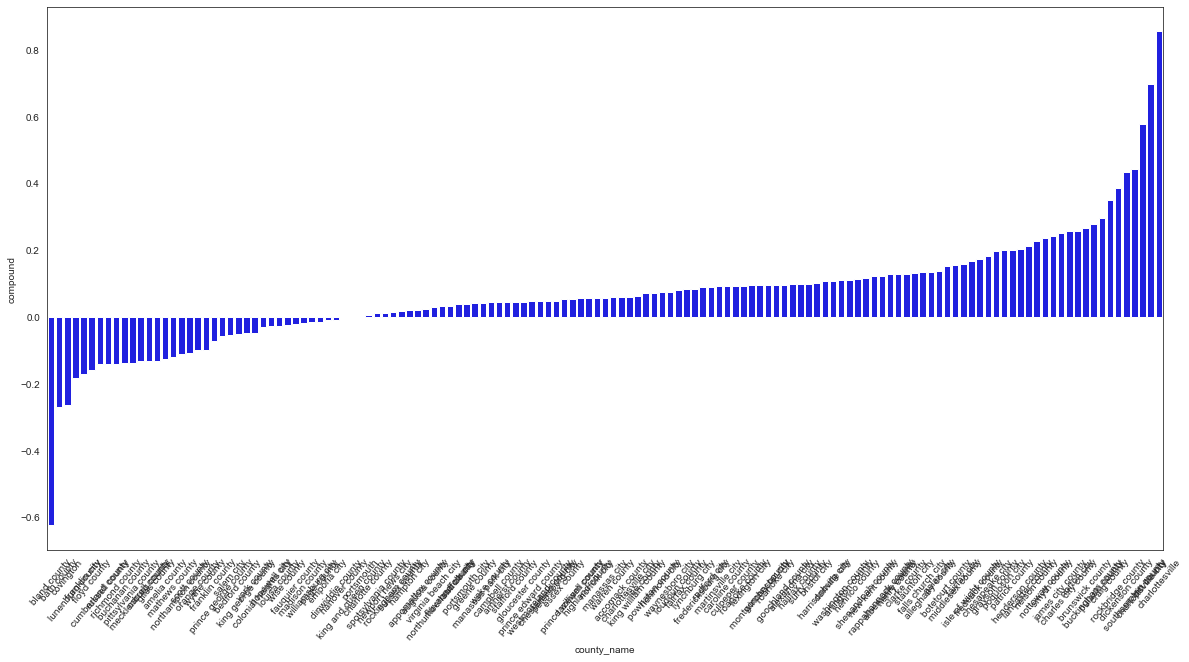

In [103]:
# Overall sentiment score by county - including all counties even with small sample sizes
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

In [104]:
location.sort_values('count', ascending=False)
location_GT20 = location[location['count']>20]
location_GT20.sort_values('compound', ascending=True)

county_name       neg       neu       pos  compound  \
4    franklin city          0.157778  0.775148  0.067000 -0.171448   
5    floyd county           0.120000  0.819242  0.060758 -0.159555   
6    cumberland county      0.092213  0.850000  0.057803 -0.142795   
7    russell county         0.093885  0.839000  0.067115 -0.142327   
8    richmond county        0.089333  0.838083  0.072639 -0.142308   
10   pittsylvania county    0.114301  0.815860  0.069806 -0.138611   
11   mecklenburg county     0.105448  0.827740  0.066833 -0.132982   
12   carroll county         0.110929  0.808893  0.080214 -0.132325   
15   mathews county         0.078155  0.865272  0.056573 -0.120688   
17   scott county           0.112709  0.807273  0.080036 -0.109245   
18   orange county          0.121033  0.817022  0.061924 -0.100221   
19   wythe county           0.107232  0.820188  0.072609 -0.099351   
20   franklin county        0.095842  0.832579  0.071561 -0.073161   
21   prince george county   0.093101  0.828851  0.078096 -0.056230   
22   salem city             0.099088  0.825676  0.075210 -0.053352   
23   bedford county         0.094971  0.825512  0.079520 -0.052288   
24   king george county     0.091862  0.826883  0.081285 -0.048824   
25   york county            0.103257  0.809844  0.086880 -0.047902   
26   colonial heights city  0.078639  0.854990  0.066351 -0.031126   
27   hopewell city          0.104093  0.811581  0.084349 -0.028900   
28   louisa county          0.088287  0.829987  0.081694 -0.026329   
29   wise county            0.107148  0.794443  0.098405 -0.024220   
30   fauquier county        0.091356  0.823045  0.085599 -0.022448   
32   williamsburg city      0.087626  0.834761  0.077614 -0.015783   
33   page county            0.077136  0.834664  0.088273 -0.014393   
35   dinwiddie county       0.080117  0.843317  0.076550 -0.008498   
36   hanover county         0.088542  0.821757  0.089684 -0.000425   
39   charlotte county       0.083917  0.830263  0.085808  0.006874   
40   spotsylvania county    0.084727  0.827650  0.087645  0.011125   
41   newport news city      0.087519  0.822525  0.089955  0.012786   
42   rockingham county      0.083088  0.822914  0.093995  0.014649   
43   sussex county          0.058611  0.867972  0.073417  0.017494   
44   hampton city           0.081914  0.831464  0.086624  0.019709   
45   appomattox county      0.094972  0.806493  0.098535  0.020100   
46   augusta county         0.091938  0.814858  0.093177  0.023143   
47   virginia beach city    0.083855  0.822626  0.093515  0.028886   
48   northumberland county  0.071659  0.854671  0.073598  0.031738   
49   fluvanna county        0.097851  0.793693  0.108386  0.033186   
50   suffolk city           0.082694  0.822816  0.094490  0.037399   
51   portsmouth city        0.081731  0.830288  0.087981  0.039141   
52   greene county          0.071792  0.841509  0.086679  0.041989   
53   manassas park city     0.088674  0.807137  0.104211  0.042431   
55   campbell county        0.075745  0.857412  0.066765  0.043194   
56   amherst county         0.080852  0.829113  0.090035  0.043651   
57   stafford county        0.074454  0.838173  0.087369  0.043980   
58   gloucester county      0.091456  0.803933  0.104600  0.044797   
59   prince edward county   0.084000  0.829393  0.086573  0.046976   
60   westmoreland county    0.071427  0.848045  0.080509  0.047260   
61   chesterfield county    0.083844  0.815560  0.100630  0.047469   
62   petersburg city        0.066116  0.854545  0.079312  0.048733   
63   essex county           0.085175  0.816854  0.097972  0.053070   
64   prince william county  0.076758  0.829011  0.094230  0.054526   
65   tazewell county        0.072529  0.836794  0.090676  0.055694   
66   highland county        0.061368  0.871316  0.067289  0.056218   
67   norfolk city           0.078776  0.826154  0.095066  0.056654   
68   manassas city          0.078768  0.825550  0.095686  0.057786   
69   warren county       

In [105]:
#location_GT20.reset_index(inplace = True) 
location_GT20.to_csv("location_GT20.csv")
location_GT20

county_name       neg       neu       pos  compound  \
4    franklin city          0.157778  0.775148  0.067000 -0.171448   
5    floyd county           0.120000  0.819242  0.060758 -0.159555   
6    cumberland county      0.092213  0.850000  0.057803 -0.142795   
7    russell county         0.093885  0.839000  0.067115 -0.142327   
8    richmond county        0.089333  0.838083  0.072639 -0.142308   
10   pittsylvania county    0.114301  0.815860  0.069806 -0.138611   
11   mecklenburg county     0.105448  0.827740  0.066833 -0.132982   
12   carroll county         0.110929  0.808893  0.080214 -0.132325   
15   mathews county         0.078155  0.865272  0.056573 -0.120688   
17   scott county           0.112709  0.807273  0.080036 -0.109245   
18   orange county          0.121033  0.817022  0.061924 -0.100221   
19   wythe county           0.107232  0.820188  0.072609 -0.099351   
20   franklin county        0.095842  0.832579  0.071561 -0.073161   
21   prince george county   0.093101  0.828851  0.078096 -0.056230   
22   salem city             0.099088  0.825676  0.075210 -0.053352   
23   bedford county         0.094971  0.825512  0.079520 -0.052288   
24   king george county     0.091862  0.826883  0.081285 -0.048824   
25   york county            0.103257  0.809844  0.086880 -0.047902   
26   colonial heights city  0.078639  0.854990  0.066351 -0.031126   
27   hopewell city          0.104093  0.811581  0.084349 -0.028900   
28   louisa county          0.088287  0.829987  0.081694 -0.026329   
29   wise county            0.107148  0.794443  0.098405 -0.024220   
30   fauquier county        0.091356  0.823045  0.085599 -0.022448   
32   williamsburg city      0.087626  0.834761  0.077614 -0.015783   
33   page county            0.077136  0.834664  0.088273 -0.014393   
35   dinwiddie county       0.080117  0.843317  0.076550 -0.008498   
36   hanover county         0.088542  0.821757  0.089684 -0.000425   
39   charlotte county       0.083917  0.830263  0.085808  0.006874   
40   spotsylvania county    0.084727  0.827650  0.087645  0.011125   
41   newport news city      0.087519  0.822525  0.089955  0.012786   
42   rockingham county      0.083088  0.822914  0.093995  0.014649   
43   sussex county          0.058611  0.867972  0.073417  0.017494   
44   hampton city           0.081914  0.831464  0.086624  0.019709   
45   appomattox county      0.094972  0.806493  0.098535  0.020100   
46   augusta county         0.091938  0.814858  0.093177  0.023143   
47   virginia beach city    0.083855  0.822626  0.093515  0.028886   
48   northumberland county  0.071659  0.854671  0.073598  0.031738   
49   fluvanna county        0.097851  0.793693  0.108386  0.033186   
50   suffolk city           0.082694  0.822816  0.094490  0.037399   
51   portsmouth city        0.081731  0.830288  0.087981  0.039141   
52   greene county          0.071792  0.841509  0.086679  0.041989   
53   manassas park city     0.088674  0.807137  0.104211  0.042431   
55   campbell county        0.075745  0.857412  0.066765  0.043194   
56   amherst county         0.080852  0.829113  0.090035  0.043651   
57   stafford county        0.074454  0.838173  0.087369  0.043980   
58   gloucester county      0.091456  0.803933  0.104600  0.044797   
59   prince edward county   0.084000  0.829393  0.086573  0.046976   
60   westmoreland county    0.071427  0.848045  0.080509  0.047260   
61   chesterfield county    0.083844  0.815560  0.100630  0.047469   
62   petersburg city        0.066116  0.854545  0.079312  0.048733   
63   essex county           0.085175  0.816854  0.097972  0.053070   
64   prince william county  0.076758  0.829011  0.094230  0.054526   
65   tazewell county        0.072529  0.836794  0.090676  0.055694   
66   highland county        0.061368  0.871316  0.067289  0.056218   
67   norfolk city           0.078776  0.826154  0.095066  0.056654   
68   manassas city          0.078768  0.825550  0.095686  0.057786   
69   warren county       

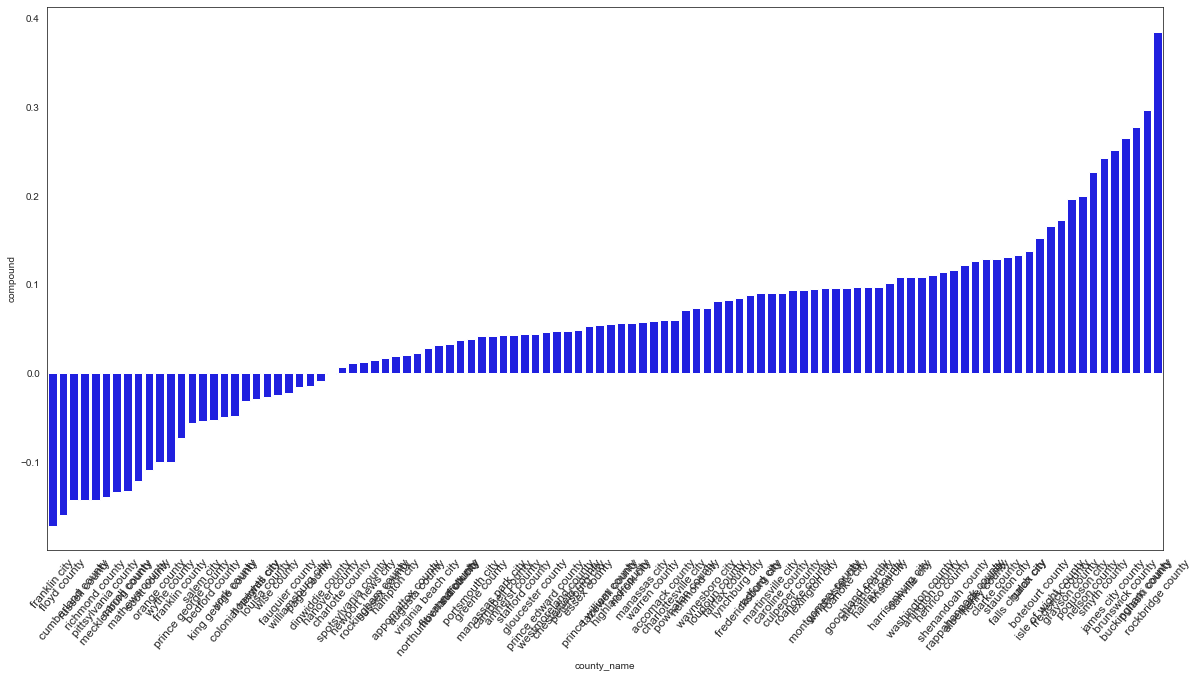

In [106]:
# Overall sentiment score by county - Removed counites with less than 20 tweets
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location_GT20, color="b")
plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.savefig("Sentiment by County - more than 20", tight_layout=False)

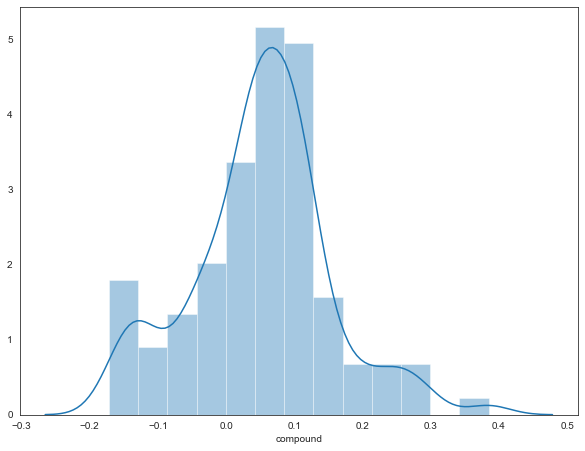

In [107]:
plt.figure(figsize=(10, 7.5))
ax = sns.distplot(location_GT20.compound)

In [108]:
location_GT20.compound.describe()

count    104.000000
mean     0.051543  
std      0.102887  
min     -0.171448  
25%     -0.002443  
50%      0.055110  
75%      0.098280  
max      0.384698  
Name: compound, dtype: float64

In [109]:
location_GT20 = location_GT20.sort_values('compound', ascending=False)
location_GT20

county_name       neg       neu       pos  compound  \
131  rockbridge county      0.050797  0.810644  0.138644  0.384698   
129  pulaski county         0.062250  0.789962  0.147808  0.296825   
128  buckingham county      0.033105  0.854709  0.112244  0.277197   
127  brunswick county       0.034528  0.855333  0.110139  0.264839   
124  james city county      0.033862  0.853069  0.113069  0.251897   
123  smyth county           0.049000  0.812667  0.138333  0.242359   
121  nelson county          0.056117  0.837504  0.106372  0.226169   
117  poquoson city          0.065340  0.812872  0.121787  0.199762   
116  grayson county         0.123744  0.716953  0.159372  0.196188   
114  frederick county       0.074047  0.813422  0.112516  0.172186   
113  isle of wight county   0.064430  0.825627  0.109938  0.165787   
110  botetourt county       0.081297  0.814595  0.104081  0.152797   
109  galax city             0.071656  0.825406  0.102906  0.137950   
107  falls church city      0.059593  0.846119  0.094279  0.133680   
106  staunton city          0.062170  0.832715  0.105118  0.131428   
105  clarke county          0.068061  0.812970  0.118970  0.129218   
104  henry county           0.046605  0.869079  0.084316  0.128517   
103  albemarle county       0.085285  0.805838  0.108915  0.126988   
102  rappahannock county    0.055034  0.846799  0.098149  0.122471   
100  shenandoah county      0.073777  0.810990  0.115252  0.116508   
99   henrico county         0.067539  0.825174  0.107277  0.114599   
98   arlington county       0.064753  0.839563  0.095681  0.110857   
97   washington county      0.064150  0.833207  0.102602  0.108879   
96   danville city          0.072230  0.822155  0.105634  0.108416   
95   harrisonburg city      0.061180  0.846320  0.092489  0.108049   
94   bristol city           0.057828  0.858819  0.083345  0.101722   
92   halifax county         0.033366  0.906046  0.060550  0.097133   
91   alexandria city        0.068628  0.835428  0.095944  0.096829   
90   goochland county       0.068173  0.821346  0.110481  0.096640   
89   roanoke city           0.067106  0.839157  0.093749  0.095906   
88   winchester city        0.063697  0.840448  0.095862  0.095504   
87   montgomery county      0.069597  0.835316  0.095089  0.095498   
86   lexington city         0.064272  0.849414  0.086321  0.095123   
85   roanoke county         0.058043  0.855865  0.086043  0.093803   
84   culpeper county        0.078012  0.818876  0.103106  0.093652   
83   caroline county        0.095529  0.802706  0.101824  0.090921   
82   martinsville city      0.072237  0.830577  0.097155  0.090829   
81   radford city           0.076205  0.832154  0.091641  0.090167   
80   fredericksburg city    0.071910  0.830521  0.097569  0.088297   
79   lynchburg city         0.068725  0.833809  0.097459  0.084742   
78   fairfax county         0.070256  0.835352  0.094390  0.082875   
77   loudoun county         0.069333  0.838098  0.092564  0.080906   
76   waynesboro city        0.067113  0.835105  0.097742  0.073612   
75   richmond city          0.073152  0.833490  0.093355  0.073014   
74   powhatan county        0.078881  0.832448  0.088687  0.070749   
71   charlottesville city   0.076447  0.828925  0.094626  0.060306   
70   accomack county        0.076419  0.833532  0.090113  0.060163   
69   warren county          0.076033  0.827583  0.096408  0.058922   
68   manassas city          0.078768  0.825550  0.095686  0.057786   
67   norfolk city           0.078776  0.826154  0.095066  0.056654   
66   highland county        0.061368  0.871316  0.067289  0.056218   
65   tazewell county        0.072529  0.836794  0.090676  0.055694   
64   prince william county  0.076758  0.829011  0.094230  0.054526   
63   essex county           0.085175  0.816854  0.097972  0.053070   
62   petersburg city        0.066116  0.854545  0.079312  0.048733   
61   chesterfield county    0.083844  0.815560  0.100630  0.047469   
60   westmoreland county 

# Pull in COVID tracking data
Recorded cases per capita

In [110]:
##### SET DAY FOR ANALYSIS #####
day_per = '2020-05-24_per'

# Cases per 1000 people
per_capita = pd.read_csv("cases_per_1000.csv") 
per_capita

Unnamed: 0           county_lower  percent_VA_pop  2020-04-07_per  \
0    0           accomack county        0.003891        0.335960         
1    1           albemarle county       0.012641        0.357294         
2    2           alexandria city        0.018601        0.805086         
3    3           alleghany county       0.001817        0.130839         
4    4           amelia county          0.001528        0.544578         
5    5           amherst county         0.003789        0.250925         
6    6           appomattox county      0.001851        0.192592         
7    7           arlington county       0.027550        1.022420         
8    8           augusta county         0.008878        0.133867         
9    9           bedford county         0.009260        0.102685         
10   10          botetourt county       0.003949        0.541810         
11   11          bristol city           0.002002        0.059372         
12   12          brunswick county       0.001981        0.060006         
13   13          buchanan county        0.002631        0.045171         
14   14          buckingham county      0.002021        0.352858         
15   15          buena vista city       0.000761        0.625098         
16   16          campbell county        0.006557        0.054377         
17   17          caroline county        0.003587        0.132521         
18   18          carroll county         0.003534        0.067254         
19   19          charles city county    0.000831        0.571837         
20   20          charlotte county       0.001438        0.082679         
21   21          charlottesville city   0.005591        0.488925         
22   22          chesapeake city        0.028266        0.336389         
23   23          chesterfield county    0.040344        0.377084         
24   24          clarke county          0.001707        0.139227         
25   25          colonial heights city  0.002091       NaN               
26   26          covington city         0.000663       NaN               
27   27          craig county           0.000608        0.391160         
28   28          culpeper county        0.005996        0.178394         
29   29          cumberland county      0.001163        0.613121         
30   30          danville city          0.004934        0.361341         
31   31          dinwiddie county       0.003364        0.035326         
32   32          emporia city           0.000640        0.371678         
33   33          essex county           0.001312       NaN               
34   34          fairfax county         0.135912        0.465227         
35   35          fairfax city           0.002836       NaN               
36   36          falls church city      0.001672       NaN               
37   37          fauquier county        0.008215        0.260436         
38   38          floyd county           0.001862       NaN               
39   39          fluvanna county        0.003124        0.342440         
40   40          franklin county        0.006683        0.195615         
41   41          franklin city          0.000976        0.487151         
42   42          frederick county       0.010121        0.504973         
43   43          fredericksburg city    0.003384        0.281007         
44   44          galax city             0.000789        0.150648         
45   45          giles county           0.001998        0.118948         
46   46          gloucester county      0.004417        0.403649         
47   47          goochland county       0.002672        0.978561         
48   48          grayson county         0.001879       NaN               
49   49          greene county          0.002307        0.206079         
50   50          greensville county     0.001386        0.428853         
51   51          halifax county         0.004134        0.057506         
52   52          hampton city           0.016114        0.317149         
53   53  

In [111]:
# County reported COVID cases per 1000 people
per_capita = pd.read_csv("cases_per_1000.csv") 
per_capita = per_capita[['county_lower',day_per]]#select just county_name and today's numbers
per_capita.columns=('county_name', day_per)
per_capita.head()

county_name  2020-05-24_per
0  accomack county   22.203897     
1  albemarle county  1.391566      
2  alexandria city   11.073129     
3  alleghany county  0.850451      
4  amelia county     1.633733

In [112]:
# Merge with Average Sentiment score as of today
per_capita_today = pd.merge(location_GT20, per_capita, on='county_name')
per_capita_today = per_capita_today[['county_name', 'compound', day_per]]
per_capita_today['State']="Virginia"
per_capita_today.rename(columns={'compound':'sentiment'}, inplace=True)
# Save Cases Per Capita Data set
per_capita_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_today.csv")

In [113]:
per_capita_today.head()

county_name  sentiment  2020-05-24_per     State
0  rockbridge county  0.384698   0.621973        Virginia
1  pulaski county     0.296825   0.292107        Virginia
2  buckingham county  0.277197   25.993884       Virginia
3  brunswick county   0.264839   1.260126        Virginia
4  james city county  0.251897   2.643184        Virginia

## SNAPSHOT -  Confirmed Cases (per 1000) as of Today & Mean Sentiment Score

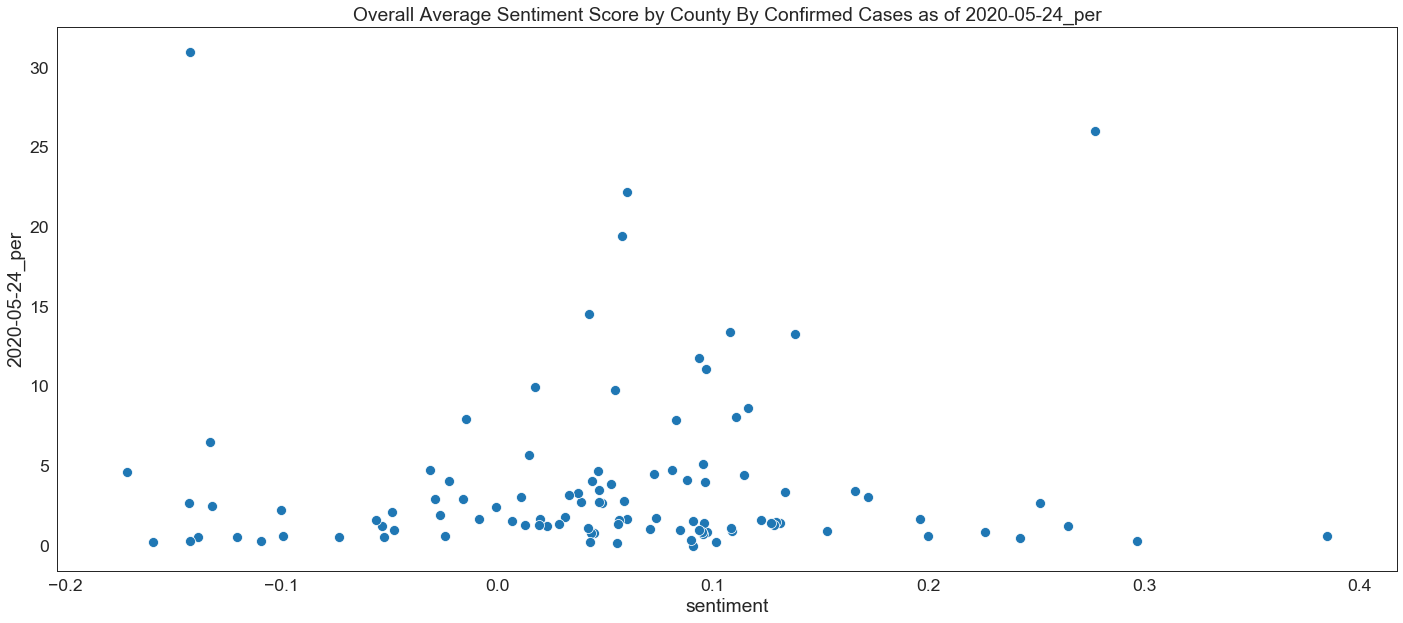

In [114]:
day = day_per
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_today).set_title(f'Overall Average Sentiment Score by County By Confirmed Cases as of {day}')

# Average sentiment score by confirmed COVID-19 cases as of today
# Does not seem to be relationship

In [115]:
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
covariance = np.cov(per_capita_today[day], per_capita_today['sentiment'])
covariance

array([[2.78206227e+01, 1.14659872e-02],
       [1.14659872e-02, 1.05857058e-02]])

In [116]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, pvalue = pearsonr(per_capita_today[day], per_capita_today['sentiment'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# Low correlation between overall sentiment and daily covid cases

p-value: 0.8314138982713359
Pearsons correlation: 0.021


## Deaths as of Today & Mean Sentiment Score

This section looks at the mean sentiment score for all of data collection against deaths by county.

In [117]:
per_capita_deaths = pd.read_csv("deaths_per_1000.csv") 
per_capita_deaths = per_capita_deaths[['county_lower', day]]#select just county_name and today's numbers
per_capita_deaths.columns=('county_name', day)
per_capita_deaths = per_capita_deaths[per_capita_deaths[day] >0]
per_capita_deaths.head()

county_name  2020-05-24_per
0  accomack county   0.335960      
1  albemarle county  0.075220      
2  alexandria city   0.242804      
3  alleghany county  0.130839      
4  amelia county     0.077797

In [118]:
per_capita_deaths_today = pd.merge(location_GT20, per_capita_deaths, on='county_name')
per_capita_deaths_today = per_capita_deaths_today[['county_name', 'compound', '2020-05-24_per']]
per_capita_deaths_today['State']="Virginia"
per_capita_deaths_today.rename(columns={'compound':'sentiment'}, inplace=True)
# Save Cases Per Capita Data set
per_capita_deaths_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_deaths_today.csv")

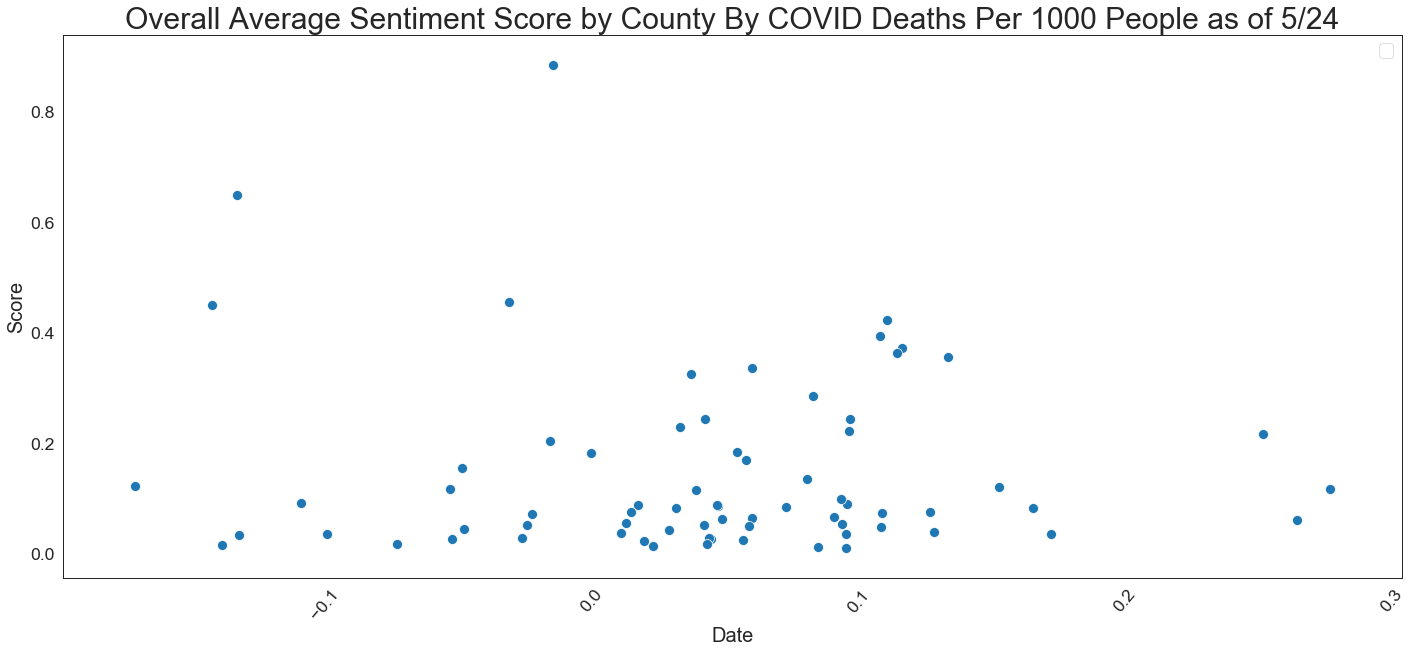

In [119]:
day = "2020-05-24_per"
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_deaths_today)
plt.title('Overall Average Sentiment Score by County By COVID Deaths Per 1000 People as of 5/24', size=30)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.xticks(rotation=50);
plt.legend()
plt.savefig("DSS-Overall", tight_layout=False)

In [120]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, pvalue = pearsonr(per_capita_deaths_today[day], per_capita_deaths_today['sentiment'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# Low correlation between overall sentiment and daily covid cases

p-value: 0.5818455950547421
Pearsons correlation: -0.066


# Daily Sentiment Data

This section creates a statewide daily sentiment file.

In [121]:
# Pull individual daily data sets from cleaned merged data
data_0407_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-07']
data_0408_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-08']
data_0409_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-09']
data_0410_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-10']
data_0411_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-11']
data_0412_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-12']
data_0413_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-13']
data_0414_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-14']
data_0415_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-15']
data_0416_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-16']
data_0417_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-17']
data_0418_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-18']
data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0420_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-20']
data_0421_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-21']
data_0422_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-22']
data_0423_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-23']
data_0424_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-24']
data_0425_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-25']
data_0426_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-26']
data_0427_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-27']
data_0428_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-28']
data_0429_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-29']
data_0430_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-30']
data_0501_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-01']
data_0502_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-02']
data_0503_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-03']
data_0504_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-04']
data_0505_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-05']
data_0506_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-06']
data_0507_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-07']
data_0508_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-08']
data_0509_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-09']
data_0510_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-10']
data_0511_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-11']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']
data_0513_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-13']
data_0514_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-14']
data_0515_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-15']
data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
data_0517_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-17']
data_0518_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-18']
data_0519_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-19']
data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']
data_0521_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-21']
data_0522_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-22']
data_0523_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-23']
data_0524_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-24']

In [122]:
# LIST OF DAILY DATA SETS TO PROCESS
dates_cleaned = [data_0407_clean, data_0408_clean, data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean, data_0515_clean, data_0516_clean, data_0517_clean, data_0518_clean,
                 data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean, data_0523_clean, data_0524_clean]

In [124]:
#create list of all texts for cleaning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
daily_score_list = [] # Create blank daily score list

# For each daily data set, process tweet sentiment
def process_daily_sentiment(data):
        
    text_body=[] #Loop through tweet to prepare for sentiment analysis
    for i in range(0,len(data)):
        temp_text=data['text'].iloc[i]
        text_body.append(temp_text)
    
    sentences = text_body # Sentiment analysis

    
    sentiment_score = [] # Append sentiment analysis results to a list
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiment_score.append(vs)
    
    daily = pd.DataFrame(sentiment_score)
    score = daily.compound.mean() #prepare mean VA sentiment score
    daily_score_list.append(score)
    return daily_score_list   

In [125]:
for date in dates_cleaned:
    process_daily_sentiment(date)

In [126]:
daily_score_list

[0.08129290259422438,
 0.07497779990044814,
 0.09063894319682962,
 0.09433393066980025,
 0.027993846153846137,
 0.04057189952904231,
 0.0775440303030305,
 0.08926342791630855,
 0.07143309859154943,
 0.07908368224835105,
 0.08898746446844791,
 0.030893802816901413,
 -0.0008534715025906754,
 0.06191160477453589,
 0.06883239481176857,
 0.07237746972594024,
 0.08098077514610887,
 0.08557537746806049,
 0.03392345085470086,
 0.05329328134373124,
 0.08605258893976786,
 0.07864968490878958,
 0.08305687186828932,
 0.08726463189049216,
 0.07515240761478152,
 0.07156012944983811,
 0.03545050167224085,
 0.07267198760170486,
 0.11489043186895016,
 0.08024297052154203,
 0.08598996124031012,
 0.08351591666666659,
 0.027271352431712203,
 0.018393147751606005,
 0.08320138248847948,
 0.0720326410658307,
 0.08340749594813625,
 0.07635117691723636,
 0.09279407526020833,
 0.0354380816034359,
 0.048858313632781675,
 0.09040583723902886,
 0.07699061674008806,
 0.06650357142857137,
 0.09607016877637146,
 0.09

In [127]:
date_labels = ['4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27',
              '4/28', '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10',
              '5/11', '5/12', '5/13', '5/14', '5/15', '5/16', '5/17', '5/18', '5/19', '5/20', '5/21', '5/22',
              '5/23', '5/24']

In [128]:
daily_sentiment_VA = pd.DataFrame(list(zip(date_labels, daily_score_list)), 
               columns =['Date', 'Sentiment_Score']) 

In [129]:
daily_sentiment_VA

Date  Sentiment_Score
0   4/7   0.081293       
1   4/8   0.074978       
2   4/9   0.090639       
3   4/10  0.094334       
4   4/11  0.027994       
5   4/12  0.040572       
6   4/13  0.077544       
7   4/14  0.089263       
8   4/15  0.071433       
9   4/16  0.079084       
10  4/17  0.088987       
11  4/18  0.030894       
12  4/19 -0.000853       
13  4/20  0.061912       
14  4/21  0.068832       
15  4/22  0.072377       
16  4/23  0.080981       
17  4/24  0.085575       
18  4/25  0.033923       
19  4/26  0.053293       
20  4/27  0.086053       
21  4/28  0.078650       
22  4/29  0.083057       
23  4/30  0.087265       
24  5/1   0.075152       
25  5/2   0.071560       
26  5/3   0.035451       
27  5/4   0.072672       
28  5/5   0.114890       
29  5/6   0.080243       
30  5/7   0.085990       
31  5/8   0.083516       
32  5/9   0.027271       
33  5/10  0.018393       
34  5/11  0.083201       
35  5/12  0.072033       
36  5/13  0.083407       
37  5/14  0.076351       
38  5/15  0.092794       
39  5/16  0.035438       
40  5/17  0.048858       
41  5/18  0.090406       
42  5/19  0.076991       
43  5/20  0.066504       
44  5/21  0.096070       
45  5/22  0.094055       
46  5/23  0.038443       
47  5/24  0.002376

In [130]:
daily_sentiment_VA.Sentiment_Score.describe()

count    48.000000
mean     0.067920 
std      0.026083 
min     -0.000853 
25%      0.052185 
50%      0.076671 
75%      0.085679 
max      0.114890 
Name: Sentiment_Score, dtype: float64

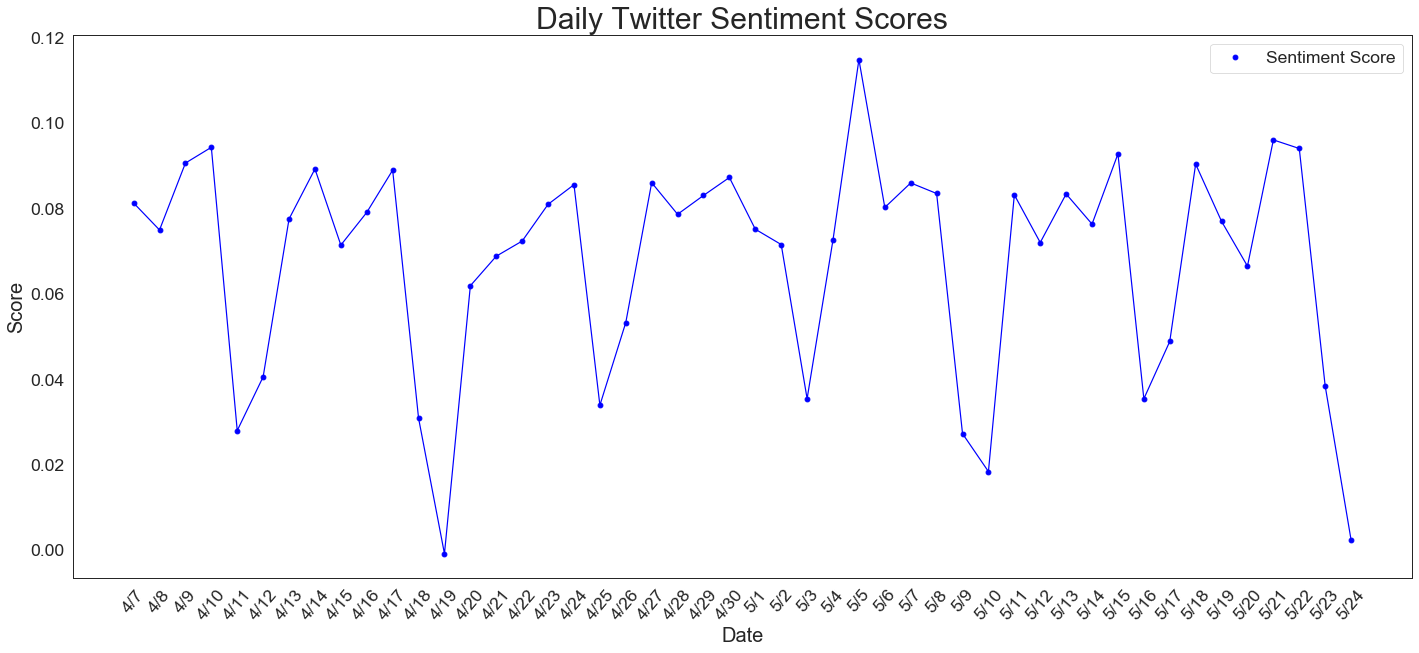

In [131]:
import matplotlib.pyplot as plt

Date = daily_sentiment_VA['Date']
Sentiment = daily_sentiment_VA['Sentiment_Score']

# "bo" is for "blue dot"
plt.plot(Date, Sentiment, 'bo', label='Sentiment Score')
plt.plot(Date, Sentiment, 'b')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Daily Twitter Sentiment Scores', size=30)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.xticks(rotation=50);
plt.legend()
plt.savefig("DSS-Overall", tight_layout=False)

plt.show()

__May 5th – Giving Tuesday Now__
The May 5th positive spike in sentiment is related to the  #GivingTuesdayNow campaign [7] – “a day of global action for giving and unity in response to COVID-19.” Removing Tweets with #GivingTuesdayNow type hashtags dropped the sentiment score to .088 in line with the .0822 weekday average. It should be noted that the #GivingTuesdayNow Tweets (and positive sentiment) were disproportionately in Arlington county, Alexandria city, and Richmond city and the bump was not seen across the rest of the state.

__Fairfax County on May 16th__ 
With an average DSS of 0.082, Fairfax County saw its lowest DSS by far on May 16th with a score of -0.045. While no single item stood out as I reviewed the data, there seemed to be a mixture of bad news for Northern Virginia’s largest suburban county that day, including:
•	Washington Post reports of largest one-day increase in nationwide death toll since outbreak began [9]
•	Washington Post reports that DC, MD, and VA saw cases double in one week [10]
•	Virginia started Phase 1 reopening plan on 5/15, though Northern Virginia was excluded due to high levels of the virus 

May 16th saw the most frequent usage of the words “death”, “deaths”, and “died”. It was also the second highest Trump referenced day of data collection.


# Statewide Daily Sentiment Score Analysis

Add day of week, type of day, day and week of data collection

In [132]:
num_days = len(daily_sentiment_VA)
print(f"Final analysis includes {num_days} days")

Final analysis includes 48 days


In [133]:
daily_sentiment_VA['dow'] = ['Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',]

daily_sentiment_VA['week'] = [1, 1, 1, 1, 1, 1, 
                              2, 2, 2, 2, 2, 2, 2, 
                              3, 3, 3, 3, 3, 3, 3, 
                              4, 4, 4, 4, 4, 4, 4,
                              5, 5, 5, 5, 5, 5, 5,
                             6, 6, 6, 6, 6, 6, 6,
                             7, 7, 7, 7, 7, 7, 7]

daily_sentiment_VA['day_type'] = ['Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',]

daily_sentiment_VA['day_type_num'] = ['1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2' ]

daily_sentiment_VA.insert(0, 'Day_of_Collection', range(1, 1 + len(daily_sentiment_VA)))

In [134]:
# Append Tweet Frequency
daily_sentiment_VA =pd.concat([date_freq_df, daily_sentiment_VA], axis=1)
daily_sentiment_VA.drop(columns='date', inplace=True)
len(daily_sentiment_VA)

48

In [66]:
# # Save daily_sentiment_VA to folder - used in Tableau
# daily_sentiment_VA.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_VA_final.csv")
# daily_sentiment_VA.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_VA_final.pkl")

In [67]:
daily_sentiment_VA = pd.read_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_VA_final.pkl")

# Tweet Frequency and Sentiment Scores
Sentiment scores and Tweet frequency drop dramatically on the weekends.

Tweet frequency and sentiment score are postivly correlated. What does this mean? 

 - Is negativity up on the weekend? 
 - Or do only the more negative people tweet on the weekend? 
 - Or does this remove all those that tweet for work?
 
 To do:
  - Re-run sentiment score with only user names that tweet on the weekends
  - Compare those who tweet on Weekends and Weekdays - are they same people?

In [68]:
Weekends = daily_sentiment_VA[daily_sentiment_VA["day_type"]=="Weekend"]
Weekdays = daily_sentiment_VA[daily_sentiment_VA["day_type"]=="Weekday"]

corr, pvalue = pearsonr(Weekends['Day_of_Collection'], Weekends['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKENDS: %.3f' % corr)

corr, pvalue = pearsonr(Weekdays['Day_of_Collection'], Weekdays['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKDAYS: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['Day_of_Collection'], daily_sentiment_VA['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - OVERALL: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['week'], daily_sentiment_VA['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Pearsons correlation of week of data collection and Sentiment Score: %.3f' % corr)


NameError: name 'pearsonr' is not defined

In [137]:
Weekdays.Sentiment_Score.describe()

count    34.000000
mean     0.082251 
std      0.010185 
min      0.061912 
25%      0.075452 
50%      0.082175 
75%      0.088557 
max      0.114890 
Name: Sentiment_Score, dtype: float64

In [138]:
Weekends.Sentiment_Score.describe()

count    14.000000
mean     0.033115 
std      0.018830 
min     -0.000853 
25%      0.027452 
50%      0.034681 
75%      0.040040 
max      0.071560 
Name: Sentiment_Score, dtype: float64

 Overall sentiment of weekday tweets seems to be improving slightly each week of data collection.
 
 At a slightly higher rate, overall sentiment of weekend tweets seems to be improving slightly each week of data collection.

In [139]:
# Correlations
corr, pvalue = pearsonr(daily_sentiment_VA['frequency'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of Tweet frequency and Sentiment Score: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['day_type_num'].astype(int), daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of Day Type and Sentiment Score: %.3f' % corr)


0.00000942662690695210
Pearsons correlation of Tweet frequency and Sentiment Score: 0.592
0.00000000000000213398
Pearsons correlation of Day Type and Sentiment Score: -0.865


Tweet frequency seems to be positivly correlated with sentiment score.

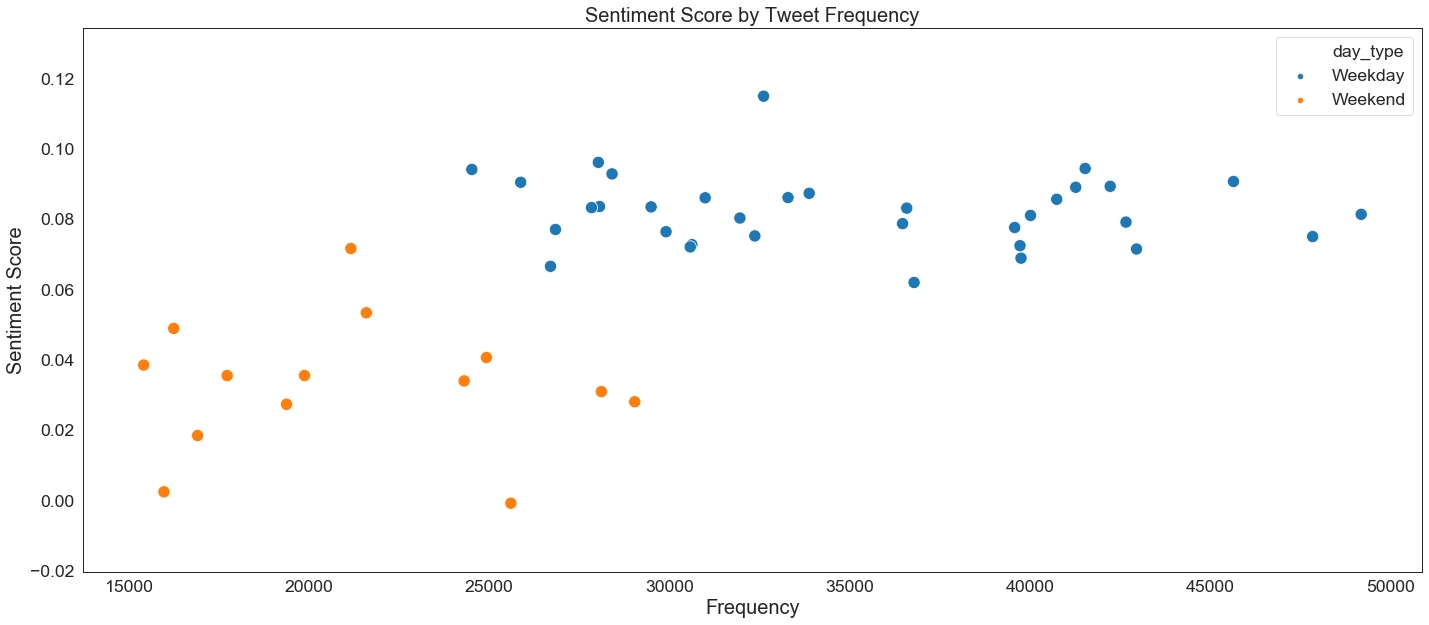

In [140]:
# Scatter plot of sentiment score by Tweet Frequency
ax = sns.scatterplot(x="frequency", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Tweet Frequency",fontsize=20)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

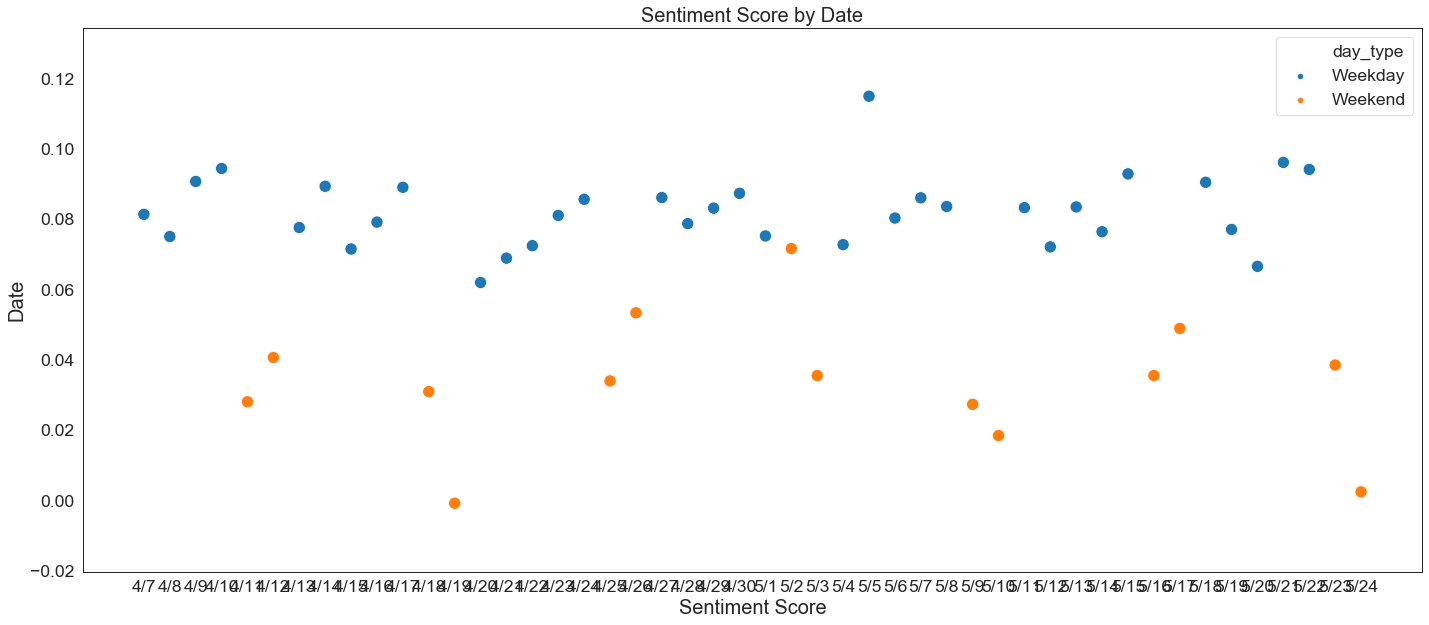

In [141]:
# Daily Sentiment Score by Date - Colored by day type
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Date",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.show()

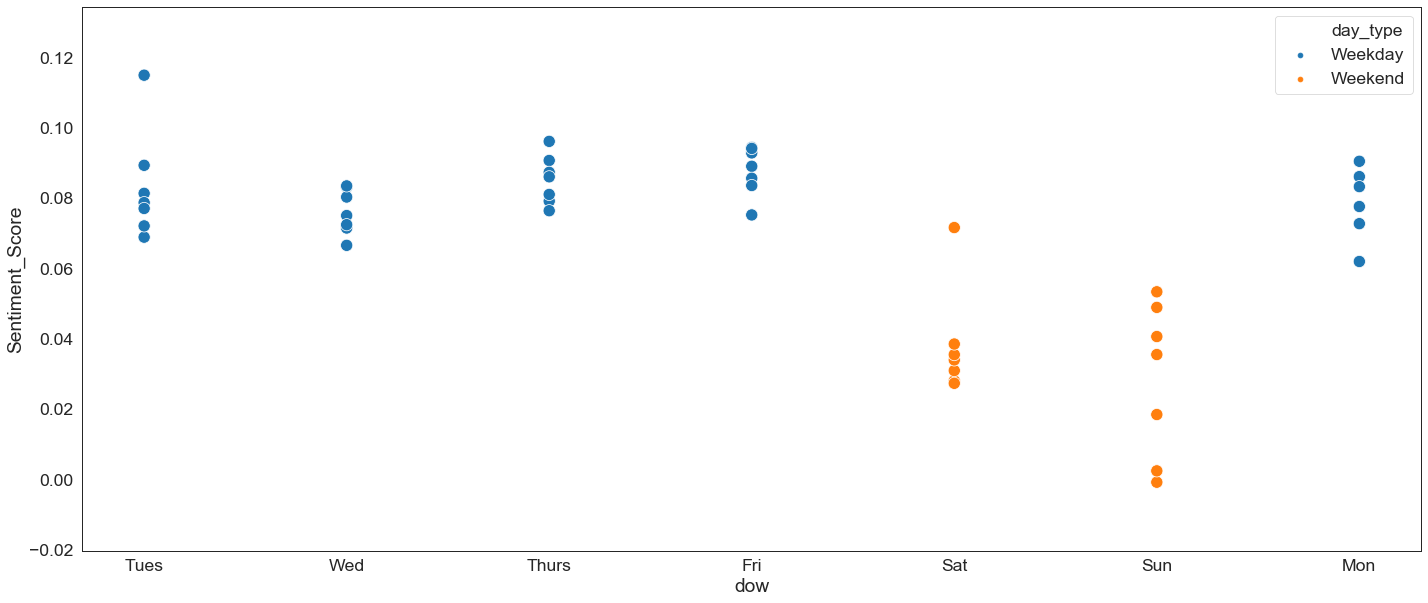

In [142]:
ax = sns.scatterplot(x="dow", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 )

In [143]:
Weekday= daily_sentiment_VA[daily_sentiment_VA['day_type']=='Weekday']
Weekend= daily_sentiment_VA[daily_sentiment_VA['day_type']=='Weekend']

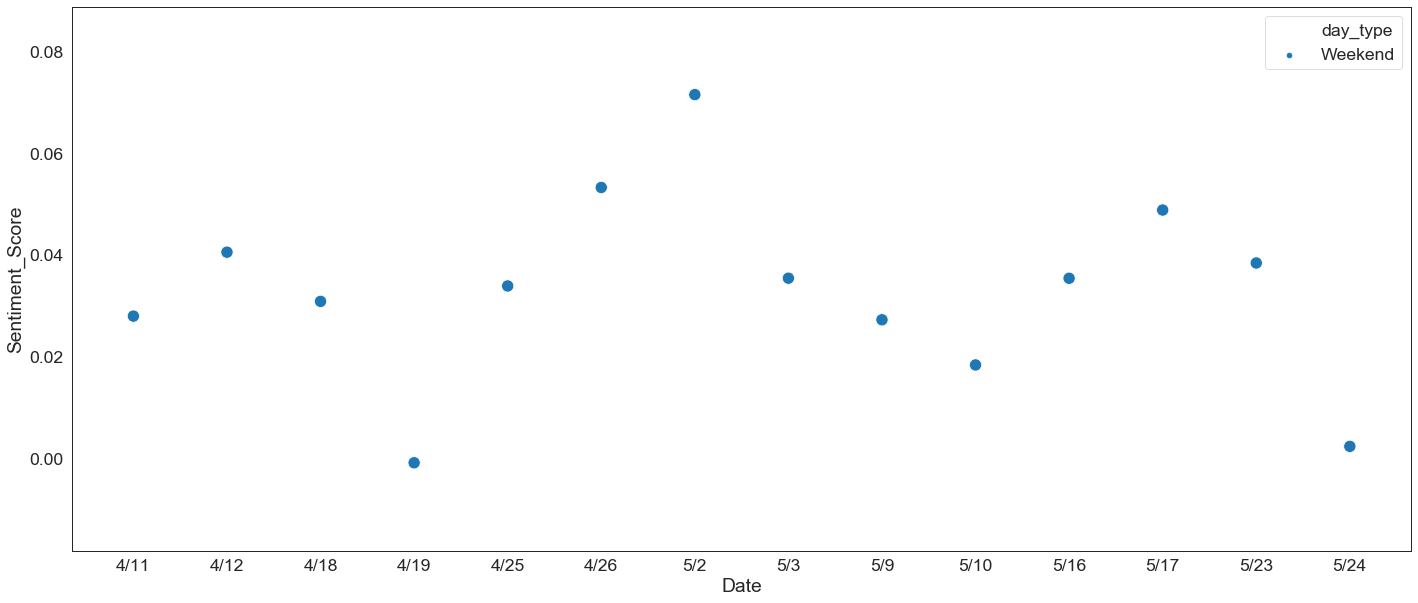

In [144]:
# Avg Weekly Sentiment Score by Percent Change
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=Weekend, s=150 )

In [145]:
# Split data by weeks for analysis
Week1= daily_sentiment_VA[daily_sentiment_VA['week']==1]
Week2= daily_sentiment_VA[daily_sentiment_VA['week']==2]
Week3= daily_sentiment_VA[daily_sentiment_VA['week']==3]
Week4= daily_sentiment_VA[daily_sentiment_VA['week']==4]

# Weekly mean sentiment score
daily_sentiment_VA.groupby('week')['Sentiment_Score'].mean()

week
1    0.068302
2    0.062336
3    0.065271
4    0.073884
5    0.068997
6    0.070298
7    0.066406
Name: Sentiment_Score, dtype: float64

In [146]:
# import matplotlib.pyplot as plt

# w1 = Week1['Sentiment_Score'].tolist()
# w2 = Week2['Sentiment_Score'].tolist()
# w3 = Week3['Sentiment_Score'].tolist()
# w4 = Week4['Sentiment_Score'].tolist()

# day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# # "bo" is for "blue dot"
# #plt.plot(day_of_week, w1, 'b', label='Week 1')
# plt.plot(day_of_week, w2, 'g', label='Week 1')
# plt.plot(day_of_week, w3, 'm', label='Week 1')
# plt.plot(day_of_week, w4, 'r', label='Week 1')
# # plt.plot('dow', 'Sentiment_Score', 'r', label='Week 2', data=Week2)
# # plt.plot('dow', 'Sentiment_Score', 'g', label='Week 3', data=Week3)
# # plt.plot('dow', 'Sentiment_Score', 'm', label='Week 4', data=Week4)

# plt.title('Sentiment Scores by week', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()

# plt.show()

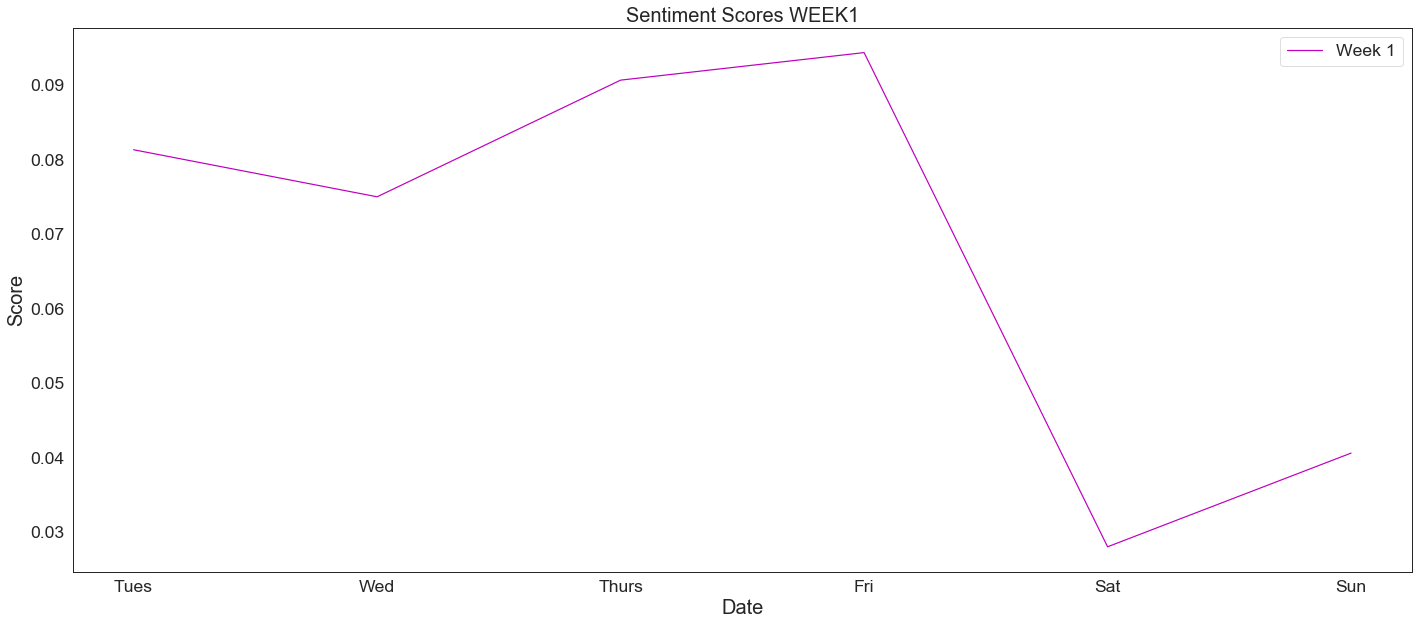

In [147]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 1', data=Week1)
plt.title('Sentiment Scores WEEK1', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

In [148]:
# plt.plot('dow', 'Sentiment_Score', 'm', label='Week 2', data=Week2)
# plt.title('Sentiment Scores WEEK 2', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()
# plt.show()

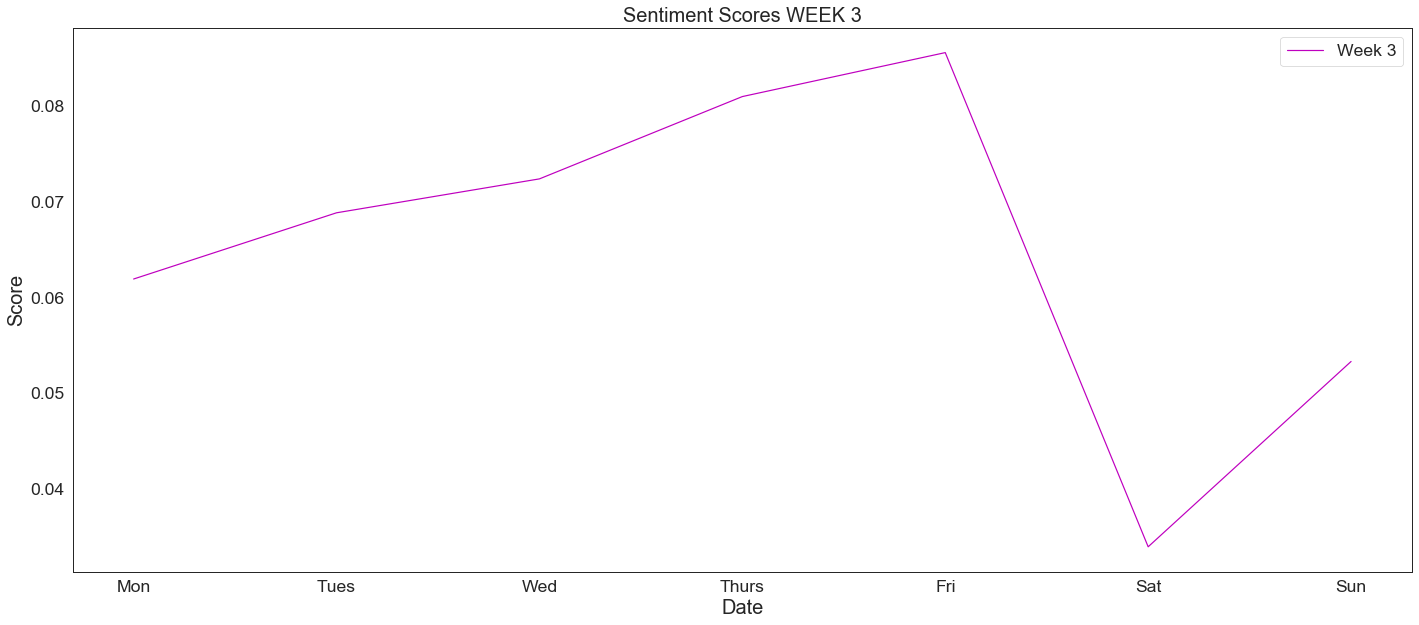

In [149]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 3', data=Week3)
plt.title('Sentiment Scores WEEK 3', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

In [150]:
# plt.plot('dow', 'Sentiment_Score', 'm', label='Week 4', data=Week4)
# plt.title('Sentiment Scores WEEK 4', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()
# plt.show()

# Statewide DSS correlation with Covid cases

In [69]:
# read in reported covid cases and deaths data
statewide_covid = pd.read_pickle("/Users/rachelmartonik/covid/statewide_covid.pkl")
statewide_covid.head

<bound method NDFrame.head of     date  Reported_Cases  date  Reported_Deaths
0   4-07  3332.0          4-07  69.0           
1   4-08  3643.0          4-08  60.0           
2   4-09  4039.0          4-09  109.0          
3   4-10  4509.0          4-10  121.0          
4   4-11  5076.0          4-11  130.0          
5   4-12  5271.0          4-12  141.0          
6   4-13  5748.0          4-13  149.0          
7   4-14  6173.0          4-14  154.0          
8   4-15  6502.0          4-15  195.0          
9   4-16  6891.0          4-16  208.0          
10  4-17  7492.0          4-17  238.0          
11  4-18  8054.0          4-18  258.0          
12  4-19  8538.0          4-19  277.0          
13  4-20  8989.0          4-20  300.0          
14  4-21  9629.0          4-21  325.0          
15  4-22  10265.0         4-22  349.0          
16  4-23  10999.0         4-23  375.0          
17  4-24  11595.0         4-24  413.0          
18  4-25  12365.0         4-25  436.0          
19  4-26  

In [70]:
#daily_sentiment_VA = pd.read_csv("daily_sentiment_VA.csv")
daily_sentiment_VA

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type  \
0   49194      1                  4/7   0.081293         Tues   1     Weekday   
1   47847      2                  4/8   0.074978         Wed    1     Weekday   
2   45651      3                  4/9   0.090639         Thurs  1     Weekday   
3   41537      4                  4/10  0.094334         Fri    1     Weekday   
4   29042      5                  4/11  0.027994         Sat    1     Weekend   
5   24927      6                  4/12  0.040572         Sun    1     Weekend   
6   39581      7                  4/13  0.077544         Mon    2     Weekday   
7   42231      8                  4/14  0.089263         Tues   2     Weekday   
8   42962      9                  4/15  0.071433         Wed    2     Weekday   
9   42669      10                 4/16  0.079084         Thurs  2     Weekday   
10  41275      11                 4/17  0.088987         Fri    2     Weekday   
11  28116      12                 4/18  0.030894         Sat    2     Weekend   
12  25605      13                 4/19 -0.000853         Sun    2     Weekend   
13  36791      14                 4/20  0.061912         Mon    3     Weekday   
14  39757      15                 4/21  0.068832         Tues   3     Weekday   
15  39729      16                 4/22  0.072377         Wed    3     Weekday   
16  40021      17                 4/23  0.080981         Thurs  3     Weekday   
17  40748      18                 4/24  0.085575         Fri    3     Weekday   
18  24309      19                 4/25  0.033923         Sat    3     Weekend   
19  21595      20                 4/26  0.053293         Sun    3     Weekend   
20  33294      21                 4/27  0.086053         Mon    4     Weekday   
21  36471      22                 4/28  0.078650         Tues   4     Weekday   
22  36587      23                 4/29  0.083057         Wed    4     Weekday   
23  33881      24                 4/30  0.087265         Thurs  4     Weekday   
24  32373      25                 5/1   0.075152         Fri    4     Weekday   
25  21167      26                 5/2   0.071560         Sat    4     Weekend   
26  19881      27                 5/3   0.035451         Sun    4     Weekend   
27  30628      28                 5/4   0.072672         Mon    5     Weekday   
28  32616      29                 5/5   0.114890         Tues   5     Weekday   
29  31959      30                 5/6   0.080243         Wed    5     Weekday   
30  30995      31                 5/7   0.085990         Thurs  5     Weekday   
31  28065      32                 5/8   0.083516         Fri    5     Weekday   
32  19382      33                 5/9   0.027271         Sat    5     Weekend   
33  16915      34                 5/10  0.018393         Sun    5     Weekend   
34  27842      35                 5/11  0.083201         Mon    6     Weekday   
35  30581      36                 5/12  0.072033         Tues   6     Weekday   
36  29496      37                 5/13  0.083407         Wed    6     Weekday   
37  29910      38                 5/14  0.076351         Thurs  6     Weekday   
38  28412      39                 5/15  0.092794         Fri    6     Weekday   
39  17735      40                 5/16  0.035438         Sat    6     Weekend   
40  16253      41                 5/17  0.048858         Sun    6     Weekend   
41  25878      42                 5/18  0.090406         Mon    7     Weekday   
42  26843      43                 5/19  0.076991         Tues   7     Weekday   
43  26704      44                 5/20  0.066504         Wed    7     Weekday   
44  28031      45                 5/21  0.096070         Thurs  7     Weekday   
45  24522      46                 5/22  0.094055         Fri    7     Weekday   
46  15421      47                 5/23  0.038443         Sat    7     Weekend   
47  15982      48                 5/24  0.002376         Sun    7     Weekend   

   day_type_num  
0   1           

In [71]:
# Combine together
statewide_covid_sent = pd.concat([daily_sentiment_VA, statewide_covid], axis=1)
statewide_covid_sent

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type  \
0   49194      1                  4/7   0.081293         Tues   1     Weekday   
1   47847      2                  4/8   0.074978         Wed    1     Weekday   
2   45651      3                  4/9   0.090639         Thurs  1     Weekday   
3   41537      4                  4/10  0.094334         Fri    1     Weekday   
4   29042      5                  4/11  0.027994         Sat    1     Weekend   
5   24927      6                  4/12  0.040572         Sun    1     Weekend   
6   39581      7                  4/13  0.077544         Mon    2     Weekday   
7   42231      8                  4/14  0.089263         Tues   2     Weekday   
8   42962      9                  4/15  0.071433         Wed    2     Weekday   
9   42669      10                 4/16  0.079084         Thurs  2     Weekday   
10  41275      11                 4/17  0.088987         Fri    2     Weekday   
11  28116      12                 4/18  0.030894         Sat    2     Weekend   
12  25605      13                 4/19 -0.000853         Sun    2     Weekend   
13  36791      14                 4/20  0.061912         Mon    3     Weekday   
14  39757      15                 4/21  0.068832         Tues   3     Weekday   
15  39729      16                 4/22  0.072377         Wed    3     Weekday   
16  40021      17                 4/23  0.080981         Thurs  3     Weekday   
17  40748      18                 4/24  0.085575         Fri    3     Weekday   
18  24309      19                 4/25  0.033923         Sat    3     Weekend   
19  21595      20                 4/26  0.053293         Sun    3     Weekend   
20  33294      21                 4/27  0.086053         Mon    4     Weekday   
21  36471      22                 4/28  0.078650         Tues   4     Weekday   
22  36587      23                 4/29  0.083057         Wed    4     Weekday   
23  33881      24                 4/30  0.087265         Thurs  4     Weekday   
24  32373      25                 5/1   0.075152         Fri    4     Weekday   
25  21167      26                 5/2   0.071560         Sat    4     Weekend   
26  19881      27                 5/3   0.035451         Sun    4     Weekend   
27  30628      28                 5/4   0.072672         Mon    5     Weekday   
28  32616      29                 5/5   0.114890         Tues   5     Weekday   
29  31959      30                 5/6   0.080243         Wed    5     Weekday   
30  30995      31                 5/7   0.085990         Thurs  5     Weekday   
31  28065      32                 5/8   0.083516         Fri    5     Weekday   
32  19382      33                 5/9   0.027271         Sat    5     Weekend   
33  16915      34                 5/10  0.018393         Sun    5     Weekend   
34  27842      35                 5/11  0.083201         Mon    6     Weekday   
35  30581      36                 5/12  0.072033         Tues   6     Weekday   
36  29496      37                 5/13  0.083407         Wed    6     Weekday   
37  29910      38                 5/14  0.076351         Thurs  6     Weekday   
38  28412      39                 5/15  0.092794         Fri    6     Weekday   
39  17735      40                 5/16  0.035438         Sat    6     Weekend   
40  16253      41                 5/17  0.048858         Sun    6     Weekend   
41  25878      42                 5/18  0.090406         Mon    7     Weekday   
42  26843      43                 5/19  0.076991         Tues   7     Weekday   
43  26704      44                 5/20  0.066504         Wed    7     Weekday   
44  28031      45                 5/21  0.096070         Thurs  7     Weekday   
45  24522      46                 5/22  0.094055         Fri    7     Weekday   
46  15421      47                 5/23  0.038443         Sat    7     Weekend   
47  15982      48                 5/24  0.002376         Sun    7     Weekend   

   day_type_num  date  Reported_Ca

In [72]:
statewide_covid_sent["pct_change_cases"]= statewide_covid_sent["Reported_Cases"].pct_change()
statewide_covid_sent["pct_change_deaths"]= statewide_covid_sent["Reported_Deaths"].pct_change()

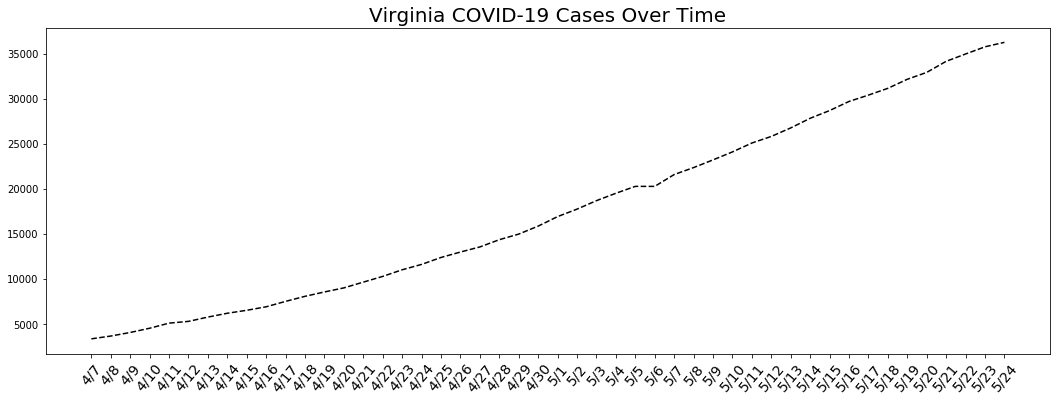

In [73]:
# Plot Reported Cases and Death Over Time
plt.figure(figsize=(18, 6))
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Cases'], '--', label = ' pct_change_cases', color='black')
#plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Deaths'], '-', label = ' pct_change_cases', color='black')

plt.xticks(rotation=50, size=14);
plt.title('Virginia COVID-19 Cases Over Time', size=20)

#plt.legend()
plt.savefig('Covid Cases Over time', tight_layout=False)


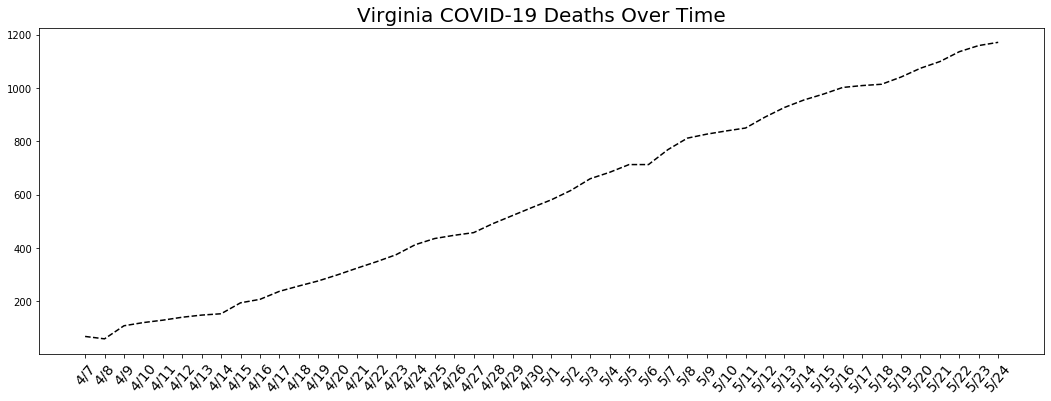

In [74]:
# Plot Reported Cases and Death Over Time
plt.figure(figsize=(18, 6))
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Deaths'], '--', label = ' pct_change_cases', color='black')
#plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Deaths'], '-', label = ' pct_change_cases', color='black')

plt.xticks(rotation=50, size=14);
plt.title('Virginia COVID-19 Deaths Over Time', size=20)

#plt.legend()
plt.savefig('Covid DEATHS time', tight_layout=False)


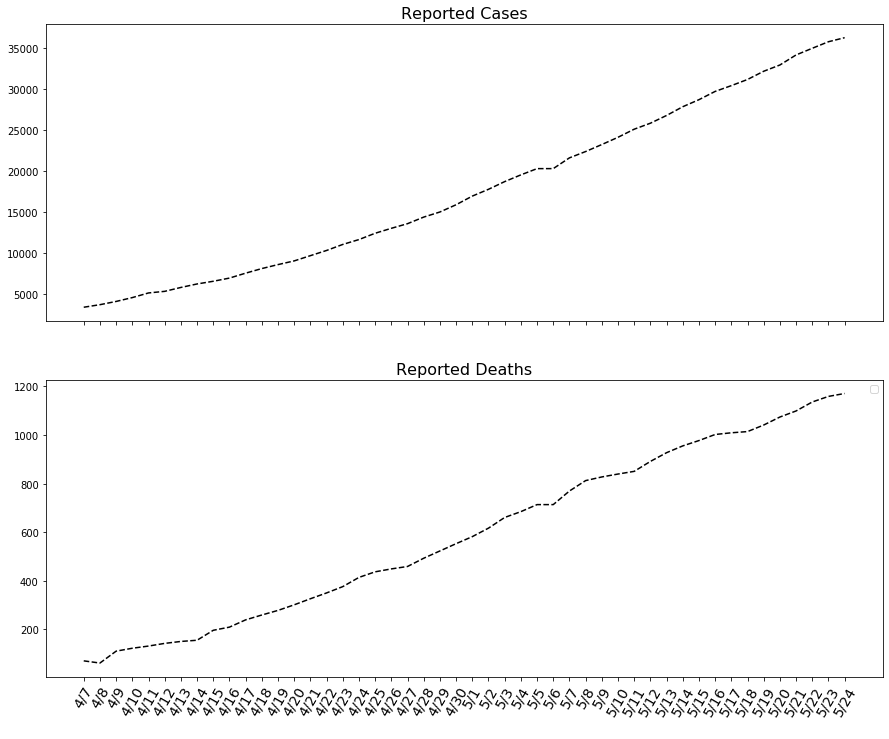

In [80]:
# Plot Regional DSS Overtime
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(15,12))
ax1.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Cases'], '--',  color='black')
ax1.set_title('Reported Cases', size=16)
ax2.plot(statewide_covid_sent['Date'], statewide_covid_sent['Reported_Deaths'], '--',  color='black')
ax2.set_title('Reported Deaths', size=16)

plt.xlabel(' '); plt.xticks(rotation=60, size=14)

plt.legend()
plt.savefig('Cases_Deaths_overtime', tight_layout=False)


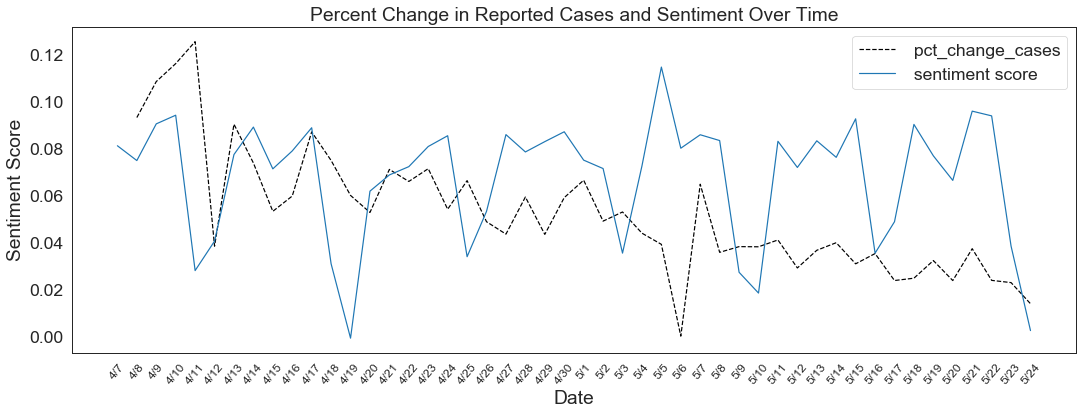

In [155]:
# Plot Reported Cases Over Time
plt.figure(figsize=(18, 6))
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['pct_change_cases'], '--', label = ' pct_change_cases', color='black')
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Sentiment_Score'], '-', label = ' sentiment score')
#plt.plot(data_merged['date_y'], data_merged["freq_div_200"], 'b', label = ' sentiment score', color='tab:green')
#ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])
plt.xlabel('Date'); plt.xticks(rotation=50, size=12);
plt.ylabel('Sentiment Score'); plt.title('Percent Change in Reported Cases and Sentiment Over Time')

plt.legend()
plt.savefig('Percent Change Case by DSS', tight_layout=False)


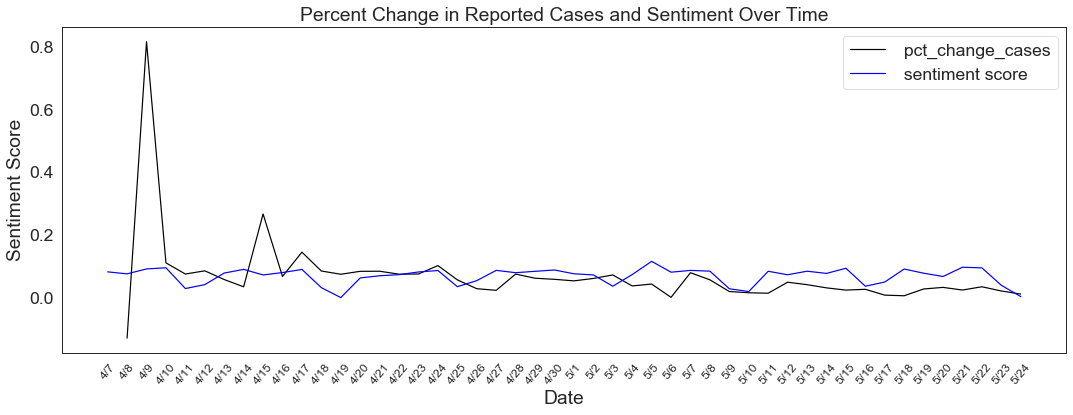

In [156]:
# Plot Reported Cases Over Time
plt.figure(figsize=(18, 6))
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['pct_change_deaths'], 'b-', label = ' pct_change_cases', color='black')
plt.plot(statewide_covid_sent['Date'], statewide_covid_sent['Sentiment_Score'], 'b-', label = ' sentiment score')
#plt.plot(data_merged['date_y'], data_merged["freq_div_200"], 'b', label = ' sentiment score', color='tab:green')
#ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])
plt.xlabel('Date'); plt.xticks(rotation=50, size=12);
plt.ylabel('Sentiment Score'); plt.title('Percent Change in Reported Cases and Sentiment Over Time')
plt.savefig('Percent Change Case by DSS', tight_layout=False)
plt.legend();


In [157]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent['Reported_Cases'], statewide_covid_sent['Sentiment_Score'])
print(pvalue)
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
corr, pvalue = pearsonr(statewide_covid_sent['Reported_Deaths'], statewide_covid_sent['Sentiment_Score'])
print(pvalue)
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)

0.7233746650208935
Pearsons correlation of reported cases and Sentiment Score: -0.052
0.7428033395597164
Pearsons correlation of reported deaths and Sentiment Score: -0.049


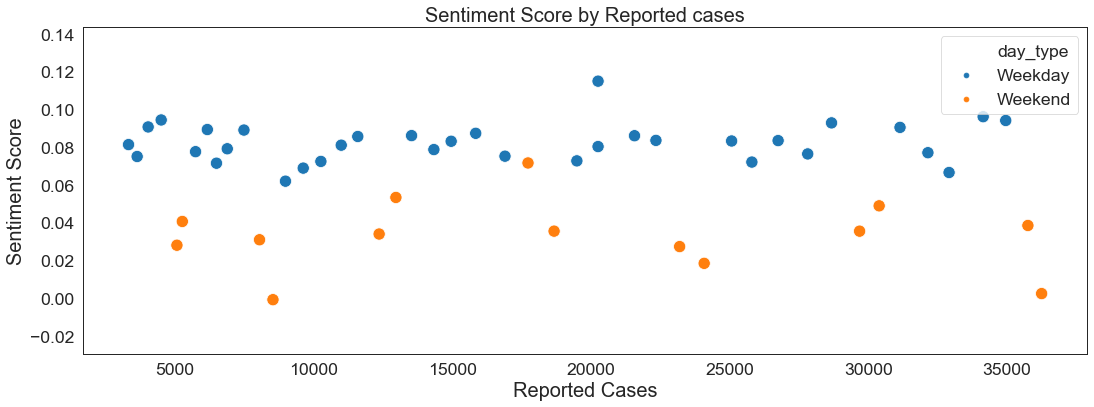

In [158]:
# Scatter plot of sentiment score by reported cases
plt.figure(figsize=(18, 6))
ax = sns.scatterplot(x="Reported_Cases", y="Sentiment_Score", hue="day_type",
                     data=statewide_covid_sent, s=150 ).set_title("Sentiment Score by Reported cases",fontsize=20)
plt.xlabel("Reported Cases", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

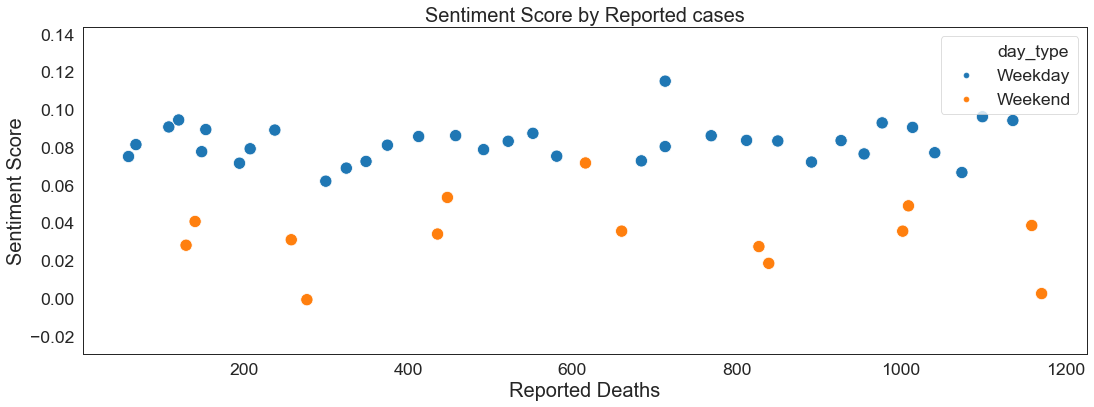

In [159]:
# Scatter plot of sentiment score by reported deaths
plt.figure(figsize=(18, 6))
ax = sns.scatterplot(x="Reported_Deaths", y="Sentiment_Score", hue="day_type",
                     data=statewide_covid_sent, s=150 ).set_title("Sentiment Score by Reported cases",fontsize=20)
plt.xlabel("Reported Deaths", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

In [160]:
# Create percent change of reported cases and deaths
a = statewide_covid_sent.groupby('week',sort=False).apply(lambda x: (x['Reported_Cases'].values[-1] - x['Reported_Cases'].values[0]) / x['Reported_Cases'].values[-1] * 100)\
    .reset_index(name='pct_change_cases')
a

week  pct_change_cases
0  1     36.786189       
1  2     32.677442       
2  3     30.688565       
3  4     27.513256       
4  5     19.056518       
5  6     17.500329       
6  7     14.082331

In [161]:
b = statewide_covid_sent.groupby('week',sort=False).apply(lambda x: (x['Reported_Deaths'].values[-1] - x['Reported_Deaths'].values[0]) / x['Reported_Deaths'].values[-1] * 100)\
    .reset_index(name='pct_change_deaths')
b

week  pct_change_deaths
0  1     51.063830        
1  2     46.209386        
2  3     33.035714        
3  4     30.606061        
4  5     18.474374        
5  6     15.758176        
6  7     13.407344

In [162]:
c = statewide_covid_sent.groupby('week')['Sentiment_Score'].mean().reset_index(name='avg_weekly_sent')
c

week  avg_weekly_sent
0  1     0.068302       
1  2     0.062336       
2  3     0.065271       
3  4     0.073884       
4  5     0.068997       
5  6     0.070298       
6  7     0.066406

In [163]:
statewide_covid_sent_weekly = pd.concat([a, b, c], axis=1)
statewide_covid_sent_weekly

week  pct_change_cases  week  pct_change_deaths  week  avg_weekly_sent
0  1     36.786189         1     51.063830          1     0.068302       
1  2     32.677442         2     46.209386          2     0.062336       
2  3     30.688565         3     33.035714          3     0.065271       
3  4     27.513256         4     30.606061          4     0.073884       
4  5     19.056518         5     18.474374          5     0.068997       
5  6     17.500329         6     15.758176          6     0.070298       
6  7     14.082331         7     13.407344          7     0.066406

In [164]:
# drop to first six weeks
statewide_covid_sent_weekly_six = statewide_covid_sent_weekly.copy()
statewide_covid_sent_weekly_six.drop(statewide_covid_sent_weekly_six.tail(1).index,inplace=True)
statewide_covid_sent_weekly_six

week  pct_change_cases  week  pct_change_deaths  week  avg_weekly_sent
0  1     36.786189         1     51.063830          1     0.068302       
1  2     32.677442         2     46.209386          2     0.062336       
2  3     30.688565         3     33.035714          3     0.065271       
3  4     27.513256         4     30.606061          4     0.073884       
4  5     19.056518         5     18.474374          5     0.068997       
5  6     17.500329         6     15.758176          6     0.070298

In [165]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent_weekly_six['pct_change_cases'], statewide_covid_sent_weekly_six['avg_weekly_sent'])
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")
corr, pvalue = pearsonr(statewide_covid_sent_weekly_six['pct_change_deaths'], statewide_covid_sent_weekly_six['avg_weekly_sent'])
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")

Pearsons correlation of reported cases and Sentiment Score: -0.432
p-value: 0.3925431206502197
Pearsons correlation of reported deaths and Sentiment Score: -0.481
p-value: 0.3345526102331032


In [166]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent_weekly['pct_change_cases'], statewide_covid_sent_weekly['avg_weekly_sent'])
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")
corr, pvalue = pearsonr(statewide_covid_sent_weekly['pct_change_deaths'], statewide_covid_sent_weekly['avg_weekly_sent'])
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")

Pearsons correlation of reported cases and Sentiment Score: -0.240
p-value: 0.6040497440505164
Pearsons correlation of reported deaths and Sentiment Score: -0.326
p-value: 0.4761127772552766


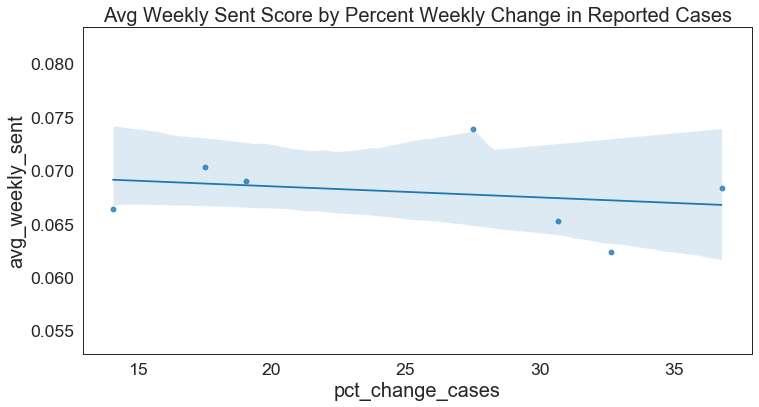

In [167]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="pct_change_cases", y="avg_weekly_sent",
                     data=statewide_covid_sent_weekly).set_title("Avg Weekly Sent Score by Percent Weekly Change in Reported Cases",fontsize=20)
plt.xlabel("pct_change_cases", fontsize=20)
plt.ylabel("avg_weekly_sent", fontsize=20)
plt.show()

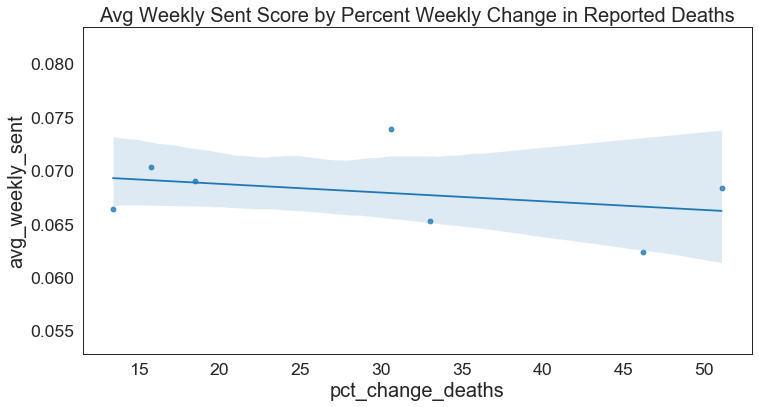

In [168]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="pct_change_deaths", y="avg_weekly_sent",
                     data=statewide_covid_sent_weekly).set_title("Avg Weekly Sent Score by Percent Weekly Change in Reported Deaths",fontsize=20)
plt.xlabel("pct_change_deaths", fontsize=20)
plt.ylabel("avg_weekly_sent", fontsize=20)
plt.show()

# Daily Sentiment Score By County

Use the code below to run through each cleaned daily data set (i.e data_0407_clean). The code takes the Tweet and provides a sentiment score. Then I appened county to each data set (not all counties have Tweets each day), and ran the mean sentiment score for that day by county. At the end, I compiled the daily scores into a data frame with all counties.

Code has been commented out because it only needs to be run once for each day of data.

In [169]:
# # Run through each daily data set separetly to get county level sentiment score
# data = data_0524_clean
# day = '05-24'

# text_body=[] #Loop through tweet to prepare for sentiment analysis
# sentiment_score = [] # Append sentiment analysis results to a list
# for i in range(0,len(data)):
#     temp_text=data['text'].iloc[i]
#     text_body.append(temp_text)
    
# sentences = text_body # Sentiment analysis
   
# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
#     sentiment_score.append(vs)

# # Create data frame of county names
# locations = pd.DataFrame(data['county_name'])
# locations.reset_index(inplace=True)
# #locations

In [170]:
# # append sentiment with county name
# a = pd.DataFrame(sentiment_score)
# b = pd.concat([a, locations], axis=1)
# print (len(a))
# print (len(b))
# print (len(data))

In [171]:
# len(b.county_name.value_counts())

In [172]:
# c = pd.DataFrame(b.groupby('county_name')['compound'].mean())
# c.reset_index(inplace=True)
# c.columns=['county_name', day]
# sent_0524 = c
# sent_0524.to_pickle("sent_0524.pkl") # save the file


# COVID Tracking Data

In a separate notebook, I pull daily Covid data for confirmed number of cases and deaths for Virginia. I added population data from ACS, normalizing the number of cases and deaths by every 1000 county/city resident.

In [173]:
cases = pd.read_csv("cases_per_1000.csv") 
cases.drop(columns=['Unnamed: 0'], inplace=True)
deaths = pd.read_csv("deaths_per_1000.csv") 
deaths.drop(columns=['Unnamed: 0'], inplace=True)
#cases.rename(columns={'county_lower':'county_name'}, inplace=True)
#deaths.rename(columns={'county_lower':'county_name'}, inplace=True)

In [174]:
name_change_dict = {"county_lower": "county_name",
                    "2020-04-07_per": "04-07",
                    "2020-04-08_per": "04-08",
                    "2020-04-09_per": "04-09",
                    "2020-04-10_per": "04-10",
                    "2020-04-11_per": "04-11",
                    "2020-04-12_per": "04-12",
                    "2020-04-13_per": "04-13",
                    "2020-04-14_per": "04-14",
                    "2020-04-15_per": "04-15",
                    "2020-04-16_per": "04-16",
                    "2020-04-17_per": "04-17",
                    "2020-04-18_per": "04-18",
                    "2020-04-19_per": "04-19",
                    "2020-04-20_per": "04-20",
                    "2020-04-21_per": "04-21",
                    "2020-04-22_per": "04-22",
                    "2020-04-23_per": "04-23",
                    "2020-04-24_per": "04-24",
                    "2020-04-25_per": "04-25",
                    "2020-04-26_per": "04-26",
                    "2020-04-27_per": "04-27",
                    "2020-04-28_per": "04-28",
                    "2020-04-29_per": "04-29",
                    "2020-04-30_per": "04-30",
                    "2020-05-01_per": "05-01",
                    "2020-05-02_per": "05-02",
                    "2020-05-03_per": "05-03",
                    "2020-05-04_per": "05-04",
                    "2020-05-05_per": "05-05",
                    "2020-05-06_per": "05-06",
                    "2020-05-07_per": "05-07",
                    "2020-05-08_per": "05-08", 
                    "2020-05-09_per": "05-09", 
                    "2020-05-10_per": "05-10", 
                    "2020-05-11_per": "05-11", 
                    "2020-05-12_per": "05-12", 
                    "2020-05-13_per": "05-13", 
                    "2020-05-14_per": "05-14", 
                    "2020-05-15_per": "05-15", 
                    "2020-05-16_per": "05-16", 
                    "2020-05-17_per": "05-17", 
                    "2020-05-18_per": "05-18", 
                    "2020-05-19_per": "05-19", 
                    "2020-05-20_per": "05-20", 
                    "2020-05-21_per": "05-21", 
                    "2020-05-22_per": "05-22", 
                    "2020-05-23_per": "05-23", 
                    "2020-05-24_per": "05-24", 
                   }

cases.rename(columns=name_change_dict, inplace=True)
deaths.rename(columns=name_change_dict, inplace=True)

In [175]:
deaths.head()

county_name  percent_VA_pop    04-07    04-08    04-09    04-10  \
0  accomack county   0.003891        0.00000  0.00000  0.00000  0.00000   
1  albemarle county  0.012641        0.00000  0.00000  0.00000  0.00000   
2  alexandria city   0.018601        0.00639  0.00639  0.00639  0.00639   
3  alleghany county  0.001817        0.00000  0.00000  0.00000  0.00000   
4  amelia county     0.001528        0.00000  0.00000  0.00000  0.00000   

     04-11    04-12    04-13    04-14  ...     05-15     05-16     05-17  \
0  0.00000  0.00000  0.00000  0.00000  ...  0.274876  0.274876  0.274876   
1  0.00000  0.00000  0.00000  0.00000  ...  0.037610  0.037610  0.037610   
2  0.00639  0.00639  0.00639  0.00639  ...  0.204466  0.217245  0.217245   
3  0.00000  0.00000  0.00000  0.00000  ...  0.000000  0.000000  0.000000   
4  0.00000  0.00000  0.00000  0.00000  ...  0.077797  0.077797  0.077797   

      05-18     05-19     05-20     05-21     05-22     05-23     05-24  
0  0.274876  0.274876  0.335960  0.335960  0.335960  0.335960  0.335960  
1  0.037610  0.037610  0.037610  0.037610  0.037610  0.047012  0.075220  
2  0.217245  0.217245  0.217245  0.236414  0.236414  0.242804  0.242804  
3  0.000000  0.000000  0.000000  0.000000  0.130839  0.130839  0.130839  
4  0.077797  0.077797  0.077797  0.077797  0.077797  0.077797  0.077797  

[5 rows x 50 columns]

In [176]:
# Create separate dataframe of percent of US VA population
percent_VA_population = cases[['county_name', 'percent_VA_pop']]
percent_VA_population.head()
len(percent_VA_population)

133

In [177]:
# Drop percent of population from cases and deaths
cases = cases.drop(columns='percent_VA_pop')
deaths = deaths.drop(columns='percent_VA_pop')

In [178]:
# Create wide COVID cases and deaths data

cases_wide = pd.melt(cases, id_vars=['county_name'])
deaths_wide = pd.melt(deaths, id_vars=['county_name'])
cases_wide.columns=['county_name', 'date', 'cases_per_1000']
deaths_wide.columns=['county_name', 'date', 'deahts_per_1000']

In [179]:
# Save wide COVID case to file - used in Tableau
cases_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/cases_wide.csv")
deaths_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/deaths_wide.csv")

In [180]:
cases_wide.head()

county_name   date  cases_per_1000
0  accomack county   04-07  0.335960      
1  albemarle county  04-07  0.357294      
2  alexandria city   04-07  0.805086      
3  alleghany county  04-07  0.130839      
4  amelia county     04-07  0.544578

In [181]:
cases_wide['cases_per_1000'].describe()

count    6260.000000
mean     1.681073   
std      2.942274   
min      0.000000   
25%      0.380097   
50%      0.772798   
75%      1.648946   
max      31.088083  
Name: cases_per_1000, dtype: float64

## County/City Checks

VA has 133 total counties/cities included in ACS data. As of 5/2 (Data as of 4/30), the following discrepancies exist:

Counties in Twitter data but not COVID data:
 - Martinsville city
 - Dickenson county
 - Bland county
 - Bath county

Counites in Covid data but not in Twitter data:
 - Buena Vista city
 - Chesapeake city
 - Covington city
 - Greensville county

In [182]:
# How many unique county/cities do we have in entire merged data?
county_list = merged_cleaned_data['county_name'].value_counts()
Twitter_counties = pd.DataFrame(county_list)
Twitter_counties.reset_index(inplace=True)
Twitter_counties= Twitter_counties['index']
Twitter_counties = pd.DataFrame(Twitter_counties)
Twitter_counties.columns=['county_name']
Twitter_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/Twitter_counties.csv")

In [183]:
#Twitter_counties

In [184]:
covid_counties = pd.DataFrame(cases.county_name)
covid_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/covid_counties.csv")

In [185]:
county_check = pd.merge(covid_counties, Twitter_counties, on='county_name')
#county_check

## Daily Sentiment Score Data Frame

For now, we will include counites/cities included in both the Twitter data and the COVID data as we are trying to compare the two. Will reassess later on in course.

In [186]:
# Read in data
sent_0407 = pd.read_pickle('sent_0407.pkl')
sent_0408 = pd.read_pickle('sent_0408.pkl')
sent_0409 = pd.read_pickle('sent_0409.pkl')
sent_0410 = pd.read_pickle('sent_0410.pkl')
sent_0411 = pd.read_pickle('sent_0411.pkl')
sent_0412 = pd.read_pickle('sent_0412.pkl')
sent_0413 = pd.read_pickle('sent_0413.pkl')
sent_0414 = pd.read_pickle('sent_0414.pkl')
sent_0415 = pd.read_pickle('sent_0415.pkl')
sent_0416 = pd.read_pickle('sent_0416.pkl')
sent_0417 = pd.read_pickle('sent_0417.pkl')
sent_0418 = pd.read_pickle('sent_0418.pkl')
sent_0419 = pd.read_pickle('sent_0419.pkl')
sent_0420 = pd.read_pickle('sent_0420.pkl')
sent_0421 = pd.read_pickle('sent_0421.pkl')
sent_0422 = pd.read_pickle('sent_0422.pkl')
sent_0423 = pd.read_pickle('sent_0423.pkl')
sent_0424 = pd.read_pickle('sent_0424.pkl')
sent_0425 = pd.read_pickle('sent_0425.pkl')
sent_0426 = pd.read_pickle('sent_0426.pkl')
sent_0427 = pd.read_pickle('sent_0427.pkl')
sent_0428 = pd.read_pickle('sent_0428.pkl')
sent_0429 = pd.read_pickle('sent_0429.pkl')
sent_0430 = pd.read_pickle('sent_0430.pkl')
sent_0501 = pd.read_pickle('sent_0501.pkl')
sent_0502 = pd.read_pickle('sent_0502.pkl')
sent_0503 = pd.read_pickle('sent_0503.pkl')
sent_0504 = pd.read_pickle('sent_0504.pkl')
sent_0505 = pd.read_pickle('sent_0505.pkl')
sent_0506 = pd.read_pickle('sent_0506.pkl')
sent_0507 = pd.read_pickle('sent_0507.pkl')
sent_0508 = pd.read_pickle('sent_0508.pkl')
sent_0509 = pd.read_pickle('sent_0509.pkl')
sent_0510 = pd.read_pickle('sent_0510.pkl')
sent_0511 = pd.read_pickle('sent_0511.pkl')
sent_0512 = pd.read_pickle('sent_0512.pkl')
sent_0513 = pd.read_pickle('sent_0513.pkl')
sent_0514 = pd.read_pickle('sent_0514.pkl')
sent_0515 = pd.read_pickle('sent_0515.pkl')
sent_0516 = pd.read_pickle('sent_0516.pkl')
sent_0517 = pd.read_pickle('sent_0517.pkl')
sent_0518 = pd.read_pickle('sent_0518.pkl')
sent_0519 = pd.read_pickle('sent_0519.pkl')
sent_0520 = pd.read_pickle('sent_0520.pkl')
sent_0521 = pd.read_pickle('sent_0521.pkl')
sent_0522 = pd.read_pickle('sent_0522.pkl')
sent_0523 = pd.read_pickle('sent_0523.pkl')
sent_0524 = pd.read_pickle('sent_0524.pkl')

In [187]:
# Create blank DSS Daily Sentiment Score data frame
DSS = county_check
DSS.columns=['county_name']
DSS.head()

county_name
0  accomack county 
1  albemarle county
2  alexandria city 
3  alleghany county
4  amelia county

In [188]:
date_list = [sent_0407, sent_0408, sent_0409, sent_0410, sent_0411, sent_0412, sent_0413, sent_0414, sent_0415, 
             sent_0416, sent_0417, sent_0418, sent_0419, sent_0420, sent_0421, sent_0422, sent_0423, sent_0424, 
             sent_0425, sent_0426, sent_0427, sent_0428, sent_0429, sent_0430, sent_0501, sent_0502, sent_0503,
             sent_0504, sent_0505, sent_0506, sent_0507, sent_0508, sent_0509, sent_0510, sent_0511, sent_0512,
            sent_0513, sent_0514, sent_0515, sent_0516, sent_0517, sent_0518, sent_0519, sent_0520, sent_0521,
            sent_0522, sent_0523, sent_0524]


In [189]:
sent_0509

county_name     05-09
0   accomack county       -0.371500
1   albemarle county      -0.193450
2   alexandria city       -0.053042
3   amherst county         0.345050
4   arlington county       0.149952
5   augusta county         0.034489
6   bedford county         0.098963
7   bristol city           0.141933
8   campbell county       -0.795750
9   caroline county        0.000000
10  charlotte county       0.284286
11  charlottesville city   0.035620
12  charlottsville city    0.977400
13  chesterfield county    0.011553
14  colonial heights city  0.734500
15  culpeper county       -0.053263
16  cumberland county     -0.162300
17  danville city          0.105000
18  essex county          -0.063195
19  fairfax city           0.718400
20  fairfax county         0.022815
21  falls church city      0.066153
22  fauquier county       -0.212607
23  floyd county          -0.974500
24  franklin city          0.000000
25  franklin county       -0.136600
26  fredericksburg city    0.075565
27  galax city             0.340000
28  giles county           0.825500
29  goochland county       0.734600
30  grayson county         0.557400
31  greene county         -0.190900
32  halifax county         0.493900
33  hampton city          -0.215877
34  hanover county        -0.234843
35  harrisonburg city      0.065500
36  henrico county         0.315800
37  henry county           0.126000
38  highland county        0.000000
39  isle of wight county   0.061735
40  king george county    -0.137180
41  lexington city        -0.338200
42  loudoun county         0.195369
43  louisa county          0.205500
44  lynchburg city         0.253043
45  manassas city         -0.164478
46  martinsville city      0.709600
47  mecklenburg county     0.342100
48  middlesex county      -0.421500
49  montgomery county      0.286082
50  nelson county         -0.670500
51  newport news city      0.038920
52  norfolk city          -0.009800
53  northumberland county  0.000000
54  page county            0.188933
55  patrick county         0.000000
56  petersburg city        0.278700
57  pittsylvania county    0.458800
58  portsmouth city        0.299890
59  powhatan county        0.095600
60  prince edward county  -0.125000
61  prince george county  -0.911800
62  prince william county -0.124021
63  pulaski county        -0.695800
64  radford city           0.354300
65  rappahannock county    0.189517
66  richmond city          0.043014
67  roanoke city          -0.016911
68  roanoke county        -0.094850
69  rockingham county     -0.216300
70  salem city             0.440500
71  shenandoah county     -0.401900
72  smyth county          -0.177900
73  spotsylvania county    0.116200
74  stafford county       -0.313871
75  staunton city          0.297467
76  suffolk city           0.036080
77  tazewell county        0.886000
78  virginia beach city   -0.003358
79  warren county          0.174375
80  washington county      0.011700
81  waynesboro city        0.000000
82  westmoreland county   -0.148000
83  williamsburg city     -0.061368
84  winchester city        0.035360
85  wise county            0.623900
86  york county           -0.124500

In [191]:
for i in date_list:
    DSS = pd.merge(DSS, i, on='county_name', how="left")

In [192]:
DSS.columns.values.tolist()

['county_name',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21',
 '04-22',
 '04-23',
 '04-24',
 '04-25',
 '04-26',
 '04-27',
 '04-28',
 '04-29',
 '04-30',
 '05-01',
 '05-02',
 '05-03',
 '05-04',
 '05-05',
 '05-06',
 '05-07',
 '05-08',
 '05-09',
 '05-10',
 '05-11',
 '05-12',
 '05-13',
 '05-14',
 '05-15',
 '05-16',
 '05-17',
 '05-18',
 '05-19',
 '05-20',
 '05-21',
 '05-22',
 '05-23',
 '05-24']

## Adding Daily Tweet Frequency by County

In [193]:
county_list = pd.DataFrame(merged_cleaned_data['county_name'].value_counts())
county_list.head()

county_name
fairfax county        18548      
richmond city         15692      
arlington county      12109      
alexandria city       11116      
charlottesville city  6854

In [194]:
# LIST OF DAILY DATA SETS TO PROCESS
dates_cleaned = [data_0407_clean, data_0408_clean, data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean, data_0515_clean, data_0516_clean, data_0517_clean, data_0518_clean,
                data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean, data_0523_clean, data_0524_clean]

In [195]:
# b = county_list
# b.reset_index(inplace=True)
# b

In [196]:
# b.drop(columns="county_name", inplace=True)
# #b.columns=["county_name"]
# b

In [197]:
# b = county_list
# b.reset_index(inplace=True)
# b

In [198]:
# b.columns=["throw", "county_name"]
# b
# b.reset_index(inplace=True)
# b

In [199]:
# data = data_0407_clean
# name = '04-07'

# # A is file with just current file run
# a = data.groupby(['county_name']).count() #get tweet frequency for data file for each county
# a = a[['user_id']] # Rename for now

In [200]:
# a.rename(columns={'user_id': name}, inplace=True)
# a.reset_index(inplace=True)


In [201]:
# c = pd.merge(c, a, on='county_name', how="left")
# c.head()

In [202]:
# c.drop(columns=['throw'], inplace=True)

In [203]:
# DTF = c
# DTF.to_csv("DTF.csv")
# DTF.to_pickle("DTF.pickle")

In [204]:
# Read in DTF
DTF = pd.read_pickle("DTF.pickle")
DTF.head()

county_name  05-24  05-23  05-22  05-21  05-20  05-19  05-18  \
0  fairfax county        183.0  211.0  319.0  346.0  352.0  372.0  369.0   
1  richmond city         170.0  108.0  272.0  268.0  263.0  311.0  274.0   
2  arlington county      138.0  86.0   237.0  254.0  261.0  224.0  258.0   
3  alexandria city       117.0  106.0  185.0  249.0  211.0  196.0  214.0   
4  charlottesville city  78.0   47.0   116.0  138.0  152.0  99.0   130.0   

   05-17  05-16  ...  04-16  04-15  04-14  04-13  04-12  04-11  04-10  04-09  \
0  171.0  211.0  ...  504.0  572.0  541.0  490.0  256.0  288.0  540.0  561.0   
1  163.0  154.0  ...  462.0  463.0  434.0  470.0  253.0  282.0  417.0  508.0   
2  91.0   110.0  ...  348.0  358.0  361.0  363.0  148.0  181.0  396.0  384.0   
3  115.0  101.0  ...  329.0  325.0  340.0  339.0  143.0  158.0  336.0  343.0   
4  66.0   73.0   ...  186.0  217.0  205.0  187.0  109.0  115.0  172.0  206.0   

   04-08  04-07  
0  608.0  635.0  
1  536.0  535.0  
2  385.0  414.0  
3  368.0  398.0  
4  208.0  206.0  

[5 rows x 49 columns]

In [205]:
# Create long data
DTF_long = pd.melt(DTF, id_vars=['county_name'])
DTF_long.columns=['county_name', 'date', 'frequency']
DTF_long.head()

county_name   date  frequency
0  fairfax county        05-24  183.0    
1  richmond city         05-24  170.0    
2  arlington county      05-24  138.0    
3  alexandria city       05-24  117.0    
4  charlottesville city  05-24  78.0

In [ ]:
DTF_long

In [206]:
# Replace missing values with 0s
DTF_long.fillna(0, inplace=True)
DTF_long

county_name   date  frequency
0     fairfax county        05-24  183.0    
1     richmond city         05-24  170.0    
2     arlington county      05-24  138.0    
3     alexandria city       05-24  117.0    
4     charlottesville city  05-24  78.0     
...                    ...    ...   ...     
6571  bland county          04-07  0.0      
6572  charlottesville       04-07  0.0      
6573  pitt county           04-07  0.0      
6574  covington             04-07  0.0      
6575  henderson county      04-07  0.0      

[6576 rows x 3 columns]

In [207]:
DTF_long.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DTF_long.csv")
DTF_long.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DTF_long.pickle")

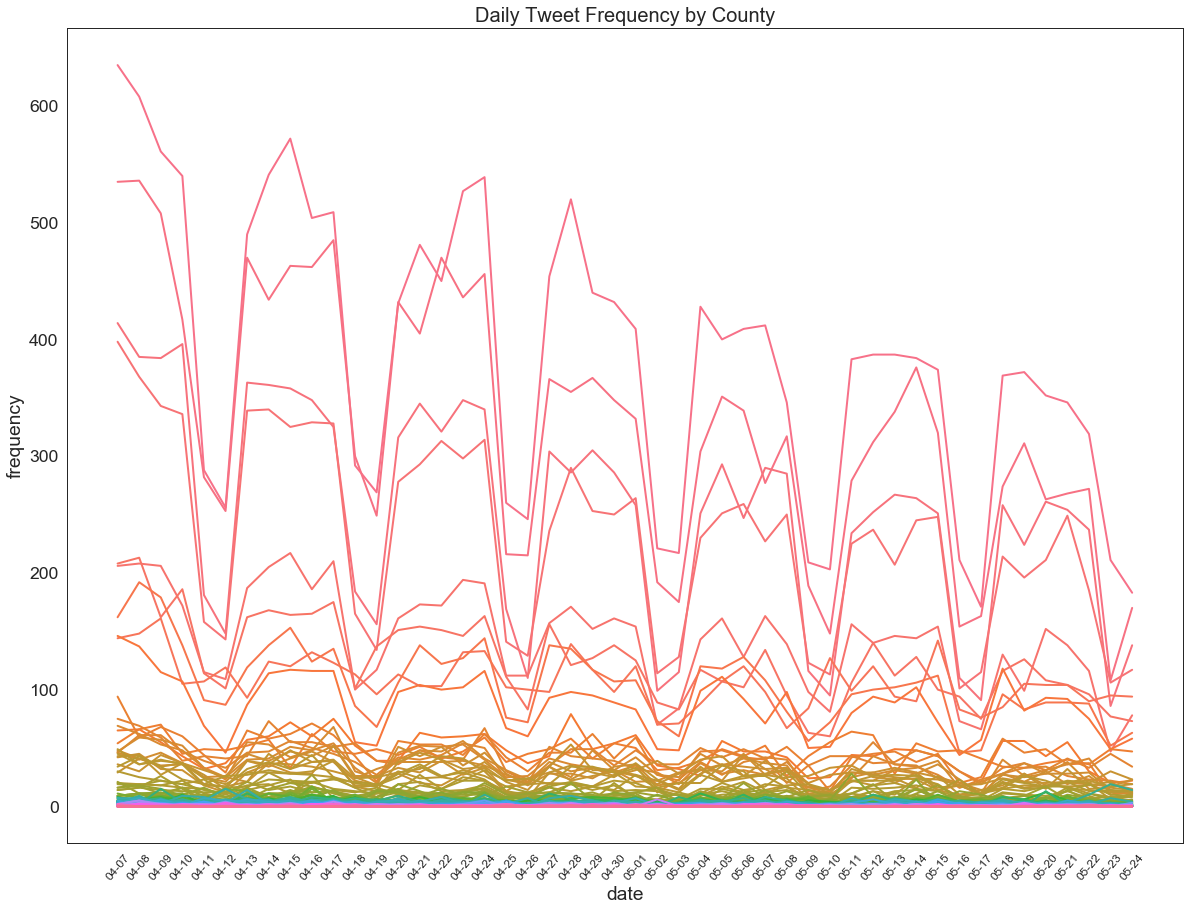

In [208]:
plt.figure(figsize=(20, 15))
ax = sns.lineplot(x="date", y="frequency", hue="county_name", estimator=None, lw=2,
                  data=DTF_long, legend=False)

plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.title('Daily Tweet Frequency by County', size=20);
plt.savefig("Daily Tweet Frequency by County", tight_layout=False)

In [209]:
# # Read in old data set
# DTF_long = pd.read_pickle("DTF_long.pickle")
# DTF_long

## Adding statistics to DSS

 - Add overall tweet frequency by county

In [210]:
# Add total number of tweets per county for reference
freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())
freqs.reset_index(inplace=True)
freqs.columns=['county_name','NumOfTweets']

In [251]:
DSS = pd.merge(DSS, freqs, on='county_name', how="left")
DSS.head()
len(DSS)

36

In [250]:
TotalTF_county = DSS[['county_name', 'NumOfTweets']]
TotalTF_county['percent'] = TotalTF_county['NumOfTweets'] / TotalTF_county['NumOfTweets'].sum()
TotalTF_county.sort_values('percent', ascending=False)
TotalTF_county.to_pickle("TotalTF_county.pickle")

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
# Drop rows that don't have a sentiment score every day
DSS.dropna(inplace=True)
# Save DSS to folder
DSS.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS.csv")
DSS.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_200516.pickle")
len(DSS)

# Create wide data
DSS_wide = pd.melt(DSS, id_vars=['county_name', 'NumOfTweets'])
DSS_wide.columns=['county_name', 'NumOfTweets','date', 'sent_score']
DSS_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_wide.csv")
DSS_wide.to_pickle("DSS_wide_200516.pickle")

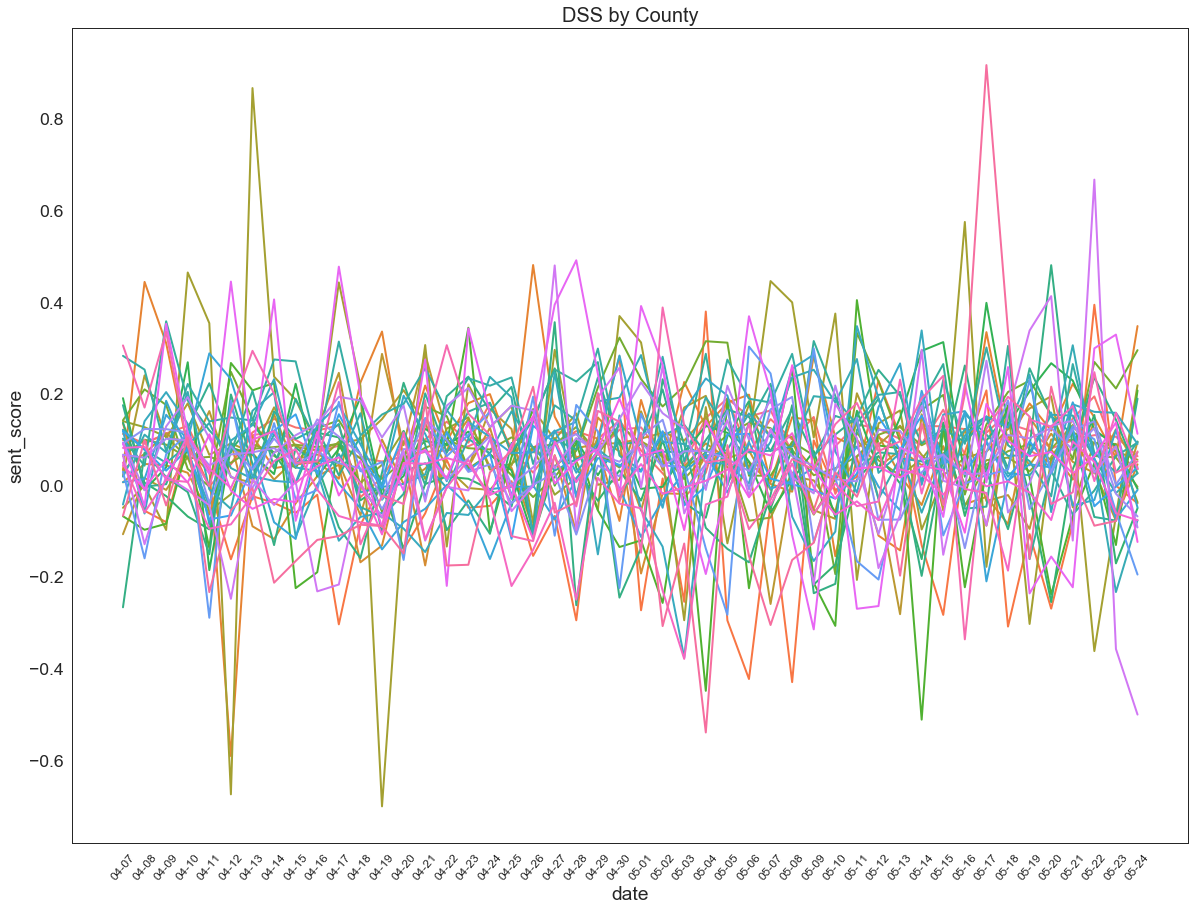

In [213]:
plt.figure(figsize=(20, 15))
ax = sns.lineplot(x="date", y="sent_score", hue="county_name", estimator=None, lw=2,
                  data=DSS_wide, legend=False)

plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.title('DSS by County', size=20);
plt.savefig("DSS County", tight_layout=False)

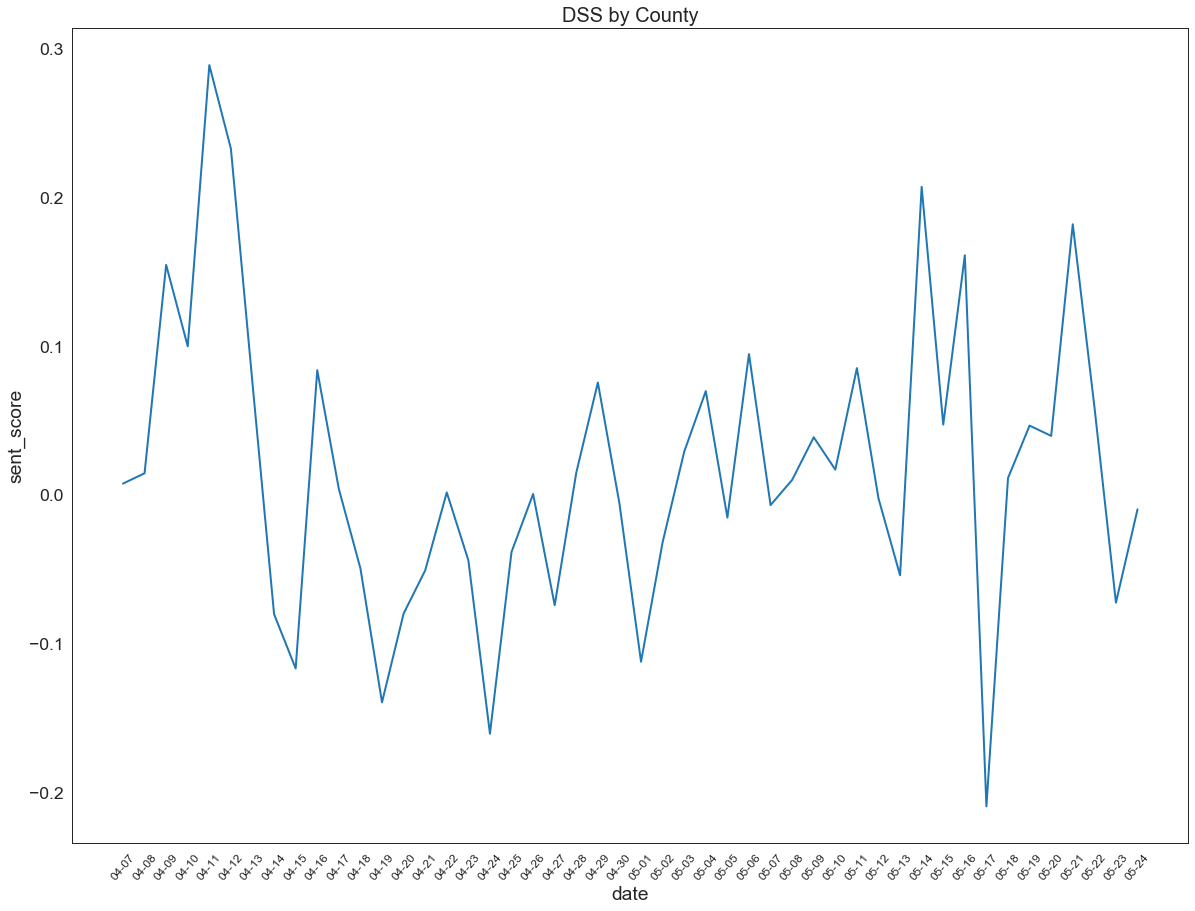

In [214]:
DSS_wide_select = DSS_wide[DSS_wide["county_name"]=="newport news city"]

plt.figure(figsize=(20, 15))
ax = sns.lineplot(x="date", y="sent_score", hue="county_name", estimator=None, lw=2,
                  data=DSS_wide_select, legend=False)

plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.title('DSS by County', size=20);
#plt.savefig("DSS County", tight_layout=False)

In [215]:
DSS_wide_select.sent_score.mean()

0.016853817014311583

In [216]:
DSS_wide

county_name  NumOfTweets   date  sent_score
0     alexandria city      11116        04-07  0.099242  
1     arlington county     12109        04-07  0.112952  
2     bedford county       381          04-07  0.136833  
3     bristol city         443          04-07  0.033833  
4     charlotte county     974          04-07  0.007176  
...                ...     ...            ...       ...  
1723  suffolk city         2060         05-24 -0.122950  
1724  virginia beach city  5987         05-24 -0.075555  
1725  williamsburg city    1310         05-24  0.036436  
1726  winchester city      679          05-24  0.052780  
1727  york county          533          05-24  0.074700  

[1728 rows x 4 columns]

## PCA of Daily Sentiment Score DSS

In [217]:
DSS_for_PCA = DSS.copy()
DSS_for_PCA.set_index('county_name', inplace=True)
DSS_for_PCA.drop(columns='NumOfTweets', inplace=True)
DSS_for_PCA.head()

04-07     04-08     04-09     04-10     04-11     04-12  \
county_name                                                                    
alexandria city   0.099242  0.094447  0.111315  0.090237 -0.000913  0.046577   
arlington county  0.112952  0.091583  0.114026  0.130715  0.028340  0.047672   
bedford county    0.136833 -0.054782 -0.079687  0.102470 -0.002750 -0.160787   
bristol city      0.033833  0.444936  0.311230  0.084631  0.038600 -0.590500   
charlotte county  0.007176  0.047388  0.044376  0.028057 -0.063068  0.094638   

                     04-13     04-14     04-15     04-16  ...     05-15  \
county_name                                               ...             
alexandria city   0.110444  0.117010  0.099704  0.073425  ...  0.165792   
arlington county  0.116204  0.145737  0.127005  0.120145  ...  0.129550   
bedford county   -0.023064 -0.037687 -0.059507 -0.019862  ... -0.282189   
bristol city      0.108033  0.038093  0.046225  0.051912  ...  0.080572   
charlotte county -0.088737 -0.116542 -0.038546  0.020504  ...  0.086388   

                     05-16     05-17     05-18     05-19     05-20     05-21  \
county_name                                                                    
alexandria city   0.067790  0.027501  0.135621  0.120466  0.081155  0.099248   
arlington county  0.123439  0.115643  0.158987  0.077543  0.048882  0.146787   
bedford county    0.073367  0.208040 -0.307750 -0.105750 -0.268567 -0.081140   
bristol city      0.035957  0.335250  0.095529  0.179500  0.120271  0.222283   
charlotte county -0.040275 -0.024491 -0.084100  0.149715  0.079253  0.013164   

                     05-22     05-23     05-24  
county_name                                     
alexandria city   0.110340  0.106803  0.064277  
arlington county  0.194918  0.071212  0.036388  
bedford county    0.395000  0.000000 -0.038600  
bristol city      0.149009  0.061217  0.348500  
charlotte county  0.141568 -0.072717  0.046545  

[5 rows x 48 columns]

In [218]:
DSS_for_PCA.dropna(inplace=True)
DSS_for_PCA.head()

04-07     04-08     04-09     04-10     04-11     04-12  \
county_name                                                                    
alexandria city   0.099242  0.094447  0.111315  0.090237 -0.000913  0.046577   
arlington county  0.112952  0.091583  0.114026  0.130715  0.028340  0.047672   
bedford county    0.136833 -0.054782 -0.079687  0.102470 -0.002750 -0.160787   
bristol city      0.033833  0.444936  0.311230  0.084631  0.038600 -0.590500   
charlotte county  0.007176  0.047388  0.044376  0.028057 -0.063068  0.094638   

                     04-13     04-14     04-15     04-16  ...     05-15  \
county_name                                               ...             
alexandria city   0.110444  0.117010  0.099704  0.073425  ...  0.165792   
arlington county  0.116204  0.145737  0.127005  0.120145  ...  0.129550   
bedford county   -0.023064 -0.037687 -0.059507 -0.019862  ... -0.282189   
bristol city      0.108033  0.038093  0.046225  0.051912  ...  0.080572   
charlotte county -0.088737 -0.116542 -0.038546  0.020504  ...  0.086388   

                     05-16     05-17     05-18     05-19     05-20     05-21  \
county_name                                                                    
alexandria city   0.067790  0.027501  0.135621  0.120466  0.081155  0.099248   
arlington county  0.123439  0.115643  0.158987  0.077543  0.048882  0.146787   
bedford county    0.073367  0.208040 -0.307750 -0.105750 -0.268567 -0.081140   
bristol city      0.035957  0.335250  0.095529  0.179500  0.120271  0.222283   
charlotte county -0.040275 -0.024491 -0.084100  0.149715  0.079253  0.013164   

                     05-22     05-23     05-24  
county_name                                     
alexandria city   0.110340  0.106803  0.064277  
arlington county  0.194918  0.071212  0.036388  
bedford county    0.395000  0.000000 -0.038600  
bristol city      0.149009  0.061217  0.348500  
charlotte county  0.141568 -0.072717  0.046545  

[5 rows x 48 columns]

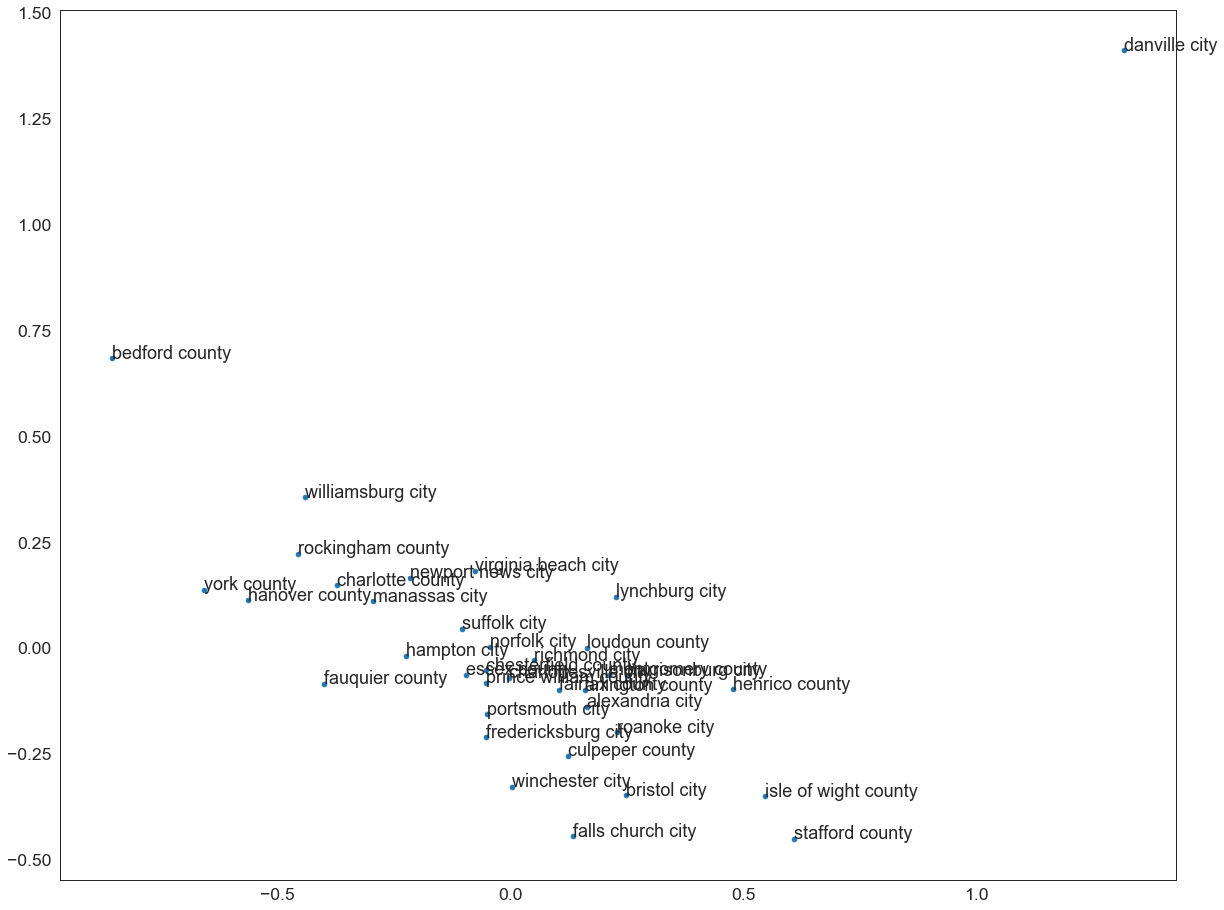

In [219]:
pca = PCA(n_components=2, random_state=RANDOM)
result = pca.fit_transform(DSS_for_PCA)
plt.figure(figsize = (20, 16))
plt.scatter(result[:, 0], result[:, 1])
words = list(DSS_for_PCA.index)
for i, word in enumerate(words):
    plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
plt.show()

In [220]:
DSS_case_wide =pd.merge(DSS_wide, cases_wide, how='left', left_on=['county_name','date'], right_on=['county_name','date'])
DSS_case_wide

county_name  NumOfTweets   date  sent_score  cases_per_1000
0     alexandria city      11116        04-07  0.099242    0.805086      
1     arlington county     12109        04-07  0.112952    1.022420      
2     bedford county       381          04-07  0.136833    0.102685      
3     bristol city         443          04-07  0.033833    0.059372      
4     charlotte county     974          04-07  0.007176    0.082679      
...                ...     ...            ...       ...         ...      
1723  suffolk city         2060         05-24 -0.122950    3.308659      
1724  virginia beach city  5987         05-24 -0.075555    1.339598      
1725  williamsburg city    1310         05-24  0.036436    2.907763      
1726  winchester city      679          05-24  0.052780    5.145921      
1727  york county          533          05-24  0.074700    1.006111      

[1728 rows x 5 columns]

In [221]:
cases_wide.head(100)

county_name   date  cases_per_1000
0   accomack county        04-07  0.335960      
1   albemarle county       04-07  0.357294      
2   alexandria city        04-07  0.805086      
3   alleghany county       04-07  0.130839      
4   amelia county          04-07  0.544578      
5   amherst county         04-07  0.250925      
6   appomattox county      04-07  0.192592      
7   arlington county       04-07  1.022420      
8   augusta county         04-07  0.133867      
9   bedford county         04-07  0.102685      
10  botetourt county       04-07  0.541810      
11  bristol city           04-07  0.059372      
12  brunswick county       04-07  0.060006      
13  buchanan county        04-07  0.045171      
14  buckingham county      04-07  0.352858      
15  buena vista city       04-07  0.625098      
16  campbell county        04-07  0.054377      
17  caroline county        04-07  0.132521      
18  carroll county         04-07  0.067254      
19  charles city county    04-07  0.571837      
20  charlotte county       04-07  0.082679      
21  charlottesville city   04-07  0.488925      
22  chesapeake city        04-07  0.336389      
23  chesterfield county    04-07  0.377084      
24  clarke county          04-07  0.139227      
25  colonial heights city  04-07 NaN            
26  covington city         04-07 NaN            
27  craig county           04-07  0.391160      
28  culpeper county        04-07  0.178394      
29  cumberland county      04-07  0.613121      
30  danville city          04-07  0.361341      
31  dinwiddie county       04-07  0.035326      
32  emporia city           04-07  0.371678      
33  essex county           04-07 NaN            
34  fairfax county         04-07  0.465227      
35  fairfax city           04-07 NaN            
36  falls church city      04-07 NaN            
37  fauquier county        04-07  0.260436      
38  floyd county           04-07 NaN            
39  fluvanna county        04-07  0.342440      
40  franklin county        04-07  0.195615      
41  franklin city          04-07  0.487151      
42  frederick county       04-07  0.504973      
43  fredericksburg city    04-07  0.281007      
44  galax city             04-07  0.150648      
45  giles county           04-07  0.118948      
46  gloucester county      04-07  0.403649      
47  goochland county       04-07  0.978561      
48  grayson county         04-07 NaN            
49  greene county          04-07  0.206079      
50  greensville county     04-07  0.428853      
51  halifax county         04-07  0.057506      
52  hampton city           04-07  0.317149      
53  hanover county         04-07  0.181907      
54  harrisonburg city      04-07  0.505703      
55  henrico county         04-07  0.819919      
56  henry county           04-07  0.077537      
57  highland county        04-07 NaN            
58  hopewell city          04-07  0.580150      
59  isle of wight county   04-07  0.632355      
60  james city county      04-07  1.604790      
61  king george county     04-07  0.386250      
62  king william county    04-07  0.121234      
63  king and queen county  04-07  0.141804      
64  lancaster county       04-07  0.092558      
65  lee county             04-07  0.082871      
66  lexington city         04-07  0.421941      
67  loudoun county         04-07  0.542656      
68  louisa county          04-07  0.395704      
69  lunenburg county       04-07  0.162893      
70  lynchburg city         04-07  0.249591      
71  madison county         04-07  0.304437      
72  manassas park city     04-07  0.243561      
73  manassas city          04-07  0.482428      
74  mathews county         04-07  0.227376      
75  mecklenburg county     04-07  0.389017      
76  middlesex county       04-07 NaN            
77  montgomery county      04-07  0.163270      
78  nelson county          04-07  0.135026      
79  new kent county        04-07  0.568640      
80  newport news city      04-07  0.316412   

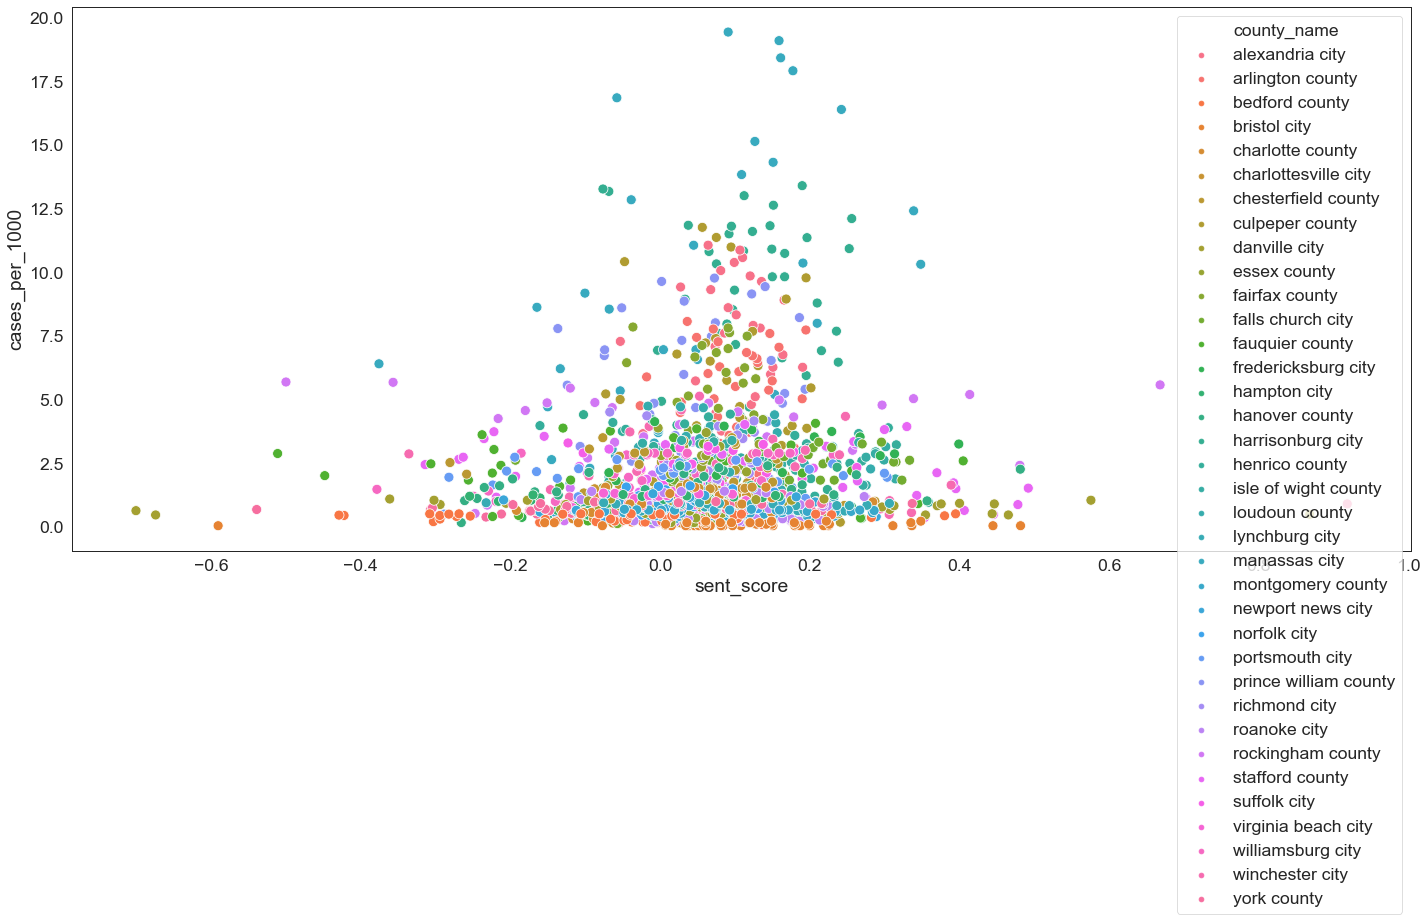

In [222]:
ax = sns.scatterplot(x="sent_score", y="cases_per_1000", hue="county_name",
                     data=DSS_case_wide, s=100 )

# FOR REVIEW = Particular tweets from a county on a specific day

In [223]:
#Bristol took a dip on 4/12
data = data_0412_clean
data = data[data['county_name'] == 'bristol city']
data

user_id             status_id           created_at    screen_name  \
14013  x38112802    x1249451322832797696  2020-04-12 21:36:23  AntsWife81515   
32163  x4795649800  x1249176647577800704  2020-04-12 03:24:56  Supertalk929    
32734  x2547728987  x1249164128889028608  2020-04-12 02:35:11  WCYB_Quon       

                                                                                                                                                                                                                text  \
14013  The coronavirus spreads at least 13 feet, travels on shoes: CDC ⁦@GovernorVA⁩  you may want to read this and adjust social distancing guidelines, such a sad world right now #COVID19 https://t.co/zHdNC8JU4q   
32163  New COVID-19 fatalities reported in region - Read More: https://t.co/n1xtLF6mx6 https://t.co/p8rTfBo0eA                                                                                                         
32734  JUST IN: The VA Dept of Health says a resident of the LENOWISOCO district who was ill with COVID-19 has died. https://t.co/dUxVb9RHdh                                                                           

                   source  display_text_width reply_to_status_id  \
14013  Twitter for iPhone  205                 NaN                 
32163  SuperTalkWFHG.com   79                  NaN                 
32734  Twitter Web App     109                 NaN                 

      reply_to_user_id reply_to_screen_name  ...              profile_url  \
14013  NaN              NaN                  ...  NaN                       
32163  NaN              NaN                  ...  NaN                       
32734  NaN              NaN                  ...  https://t.co/j0PfKKQlXX   

                               profile_expanded_url  account_lang  \
14013  NaN                                          NaN             
32163  NaN                                          NaN             
32734  https://wcyb.com/station/people/kristen-quon NaN             

                                                profile_banner_url  \
14013  https://pbs.twimg.com/profile_banners/38112802/1555204742     
32163  https://pbs.twimg.com/profile_banners/4795649800/1521151899   
32734  https://pbs.twimg.com/profile_banners/2547728987/1580956184   

                                  profile_background_url  \
14013  http://abs.twimg.com/images/themes/theme10/bg.gif   
32163  http://abs.twimg.com/images/themes/theme1/bg.png    
32734  http://abs.twimg.com/images/themes/theme1/bg.png    

                                                                 profile_image_url  \
14013  http://pbs.twimg.com/profile_images/1203189228496138240/yDcINJTJ_normal.jpg   
32163  http://pbs.twimg.com/profile_images/694338556312055809/_42_QddR_normal.jpg    
32734  http://pbs.twimg.com/profile_images/1234242731796549633/YUyaEEq2_normal.jpg   

               X1        X2  location_cleaned   county_name  
14013  2020-04-12  21:36:23  bristol virginia  bristol city  
32163  2020-04-12  03:24:56  bristol va        bristol city  
32734  2020-04-12  02:35:11  bristol va        bristol city  

[3 rows x 94 columns]

In [224]:
# wise county was really high on 4/29
data = data_0429_clean
data = data[data['county_name'] == 'wise county']
data

user_id             status_id           created_at  \
47195  x765220198852993024  x1255303195548626944  2020-04-29 01:09:38   

        screen_name  \
47195  coach_quita_   

                                                                                                                                                                                                                                                                                          text  \
47195  I’ve had some amazing conversations with recruits &amp; high school coaches during this time! Although COVID-19 has the world in slow mo, I’m thankful for the family time &amp; the relationships I’m building!! Excited to get back on the court—whenever that time comes again ❤️❤️🏀   

                   source  display_text_width reply_to_status_id  \
47195  Twitter for iPhone  279                 NaN                 

      reply_to_user_id reply_to_screen_name  ...              profile_url  \
47195  NaN              NaN                  ...  https://t.co/lpKorUNW8A   

                                         profile_expanded_url  account_lang  \
47195  https://m.youtube.com/channel/UCLGQ2ybaXuwiRkda8jUpcNw NaN             

                                                        profile_banner_url  \
47195  https://pbs.twimg.com/profile_banners/765220198852993024/1570047537   

       profile_background_url  \
47195  NaN                      

                                                                 profile_image_url  \
47195  http://pbs.twimg.com/profile_images/1247704455203651584/E_oHTB39_normal.jpg   

               X1        X2 location_cleaned  county_name  
47195  2020-04-29  01:09:38  wise va          wise county  

[1 rows x 94 columns]

In [225]:
# wise county was really high on 4/29
data = data_0415_clean
data = data[data['county_name'] == 'louisa county']
data

user_id             status_id           created_at   screen_name  \
47010  x36099083  x1250374913736822784  2020-04-15 10:46:24  girlgeek_rva   
47881  x96549745  x1250347812656537600  2020-04-15 08:58:43  marygerdt      

                                                                                                                                                                                                                                                                text  \
47010  @DavidBegnaud Unmitigated, the death toll from covid-19 - on the low end, assuming no triage &amp; that it only takes 2% of those infected before infecting enough to get herd immunity - would be roughly equal to US annual death from all causes combined.   
47881  Federal Medicare and State run Medicaid... A quagmire and most people just move on, it’s all so painful. 2 reasons COVID diagnosis “mandate” 1)Funding 2)Politics. Both senseless, frustrating and hard or impossible to change 😢                               

                    source  display_text_width    reply_to_status_id  \
47010  Twitter for Android  239                 x1250156420701589504   
47881  Twitter for iPad     225                 x1250347810710360067   

      reply_to_user_id reply_to_screen_name  ...              profile_url  \
47010  x42971403        DavidBegnaud         ...  NaN                       
47881  x96549745        marygerdt            ...  https://t.co/QMExSVCpLY   

                               profile_expanded_url  account_lang  \
47010  NaN                                          NaN             
47881  http://traveloguefortheuniverse.blogspot.com NaN             

                                              profile_banner_url  \
47010  https://pbs.twimg.com/profile_banners/36099083/1556766857   
47881  https://pbs.twimg.com/profile_banners/96549745/1367027678   

                                  profile_background_url  \
47010  http://abs.twimg.com/images/themes/theme1/bg.png    
47881  http://abs.twimg.com/images/themes/theme18/bg.gif   

                                                                 profile_image_url  \
47010  http://pbs.twimg.com/profile_images/1164392898495954946/Ex0veDi__normal.jpg   
47881  http://pbs.twimg.com/profile_images/1077702983918456833/4nc5dDJO_normal.jpg   

               X1        X2              location_cleaned    county_name  
47010  2020-04-15  10:46:24  greater metropolitan bumpass  louisa county  
47881  2020-04-15  08:58:43  louisavirginia                louisa county  

[2 rows x 94 columns]